# ```esg_finaStat_stockPrice```

# import

In [1]:
import os
import sys
import time
import pickle
import warnings
import urllib.request
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import requests
from bs4 import BeautifulSoup as bs

import FinanceDataReader as fdr
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
# pd.options.display.float_format = '{:.4f}'.format
# plt.style.use("ggplot")
%config InlineBackend.figure_format = 'retina'

sys.path.append("../import")
import module as m

data_path = m.data_path
fp_esg = f"""{data_path}{m.fp["esgRating"]}"""
fp_stock = f"""{data_path}{m.fp["stockPrice"]}"""
fp_fs = f"""{data_path}{m.fp["finaStat"]}"""
fp_ip = f"""{data_path}{m.fp["indexPrice"]}"""
fp_stock_year = f"{data_path}stockPrice_year.parquet"

data_path : ../data/
fp
{'components': '../data/components_list.csv',
 'esgRating': '../data/esgRating.parquet',
 'finaStat': '../data/finaStat.parquet',
 'indexPrice': '../data/indexPrice.parquet',
 'stockPrice': '../data/stockPrice.parquet'}


# `esg_finaStat_stockPrice`

## Data Load

In [5]:
df_stock = m.DataLoad(fp_stock)

Mem. usage decreased to 55.06 Mb (19.9% reduction)


┌▣ df.shape ---- ---- ---- ----
(510968, 21)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510968 entries, 0 to 510967
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   종목코드       510968 non-null  object        
 1   종목명        510968 non-null  object        
 2   연_월_일      510968 non-null  datetime64[ns]
 3   시가         510968 non-null  int64         
 4   고가         510968 non-null  int64         
 5   저가         510968 non-null  int64         
 6   종가         510968 non-null  uint32        
 7   거래량        510968 non-null  int64         
 8   등락률        510936 non-null  float16       
 9   연          510968 non-null  uint16        
 10  분기         510968 non-null  uint8         
 11  월          510968 non-null  uint8         
 12  연_분기       510968 non-null  object        
 13  연_월        510968 non-null  obj

종목코드   종목명      연_월_일    시가    고가    저가    종가     거래량       등락률     연  \
0  000020  동화약품 2011-01-03  5320  5370  5220  5280   78725 -0.001890  2011   
1  000020  동화약품 2011-01-04  5250  5330  5230  5300   58101  0.003788  2011   
2  000020  동화약품 2011-01-05  5300  5350  5220  5240   78870 -0.011322  2011   
3  000020  동화약품 2011-01-06  5240  5250  5070  5110  174303 -0.024811  2011   
4  000020  동화약품 2011-01-07  5110  5150  5080  5090   36832 -0.003914  2011   

   분기  월    연_분기     연_월 분기_월    연_분기_월  일  월_일  시가_mmscl  종가_mmscl  거래량_mmscl  
0   1  1  2011-1  2011-1  1-1  2011-1-1  3  1-3  0.141724  0.133301   0.015808  
1   1  1  2011-1  2011-1  1-1  2011-1-1  4  1-4  0.134155  0.135498   0.011269  
2   1  1  2011-1  2011-1  1-1  2011-1-1  5  1-5  0.139648  0.128906   0.015839  
3   1  1  2011-1  2011-1  1-1  2011-1-1  6  1-6  0.133057  0.114563   0.036896  
4   1  1  2011-1  2011-1  1-1  2011-1-1  7  1-7  0.119019  0.112305   0.006580



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '시가', '고가', '저가', '종가', '거래량', '등락률', '연', '분기', '월', '연_분기', '연_월', '분기_월', '연_분기_월', '일', '월_일', '시가_mmscl', '종가_mmscl', '거래량_mmscl']


## 연평균

In [6]:
dict_agg = {
    "시가": "mean",
    "고가": "max",
    "저가": "min",
    "종가": "mean",
    "거래량": "sum",
    "시가_mmscl": "mean",
    "종가_mmscl": "mean",
}

df_stock_year = df_stock.groupby(["종목코드", "종목명", "연"]).agg(dict_agg)
df_stock_year = df_stock_year.reset_index()
df_stock_year.head()

종목코드   종목명     연           시가     고가    저가           종가       거래량  \
0  000020  동화약품  2011  4776.673387   6470  3860  4764.153226  35915126   
1  000020  동화약품  2012  5344.415323   6800  4060  5341.673387  32035524   
2  000020  동화약품  2013  6121.659919   7420  4315  6117.024291  20256240   
3  000020  동화약품  2014  5496.857143   6560  4410  5508.265306  20925838   
4  000020  동화약품  2015  7659.596774  12250  5400  7661.370968  54304424   

   시가_mmscl  종가_mmscl  
0  0.082947  0.076477  
1  0.144409  0.140015  
2  0.228516  0.225464  
3  0.160889  0.158447  
4  0.395020  0.395508

## esgRating

### Data Load

In [31]:
df_esg = m.DataLoad(fp_esg)

Mem. usage decreased to  0.14 Mb (18.5% reduction)


┌▣ df.shape ---- ---- ---- ----
(5654, 11)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   종목코드       4265 non-null   object  
 1   종목명        5654 non-null   object  
 2   연          5654 non-null   uint16  
 3   ESG종합      5453 non-null   category
 4   E          5650 non-null   category
 5   S          5493 non-null   category
 6   G          5301 non-null   category
 7   ESG종합_enc  5453 non-null   category
 8   E_enc      5650 non-null   category
 9   S_enc      5493 non-null   category
 10  G_enc      5301 non-null   category
dtypes: category(8), object(2), uint16(1)
memory usage: 145.6+ KB
None


┌▣ df.head() ---- ---- ---- ----


종목코드       종목명     연 ESG종합  E  S   G ESG종합_enc E_enc S_enc G_enc
0    None    서울도시가스  2018     B  B  B   B         2     2     2     2
1    None  티비에이치글로벌  2018     B  B  B   B         2     2     2     2
2  090080      평화산업  2018     B  B  B  B+         2     2     2     3
3  001020    페이퍼코리아  2018     B  C  B   B         2     1     2     2
4  016800       퍼시스  2018     B  B  B   B         2     2     2     2



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']


### 병합

In [10]:
df_Stock_year_esg = pd.merge(df_esg, df_stock_year, how='left', on=["종목코드",'연'])
df_Stock_year_esg

종목코드     종목명_x     연 ESG종합   E    S    G ESG종합_enc E_enc S_enc G_enc  \
0       None    서울도시가스  2018     B   B    B    B         2     2     2     2   
1       None  티비에이치글로벌  2018     B   B    B    B         2     2     2     2   
2     090080      평화산업  2018     B   B    B   B+         2     2     2     3   
3     001020    페이퍼코리아  2018     B   C    B    B         2     1     2     2   
4     016800       퍼시스  2018     B   B    B    B         2     2     2     2   
...      ...       ...   ...   ...  ..  ...  ...       ...   ...   ...   ...   
5649  004980      성신양회  2011     B  B+    B    B         2     3     2     2   
5650  003080      성보화학  2011   NaN   B  NaN  NaN       NaN     2   NaN   NaN   
5651  014910      성문전자  2011     B   C    B    B         2     1     2     2   
5652    None      선창산업  2011     B   B    B    B         2     2     2     2   
5653  006840     AK홀딩스  2011     B   B    B    B         2     2     2     2   

      종목명_y            시가       고가       저가            종가         거래량  \
0       NaN           NaN      NaN      NaN           NaN         NaN   
1       NaN           NaN      NaN      NaN           NaN         NaN   
2       NaN           NaN      NaN      NaN           NaN         NaN   
3       NaN           NaN      NaN      NaN           NaN         NaN   
4       퍼시스  31145.901639  36100.0  27000.0  31253.073770    423886.0   
...     ...           ...      ...      ...           ...         ...   
5649    NaN           NaN      NaN      NaN           NaN         NaN   
5650    NaN           NaN      NaN      NaN           NaN         NaN   
5651    NaN           NaN      NaN      NaN           NaN         NaN   
5652    NaN           NaN      NaN      NaN           NaN         NaN   
5653  AK홀딩스  25141.229839  37253.0  16842.0  25120.612903  11047643.0   

      시가_mmscl  종가_mmscl  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4     0.810059  0.570312  
...        ...       ...  
5649       NaN       NaN  
5650       NaN       NaN  
5651       NaN       NaN  
5652       NaN       NaN  
5653  0.239502  0.114014  

[5654 rows x 19 columns]

### 전처리

In [11]:
df_Stock_year_esg.drop(["종목명_y"], axis="columns", inplace=True)
d = {
    "종목명_x": "종목명",
    "시가": "시가_연평균",
    "고가": "고가_연",
    "저가": "저가_연",
    "종가": "종가_연평균",
    "시가_mmscl": "시가_mmscl_연평균",
    "고가_mmscl": "고가_mmscl_연",
    "저가_mmscl": "저가_mmscl_연",
    "종가_mmscl": "종가_mmscl_연평균",
}
df_Stock_year_esg.rename(columns=d, inplace=True)
df_Stock_year_esg

종목코드       종목명     연 ESG종합   E    S    G ESG종합_enc E_enc S_enc G_enc  \
0       None    서울도시가스  2018     B   B    B    B         2     2     2     2   
1       None  티비에이치글로벌  2018     B   B    B    B         2     2     2     2   
2     090080      평화산업  2018     B   B    B   B+         2     2     2     3   
3     001020    페이퍼코리아  2018     B   C    B    B         2     1     2     2   
4     016800       퍼시스  2018     B   B    B    B         2     2     2     2   
...      ...       ...   ...   ...  ..  ...  ...       ...   ...   ...   ...   
5649  004980      성신양회  2011     B  B+    B    B         2     3     2     2   
5650  003080      성보화학  2011   NaN   B  NaN  NaN       NaN     2   NaN   NaN   
5651  014910      성문전자  2011     B   C    B    B         2     1     2     2   
5652    None      선창산업  2011     B   B    B    B         2     2     2     2   
5653  006840     AK홀딩스  2011     B   B    B    B         2     2     2     2   

            시가_연평균     고가_연     저가_연        종가_연평균         거래량  시가_mmscl_연평균  \
0              NaN      NaN      NaN           NaN         NaN           NaN   
1              NaN      NaN      NaN           NaN         NaN           NaN   
2              NaN      NaN      NaN           NaN         NaN           NaN   
3              NaN      NaN      NaN           NaN         NaN           NaN   
4     31145.901639  36100.0  27000.0  31253.073770    423886.0      0.810059   
...            ...      ...      ...           ...         ...           ...   
5649           NaN      NaN      NaN           NaN         NaN           NaN   
5650           NaN      NaN      NaN           NaN         NaN           NaN   
5651           NaN      NaN      NaN           NaN         NaN           NaN   
5652           NaN      NaN      NaN           NaN         NaN           NaN   
5653  25141.229839  37253.0  16842.0  25120.612903  11047643.0      0.239502   

      종가_mmscl_연평균  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4         0.570312  
...            ...  
5649           NaN  
5650           NaN  
5651           NaN  
5652           NaN  
5653      0.114014  

[5654 rows x 18 columns]

In [12]:
df_Stock_year_esg.dropna(axis=0, subset=['종가_연평균'], inplace=True)
df_Stock_year_esg["거래량"] = df_Stock_year_esg["거래량"].astype(int)
df_Stock_year_esg["고가_연"] = df_Stock_year_esg["고가_연"].astype(int)
df_Stock_year_esg["저가_연"] = df_Stock_year_esg["저가_연"].astype(int)
df_Stock_year_esg

종목코드    종목명     연 ESG종합   E  S    G ESG종합_enc E_enc S_enc G_enc  \
4     016800    퍼시스  2018     B   B  B    B         2     2     2     2   
6     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
7     036580    팜스코  2018     B   B  B    B         2     2     2     2   
8     005690    파미셀  2018     B   B  B    B         2     2     2     2   
19    003240   태광산업  2018     B   C  B    B         2     1     2     2   
...      ...    ...   ...   ...  .. ..  ...       ...   ...   ...   ...   
5619  007860     서연  2011     B   C  B    B         2     1     2     2   
5632  005500   삼진제약  2011     B  B+  B  NaN         2     3     2   NaN   
5634  008490     서흥  2011     B   B  B  NaN         2     2     2   NaN   
5636  004490   세방전지  2011     B   B  B    B         2     2     2     2   
5653  006840  AK홀딩스  2011     B   B  B    B         2     2     2     2   

            시가_연평균     고가_연     저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
4     3.114590e+04    36100    27000  3.125307e+04     423886      0.810059   
6     5.122398e+03     6350     4130  5.114467e+03  532291320      0.028900   
7     1.116492e+04    14250     7480  1.116508e+04   17665857      0.441895   
8     1.395484e+04    26350     5310  1.398189e+04  631715794      0.544922   
19    1.396410e+06  1709000  1150000  1.397352e+06     234952      0.576660   
...            ...      ...      ...           ...        ...           ...   
5619  4.996190e+03     8028     3006  4.981395e+03  208381493      0.219604   
5632  8.810161e+03    11600     6500  8.802540e+03   16489385      0.034760   
5634  1.077121e+04    16250     7200  1.080387e+04    8367466      0.063965   
5636  4.063367e+04    49600    32300  4.070544e+04    8594786      0.333252   
5653  2.514123e+04    37253    16842  2.512061e+04   11047643      0.239502   

      종가_mmscl_연평균  
4         0.570312  
6         0.012985  
7         0.447510  
8         0.500000  
19        0.577148  
...            ...  
5619      0.102783  
5632      0.036346  
5634      0.064758  
5636      0.338135  
5653      0.114014  

[1617 rows x 18 columns]

## merge_finaStat

### Data Load

In [30]:
df_fs = m.DataLoad(fp_fs)

Mem. usage decreased to  0.30 Mb (27.1% reduction)


┌▣ df.shape ---- ---- ---- ----
(1984, 31)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   종목코드            1984 non-null   object        
 1   종목명             1984 non-null   object        
 2   연_월_일           1984 non-null   datetime64[ns]
 3   재무제표구분코드명       1984 non-null   object        
 4   기업매출금액          1984 non-null   int64         
 5   기업영업이익          1984 non-null   int64         
 6   포괄손익계산금액        1984 non-null   int64         
 7   기업당기순이익         1984 non-null   int64         
 8   기업총자산금액         1984 non-null   int64         
 9   기업총부채금액         1984 non-null   int64         
 10  기업총자본금액         1984 non-null   int64         
 11  기업자본금액          1984 non-null   int64         
 12  재무제표부채비율        1984 non-null

종목코드   종목명      연_월_일 재무제표구분코드명        기업매출금액       기업영업이익     포괄손익계산금액  \
0  000020  동화약품 2015-12-31  별도요약재무제표  223201285434   4812973681   6000622879   
1  000020  동화약품 2016-12-31  별도요약재무제표  237470834801  11259333902  35655076190   
2  000020  동화약품 2017-12-31  별도요약재무제표  258881616575  10987308187  65218742497   
3  000020  동화약품 2018-12-31  별도요약재무제표  306602589029  11232142004  14545424343   
4  000020  동화약품 2018-12-31  연결요약재무제표  306602589029  11225780035  14539062374   

       기업당기순이익       기업총자산금액      기업총부채금액       기업총자본금액       기업자본금액  \
0   5608652157  317187030052  87069287627  230117742425  27931470000   
1  26254318411  324604536650  71679236748  252925299902  27931470000   
2  47009013175  367225133428  70280404999  296944728429  27931470000   
3  10074474538  370294498762  73197485231  297097013531  27931470000   
4  10068112569  370599242793  73198591231  297400651562  27931470000   

    재무제표부채비율     연  분기   월   일    연_분기      연_월  분기_월    월_일     연_분기_월  \
0  37.843750  2015   4  12  31  2015-4  2015-12  4-12  12-31  2015-4-12   
1  28.343750  2016   4  12  31  2016-4  2016-12  4-12  12-31  2016-4-12   
2  23.671875  2017   4  12  31  2017-4  2017-12  4-12  12-31  2017-4-12   
3  24.640625  2018   4  12  31  2018-4  2018-12  4-12  12-31  2018-4-12   
4  24.609375  2018   4  12  31  2018-4  2018-12  4-12  12-31  2018-4-12   

   기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  기업총자산금액_mmscl  \
0      0.000000      0.000000        0.000000       0.000000       0.000000   
1      0.171143      1.000000        0.500977       0.498779       0.138916   
2      0.427734      0.958008        1.000000       1.000000       0.937012   
3      1.000000      0.995605        0.144287       0.107849       0.994141   
4      1.000000      0.994629        0.144165       0.107727       1.000000   

   기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       1.000000       0.000000           0.0        1.000000  
1       0.083313       0.338867           0.0        0.329834  
2       0.000000       0.993164           0.0        0.000000  
3       0.173706       0.995605           0.0        0.068420  
4       0.173828       1.000000           0.0        0.066711



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '연', '분기', '월', '일', '연_분기', '연_월', '분기_월', '월_일', '연_분기_월', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 연평균

In [14]:
dict_agg = {}
l = [
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]


for i in l:
    dict_agg[i] = "mean"

df_fs_year = df_fs.groupby(["종목코드", "종목명", "연", "재무제표구분코드명"]).agg(dict_agg)
df_fs_year = df_fs_year.reset_index()
df_fs_year.head()

종목코드   종목명     연 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0  000020  동화약품  2015  별도요약재무제표  2.232013e+11  4.812974e+09  6.000623e+09   
1  000020  동화약품  2016  별도요약재무제표  2.374708e+11  1.125933e+10  3.565508e+10   
2  000020  동화약품  2017  별도요약재무제표  2.588816e+11  1.098731e+10  6.521874e+10   
3  000020  동화약품  2018  별도요약재무제표  3.066026e+11  1.123214e+10  1.454542e+10   
4  000020  동화약품  2018  연결요약재무제표  3.066026e+11  1.122578e+10  1.453906e+10   

        기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0  5.608652e+09  3.171870e+11  8.706929e+10  2.301177e+11  2.793147e+10   
1  2.625432e+10  3.246045e+11  7.167924e+10  2.529253e+11  2.793147e+10   
2  4.700901e+10  3.672251e+11  7.028040e+10  2.969447e+11  2.793147e+10   
3  1.007447e+10  3.702945e+11  7.319749e+10  2.970970e+11  2.793147e+10   
4  1.006811e+10  3.705992e+11  7.319859e+10  2.974007e+11  2.793147e+10   

    재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0  37.843750      0.000000      0.000000        0.000000       0.000000   
1  28.343750      0.171143      1.000000        0.500977       0.498779   
2  23.671875      0.427734      0.958008        1.000000       1.000000   
3  24.640625      1.000000      0.995605        0.144287       0.107849   
4  24.609375      1.000000      0.994629        0.144165       0.107727   

   기업총자산금액_mmscl  기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       0.000000       1.000000       0.000000           0.0        1.000000  
1       0.138916       0.083313       0.338867           0.0        0.329834  
2       0.937012       0.000000       0.993164           0.0        0.000000  
3       0.994141       0.173706       0.995605           0.0        0.068420  
4       1.000000       0.173828       1.000000           0.0        0.066711

### 병합

In [15]:
df_Stock_year_esgFn = pd.merge(df_Stock_year_esg, df_fs_year, how='left', on=["종목코드",'연'])
df_Stock_year_esgFn.drop(['종목명_y'], axis='columns', inplace=True)
df_Stock_year_esgFn.rename(columns={'종목명_x':'종목명'}, inplace=True)
df_Stock_year_esgFn

종목코드    종목명     연 ESG종합   E  S    G ESG종합_enc E_enc S_enc G_enc  \
0     016800    퍼시스  2018     B   B  B    B         2     2     2     2   
1     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
2     028670    팬오션  2018    B+  B+  B    B         3     3     2     2   
3     036580    팜스코  2018     B   B  B    B         2     2     2     2   
4     036580    팜스코  2018     B   B  B    B         2     2     2     2   
...      ...    ...   ...   ...  .. ..  ...       ...   ...   ...   ...   
2273  007860     서연  2011     B   C  B    B         2     1     2     2   
2274  005500   삼진제약  2011     B  B+  B  NaN         2     3     2   NaN   
2275  008490     서흥  2011     B   B  B  NaN         2     2     2   NaN   
2276  004490   세방전지  2011     B   B  B    B         2     2     2     2   
2277  006840  AK홀딩스  2011     B   B  B    B         2     2     2     2   

            시가_연평균   고가_연   저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
0     31145.901639  36100  27000  31253.073770     423886      0.810059   
1      5122.397541   6350   4130   5114.467213  532291320      0.028900   
2      5122.397541   6350   4130   5114.467213  532291320      0.028900   
3     11164.918033  14250   7480  11165.081967   17665857      0.441895   
4     11164.918033  14250   7480  11165.081967   17665857      0.441895   
...            ...    ...    ...           ...        ...           ...   
2273   4996.189516   8028   3006   4981.395161  208381493      0.219604   
2274   8810.161290  11600   6500   8802.540323   16489385      0.034760   
2275  10771.209677  16250   7200  10803.870968    8367466      0.063965   
2276  40633.669355  49600  32300  40705.443548    8594786      0.333252   
2277  25141.229839  37253  16842  25120.612903   11047643      0.239502   

      종가_mmscl_연평균 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0         0.570312  별도요약재무제표  3.156692e+11  2.771981e+10  5.895902e+10   
1         0.012985  별도요약재무제표  2.337517e+12  2.030190e+11  1.435840e+11   
2         0.012985  연결요약재무제표  2.668353e+12  2.039360e+11  1.489940e+11   
3         0.447510  별도요약재무제표  9.331067e+11  2.942415e+10  1.705147e+10   
4         0.447510  연결요약재무제표  1.015668e+12  2.372060e+10  7.068184e+09   
...            ...       ...           ...           ...           ...   
2273      0.102783       NaN           NaN           NaN           NaN   
2274      0.036346       NaN           NaN           NaN           NaN   
2275      0.064758       NaN           NaN           NaN           NaN   
2276      0.338135       NaN           NaN           NaN           NaN   
2277      0.114014       NaN           NaN           NaN           NaN   

           기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0     4.549515e+10  4.841723e+11  6.359987e+10  4.205724e+11  1.430000e+10   
1     1.442480e+11  4.054723e+12  1.432182e+12  2.622541e+12  5.345690e+11   
2     1.486450e+11  4.119496e+12  1.459059e+12  2.660437e+12  5.345690e+11   
3     1.047776e+10  7.976526e+11  4.446249e+11  3.530277e+11  1.836397e+10   
4     3.453458e+09  8.831553e+11  5.733331e+11  3.098221e+11  1.836397e+10   
...            ...           ...           ...           ...           ...   
2273           NaN           NaN           NaN           NaN           NaN   
2274           NaN           NaN           NaN           NaN           NaN   
2275           NaN           NaN           NaN           NaN           NaN   
2276           NaN           NaN           NaN           NaN           NaN   
2277           NaN           NaN           NaN           NaN           NaN   

       재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0      15.12500      1.000000      1.000000        1.000000       1.000000   
1      54.62500      0.688477      0.621582        0.946777       0.957520   
2      54.84375      1.000000      0.634766        1.000000       1.000000   
3     125.93750      0.422852      0.306396        0.225098       0.

## 영속화

In [41]:
m.DfPrst(df_Stock_year_esgFn, fp_stock_year)

['../data/stockPrice_year.parquet']


# 연도, 등급별 주가와 제무제표

## Data Load

In [2]:
df = m.DataLoad(fp_stock_year, reduce_mem=False)



┌▣ df.shape ---- ---- ---- ----
(2278, 37)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   종목코드            2278 non-null   object 
 1   종목명             2278 non-null   object 
 2   연               2278 non-null   uint16 
 3   ESG종합           2251 non-null   object 
 4   E               2278 non-null   object 
 5   S               2252 non-null   object 
 6   G               2209 non-null   object 
 7   ESG종합_enc       2251 non-null   object 
 8   E_enc           2278 non-null   object 
 9   S_enc           2252 non-null   object 
 10  G_enc           2209 non-null   object 
 11  시가_연평균          2278 non-null   float64
 12  고가_연            2278 non-null   int32  
 13  저가_연            2278 non-null   int32  
 14  종가_연평균          2278 non-null   float64
 15  거래량             2278 non-null   int32  
 16

종목코드  종목명     연 ESG종합   E  S  G ESG종합_enc E_enc S_enc G_enc  \
0  016800  퍼시스  2018     B   B  B  B         2     2     2     2   
1  028670  팬오션  2018    B+  B+  B  B         3     3     2     2   
2  028670  팬오션  2018    B+  B+  B  B         3     3     2     2   
3  036580  팜스코  2018     B   B  B  B         2     2     2     2   
4  036580  팜스코  2018     B   B  B  B         2     2     2     2   

         시가_연평균   고가_연   저가_연        종가_연평균        거래량  시가_mmscl_연평균  \
0  31145.901639  36100  27000  31253.073770     423886      0.810059   
1   5122.397541   6350   4130   5114.467213  532291320      0.028900   
2   5122.397541   6350   4130   5114.467213  532291320      0.028900   
3  11164.918033  14250   7480  11165.081967   17665857      0.441895   
4  11164.918033  14250   7480  11165.081967   17665857      0.441895   

   종가_mmscl_연평균 재무제표구분코드명        기업매출금액        기업영업이익      포괄손익계산금액  \
0      0.570312  별도요약재무제표  3.156692e+11  2.771981e+10  5.895902e+10   
1      0.012985  별도요약재무제표  2.337517e+12  2.030190e+11  1.435840e+11   
2      0.012985  연결요약재무제표  2.668353e+12  2.039360e+11  1.489940e+11   
3      0.447510  별도요약재무제표  9.331067e+11  2.942415e+10  1.705147e+10   
4      0.447510  연결요약재무제표  1.015668e+12  2.372060e+10  7.068184e+09   

        기업당기순이익       기업총자산금액       기업총부채금액       기업총자본금액        기업자본금액  \
0  4.549515e+10  4.841723e+11  6.359987e+10  4.205724e+11  1.430000e+10   
1  1.442480e+11  4.054723e+12  1.432182e+12  2.622541e+12  5.345690e+11   
2  1.486450e+11  4.119496e+12  1.459059e+12  2.660437e+12  5.345690e+11   
3  1.047776e+10  7.976526e+11  4.446249e+11  3.530277e+11  1.836397e+10   
4  3.453458e+09  8.831553e+11  5.733331e+11  3.098221e+11  1.836397e+10   

    재무제표부채비율  기업매출금액_mmscl  기업영업이익_mmscl  포괄손익계산금액_mmscl  기업당기순이익_mmscl  \
0   15.12500      1.000000      1.000000        1.000000       1.000000   
1   54.62500      0.688477      0.621582        0.946777       0.957520   
2   54.84375      1.000000      0.634766        1.000000       1.000000   
3  125.93750      0.422852      0.306396        0.225098       0.195557   
4  185.00000      0.951172      0.000000        0.000000       0.000000   

   기업총자산금액_mmscl  기업총부채금액_mmscl  기업총자본금액_mmscl  기업자본금액_mmscl  재무제표부채비율_mmscl  
0       1.000000       1.000000       1.000000           1.0        1.000000  
1       0.458740       0.000000       0.868164           1.0        0.000000  
2       0.585938       0.059631       1.000000           1.0        0.010178  
3       0.664062       0.536621       0.972656           1.0        0.376953  
4       1.000000       1.000000       0.490967           1.0        0.934082



┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc', '시가_연평균', '고가_연', '저가_연', '종가_연평균', '거래량', '시가_mmscl_연평균', '종가_mmscl_연평균', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 전처리 : 등급 결측치

In [3]:
df[['ESG종합', 'E', 'S', 'G']] = df[['ESG종합', 'E', 'S', 'G']].fillna("N")
df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']] = df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].fillna("0")
display(df[['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].isna().sum().to_frame())
df["ESG종합"].unique()

0
ESG종합      0
E          0
S          0
G          0
ESG종합_enc  0
E_enc      0
S_enc      0
G_enc      0

array(['B', 'B+', 'A+', 'N', 'A'], dtype=object)

### 전처리 : 등급 순서 정렬

In [4]:
l = ['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']
s = ["S","A+","A","B+","B","C","D","N"]
df[l] = df[l].astype("category")

for i in l:
    not_in_list = df[i].cat.categories.difference(s)
    df[i] = df[i].cat.set_categories(np.hstack((s, not_in_list)), ordered=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   종목코드            2278 non-null   object  
 1   종목명             2278 non-null   object  
 2   연               2278 non-null   uint16  
 3   ESG종합           2278 non-null   category
 4   E               2278 non-null   category
 5   S               2278 non-null   category
 6   G               2278 non-null   category
 7   ESG종합_enc       2278 non-null   category
 8   E_enc           2278 non-null   category
 9   S_enc           2278 non-null   category
 10  G_enc           2278 non-null   category
 11  시가_연평균          2278 non-null   float64 
 12  고가_연            2278 non-null   int32   
 13  저가_연            2278 non-null   int32   
 14  종가_연평균          2278 non-null   float64 
 15  거래량             2278 non-null   int32   
 16  시가_mmscl_연평균    2278 non-null   float32 
 17  종가_mmscl_연평균  

## EDA

### Summary



┌▣ df.describe().T ---- ---- ---- ----


count          mean           std           min  \
연               2278.0  2.015162e+03  2.197658e+00  2.011000e+03   
시가_연평균          2278.0  9.242619e+04  1.988790e+05  1.540040e+02   
고가_연            2278.0  1.219673e+05  2.775586e+05  1.042000e+03   
저가_연            2278.0  6.720837e+04  1.409304e+05  0.000000e+00   
종가_연평균          2278.0  9.262286e+04  1.988504e+05  6.218525e+02   
거래량             2278.0  8.218463e+07  1.744116e+08 -2.147484e+09   
시가_mmscl_연평균    2278.0  4.008793e-01  2.079404e-01  1.285553e-03   
종가_mmscl_연평균    2278.0  3.707010e-01  2.077108e-01  3.366470e-03   
기업매출금액          1400.0  5.330003e+12  1.648152e+13  0.000000e+00   
기업영업이익          1400.0  4.863418e+11  3.027902e+12 -2.263764e+12   
포괄손익계산금액        1400.0  4.845939e+11  3.152545e+12 -3.342442e+12   
기업당기순이익         1400.0  3.724946e+11  2.362547e+12 -2.990997e+12   
기업총자산금액         1400.0  7.110487e+12  2.230426e+13  0.000000e+00   
기업총부채금액         1400.0  3.338569e+12  1.045734e+13  0.000000e+00   
기업총자본금액         1400.0  3.764560e+12  1.455958e+13 -6.123196e+11   
기업자본금액          1400.0  1.135329e+11  3.241758e+11  0.000000e+00   
재무제표부채비율        1400.0  1.095035e+02  2.625236e+02 -2.400000e+03   
기업매출금액_mmscl    1400.0  4.639259e-01  3.893327e-01  0.000000e+00   
기업영업이익_mmscl    1400.0  4.825087e-01  3.698301e-01  0.000000e+00   
포괄손익계산금액_mmscl  1400.0  4.900286e-01  3.705168e-01  0.000000e+00   
기업당기순이익_mmscl   1400.0  4.832098e-01  3.735678e-01  0.000000e+00   
기업총자산금액_mmscl   1400.0  4.681258e-01  3.772752e-01  0.000000e+00   
기업총부채금액_mmscl   1400.0  4.553119e-01  3.824284e-01  0.000000e+00   
기업총자본금액_mmscl   1400.0  4.960833e-01  3.743453e-01  0.000000e+00   
기업자본금액_mmscl    1400.0  4.382610e-01  4.886360e-01  0.000000e+00   
재무제표부채비율_mmscl  1400.0  4.565847e-01  3.751768e-01  0.000000e+00   

                         25%           50%           75%           max  
연               2.013000e+03  2.016000e+03  2.017000e+03  2.018000e+03  
시가_연평균          1.258827e+04  3.615812e+04  8.680446e+04  4.308539e+06  
고가_연            1.658800e+04  4.585000e+04  1.156250e+05  6.638271e+06  
저가_연            8.028500e+03  2.570350e+04  6.187500e+04  2.333562e+06  
종가_연평균          1.271480e+04  3.623065e+04  8.683059e+04  4.293230e+06  
거래량             1.187636e+07  3.601855e+07  8.037019e+07  1.895385e+09  
시가_mmscl_연평균    2.313232e-01  3.980713e-01  5.678711e-01  8.964844e-01  
종가_mmscl_연평균    1.968994e-01  3.629150e-01  5.371094e-01  8.466797e-01  
기업매출금액          4.469379e+11  1.157053e+12  3.628566e+12  2.437714e+14  
기업영업이익          2.015148e+10  6.007531e+10  2.076846e+11  5.888667e+13  
포괄손익계산금액        1.503856e+10  5.310261e+10  1.905352e+11  6.115996e+13  
기업당기순이익         1.025050e+10  4.112001e+10  1.587944e+11  4.434486e+13  
기업총자산금액         6.563117e+11  1.448632e+12  4.804206e+12  3.393572e+14  
기업총부채금액         1.997262e+11  5.216165e+11  2.090925e+12  1.525955e+14  
기업총자본금액         3.846715e+11  8.410533e+11  2.563013e+12  2.477532e+14  
기업자본금액          0.000000e+00  1.944781e+10  7.057230e+10  3.657652e+12  
재무제표부채비율        3.039844e+01  6.859375e+01  1.220625e+02  5.544000e+03  
기업매출금액_mmscl    4.356384e-02  4.284668e-01  8.720703e-01  1.000000e+00  
기업영업이익_mmscl    1.076965e-01  4.720459e-01  8.433838e-01  1.000000e+00  
포괄손익계산금액_mmscl  1.238098e-01  4.814453e-01  8.511963e-01  1.000000e+00  
기업당기순이익_mmscl   1.043549e-01  4.677734e-01  8.671875e-01  1.000000e+00  
기업총자산금액_mmscl   8.584595e-02  4.251709e-01  8.591309e-01  1.000000e+00  
기업총부채금액_mmscl   5.825806e-02  4.008789e-01  8.594971e-01  1.000000e+00  
기업총자본금액_mmscl   1.129761e-01  5.036621e-01  8.698730e-01  1.000000e+00  
기업자본금액_mmscl    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
재무제표부채비율_mmscl  7.324219e-02  4.089355e-01  8.468018e-01  1.000000e+00



┌▣ df.describe(include=['O']) ---- ---- ---- ----


종목코드   종목명 재무제표구분코드명
count     2278  2278      1400
unique     220   220         2
top     034730    SK  별도요약재무제표
freq        16    16       719



┌▣ df.isna().sum() ---- ---- ---- ----


0
종목코드              0
종목명               0
연                 0
ESG종합             0
E                 0
S                 0
G                 0
ESG종합_enc         0
E_enc             0
S_enc             0
G_enc             0
시가_연평균            0
고가_연              0
저가_연              0
종가_연평균            0
거래량               0
시가_mmscl_연평균      0
종가_mmscl_연평균      0
재무제표구분코드명       878
기업매출금액          878
기업영업이익          878
포괄손익계산금액        878
기업당기순이익         878
기업총자산금액         878
기업총부채금액         878
기업총자본금액         878
기업자본금액          878
재무제표부채비율        878
기업매출금액_mmscl    878
기업영업이익_mmscl    878
포괄손익계산금액_mmscl  878
기업당기순이익_mmscl   878
기업총자산금액_mmscl   878
기업총부채금액_mmscl   878
기업총자본금액_mmscl   878
기업자본금액_mmscl    878
재무제표부채비율_mmscl  878



┌▣ sns.heatmap(data=df.isna()) ---- ---- ---- ----


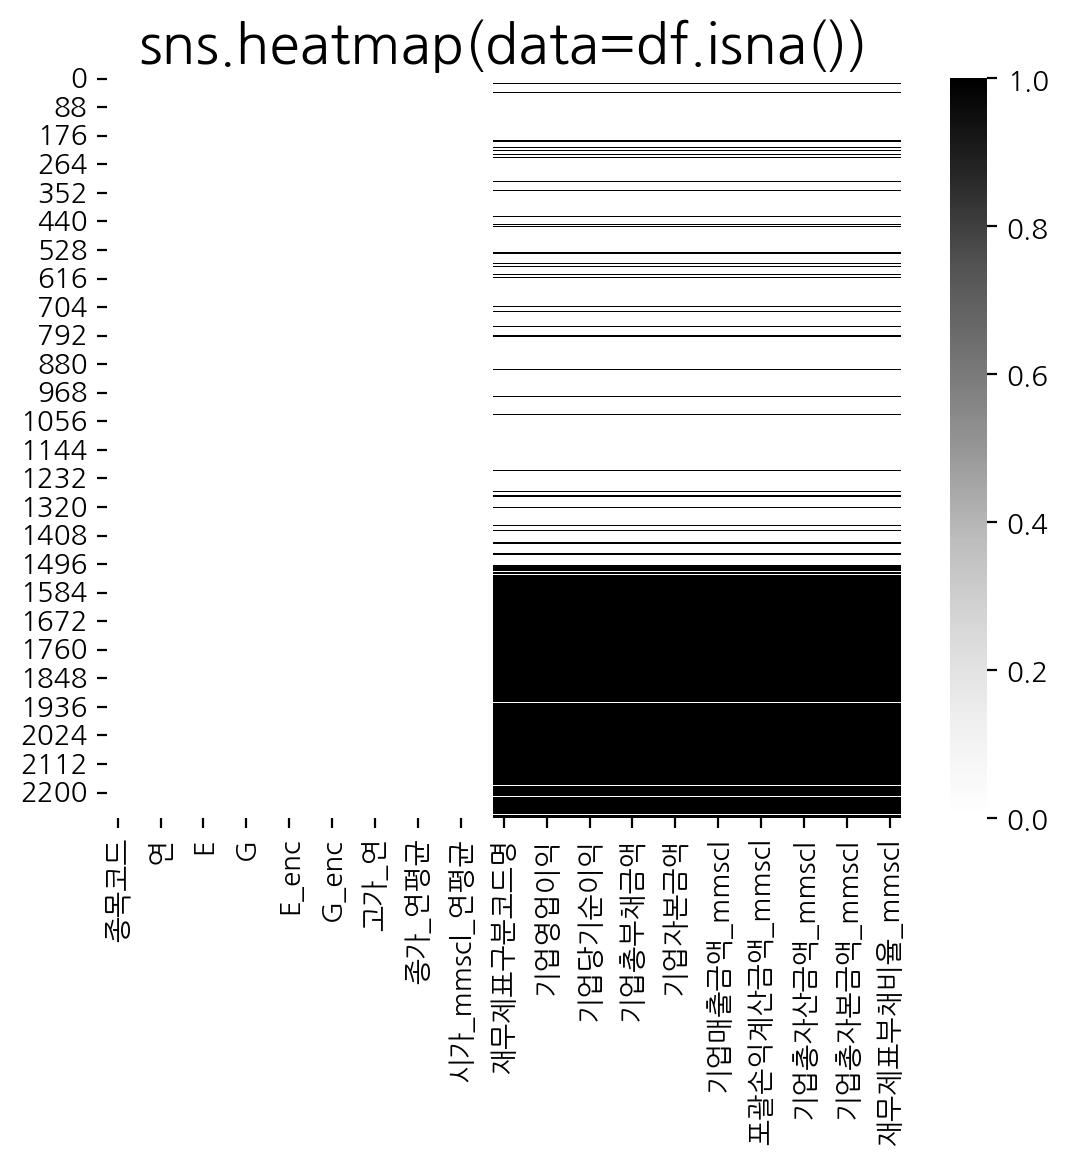



┌▣ df.isna().mean() ---- ---- ---- ----


0
종목코드            0.000000
종목명             0.000000
연               0.000000
ESG종합           0.000000
E               0.000000
S               0.000000
G               0.000000
ESG종합_enc       0.000000
E_enc           0.000000
S_enc           0.000000
G_enc           0.000000
시가_연평균          0.000000
고가_연            0.000000
저가_연            0.000000
종가_연평균          0.000000
거래량             0.000000
시가_mmscl_연평균    0.000000
종가_mmscl_연평균    0.000000
재무제표구분코드명       0.385426
기업매출금액          0.385426
기업영업이익          0.385426
포괄손익계산금액        0.385426
기업당기순이익         0.385426
기업총자산금액         0.385426
기업총부채금액         0.385426
기업총자본금액         0.385426
기업자본금액          0.385426
재무제표부채비율        0.385426
기업매출금액_mmscl    0.385426
기업영업이익_mmscl    0.385426
포괄손익계산금액_mmscl  0.385426
기업당기순이익_mmscl   0.385426
기업총자산금액_mmscl   0.385426
기업총부채금액_mmscl   0.385426
기업총자본금액_mmscl   0.385426
기업자본금액_mmscl    0.385426
재무제표부채비율_mmscl  0.385426

In [5]:
m.Summary_df(df)

## corr

ESG종합_enc     E_enc     S_enc     G_enc
연                0.037138 -0.053199  0.130679  0.143997
ESG종합_enc        1.000000  0.634152  0.831110  0.690215
E_enc            0.634152  1.000000  0.419896  0.256106
S_enc            0.831110  0.419896  1.000000  0.627543
G_enc            0.690215  0.256106  0.627543  1.000000
시가_연평균           0.095223 -0.069261  0.145862  0.094461
고가_연             0.084421 -0.074785  0.134339  0.084929
저가_연             0.098874 -0.061019  0.147280  0.097356
종가_연평균           0.094867 -0.069662  0.145928  0.094348
거래량              0.178899  0.152063  0.135757  0.147802
시가_mmscl_연평균     0.059899  0.039405  0.087924  0.055700
종가_mmscl_연평균     0.085990  0.059428  0.106343  0.063177
기업매출금액           0.355622  0.192842  0.324609  0.363276
기업영업이익           0.209337  0.109464  0.192744  0.195663
포괄손익계산금액         0.212119  0.113690  0.193713  0.189689
기업당기순이익          0.205110  0.108638  0.192474  0.184052
기업총자산금액          0.354745  0.202818  0.308323  0.368410
기업총부채금액          0.341770  0.208623  0.291555  0.376277
기업총자본금액          0.298090  0.160637  0.263009  0.294279
기업자본금액           0.260676  0.162080  0.228840  0.262254
재무제표부채비율         0.067858 -0.031529  0.031747  0.163418
기업매출금액_mmscl     0.028312  0.036265  0.037871  0.010951
기업영업이익_mmscl     0.010341  0.031188  0.033928  0.021346
포괄손익계산금액_mmscl   0.008412  0.033182  0.024337  0.011068
기업당기순이익_mmscl    0.009794  0.035330  0.027632  0.003268
기업총자산금액_mmscl    0.011646  0.020908  0.043134 -0.025267
기업총부채금액_mmscl    0.033145 -0.004176  0.037403  0.023545
기업총자본금액_mmscl   -0.031755  0.010434  0.020913 -0.040922
기업자본금액_mmscl     0.064073  0.072536  0.124486  0.041596
재무제표부채비율_mmscl   0.031263 -0.009768  0.010847  0.033194

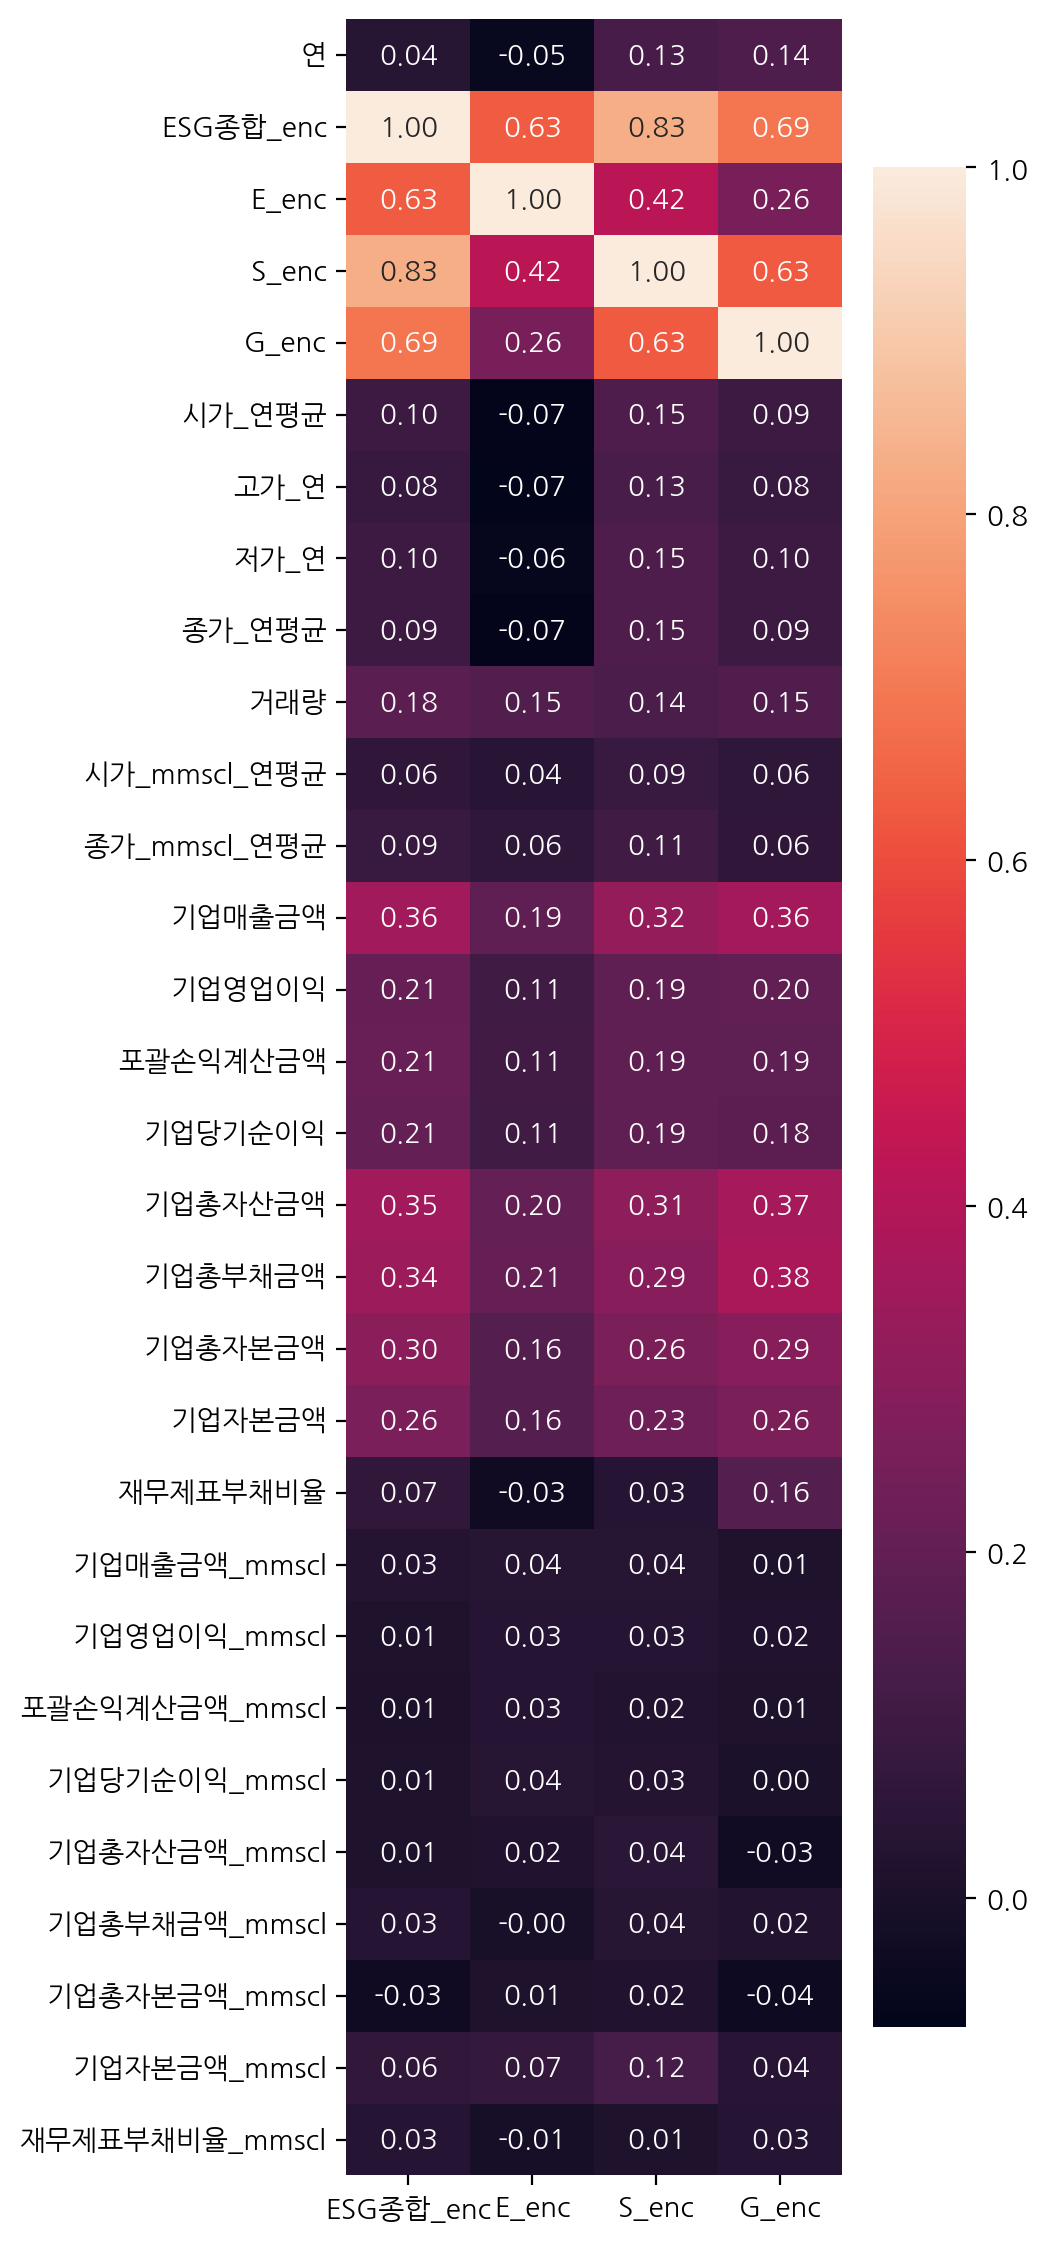

In [58]:
df_corr = df.copy()

egs_enc = ["ESG종합_enc", "E_enc", "S_enc", "G_enc"]
for i in egs_enc:
    df_corr[i] = df_corr[i].astype(str).astype(int)
    
display(df_corr.corr()[egs_enc])

plt.figure(figsize=(4, 14))
sns.heatmap(df_corr.corr()[egs_enc], annot=True, fmt=".2f", annot_kws={"size": 10}, )
plt.show()

## 종목수

In [6]:
list_esg = ['ESG종합', 'E', 'S', 'G']

for i in list_esg:
    display(df.pivot_table("종목코드", ["연"], [i], aggfunc='count').fillna(0))

ESG종합  S  A+   A  B+    B  C  D   N
연                                  
2011   0   7  28  27  101  0  0  19
2012   0   4  24  42  128  0  0   1
2013   0   5  18  54  122  0  0   0
2014   0   2  27  48  121  0  0   0
2015   0   1  31  81  247  0  0   0
2016   0   8  33  96  238  0  0   0
2017   0   7  39  94  240  0  0   0
2018   0  12  47  98  221  0  0   7

E     S  A+   A   B+    B    C   D  N
연                                    
2011  0   6  19   48   84   25   0  0
2012  0   6  14   59  100   20   0  0
2013  0   4  16   56   86   34   3  0
2014  0   7  18   57   81   34   1  0
2015  0   4  31   73  131  112   9  0
2016  0  19  19   70  158   92  17  0
2017  1   4  34  110  156   59  16  0
2018  0   9  27  123  149   65  12  0

S     S  A+   A   B+    B  C  D   N
연                                  
2011  0   7  28   23  105  0  0  19
2012  0  10  28   37  124  0  0   0
2013  0   8  28   43  120  0  0   0
2014  0   3  37   36  122  0  0   0
2015  0   7  37   87  229  0  0   0
2016  0  32  25  119  199  0  0   0
2017  0  35  46   90  209  0  0   0
2018  0  48  47  115  168  0  0   7

G     S  A+   A   B+    B  C  D   N
연                                  
2011  0   7  20   24   70  0  0  61
2012  0   8  18   60  112  0  0   1
2013  0   5  21   64  109  0  0   0
2014  0   6  27   57  108  0  0   0
2015  0   7  54  108  191  0  0   0
2016  0   3  72   94  206  0  0   0
2017  0   3  65  108  204  0  0   0
2018  0   7  59  111  201  0  0   7

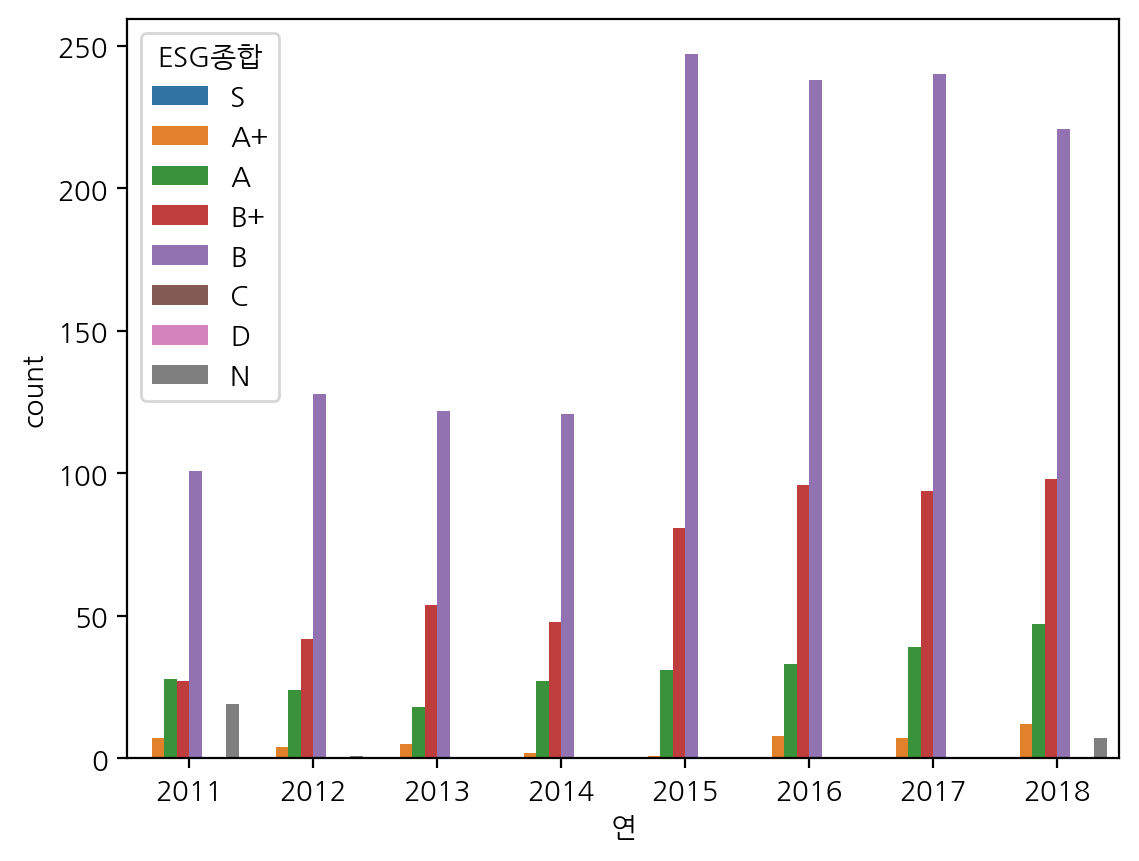

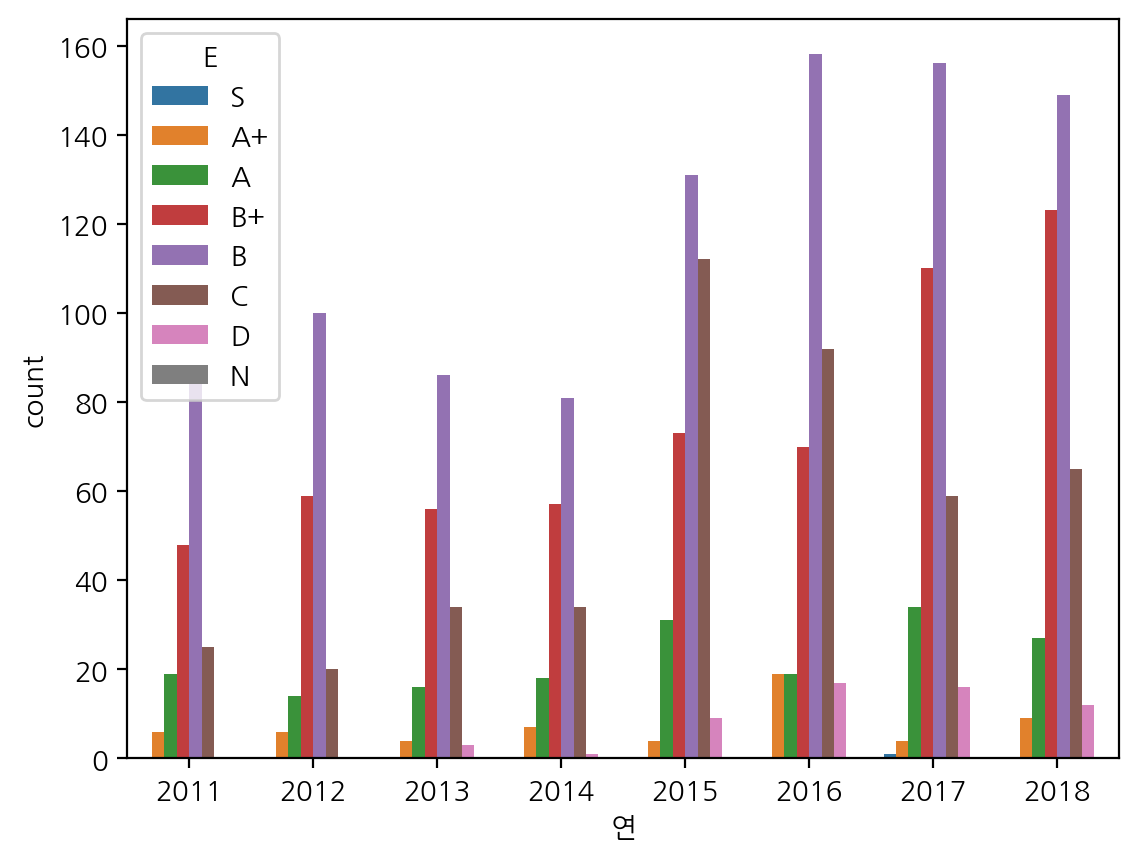

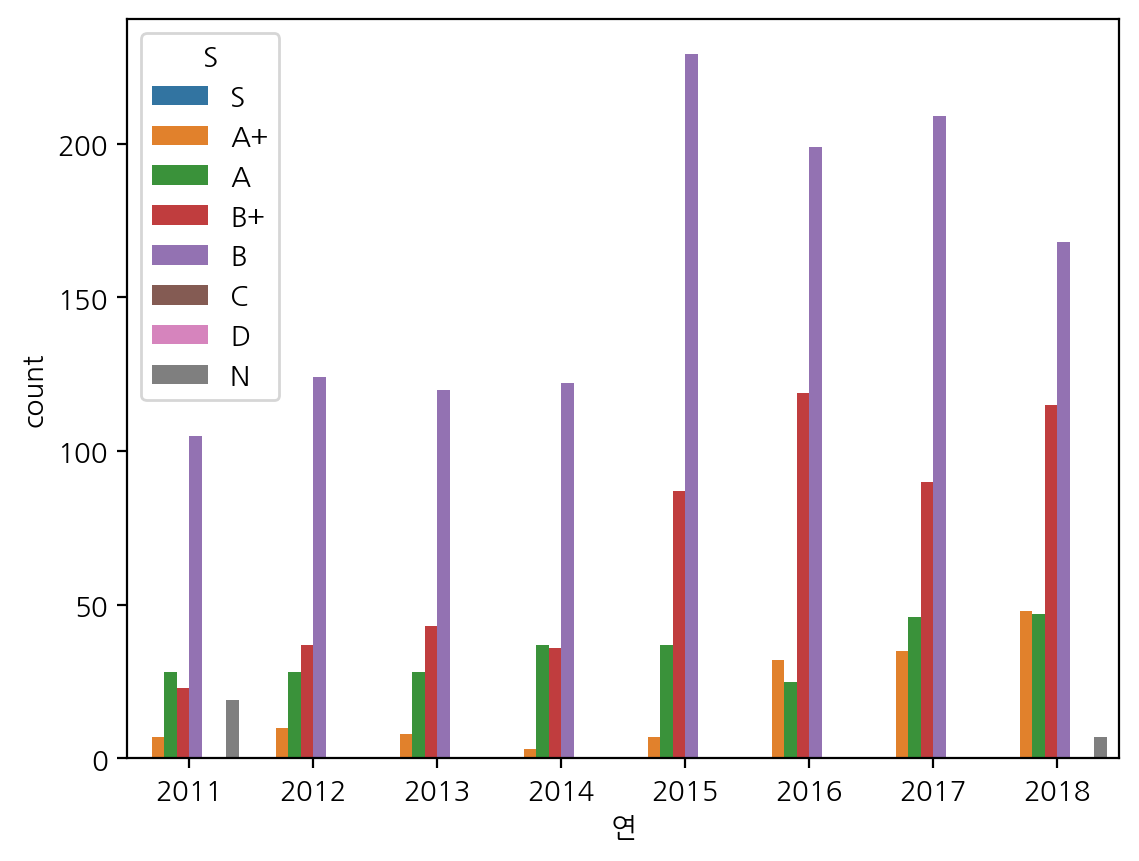

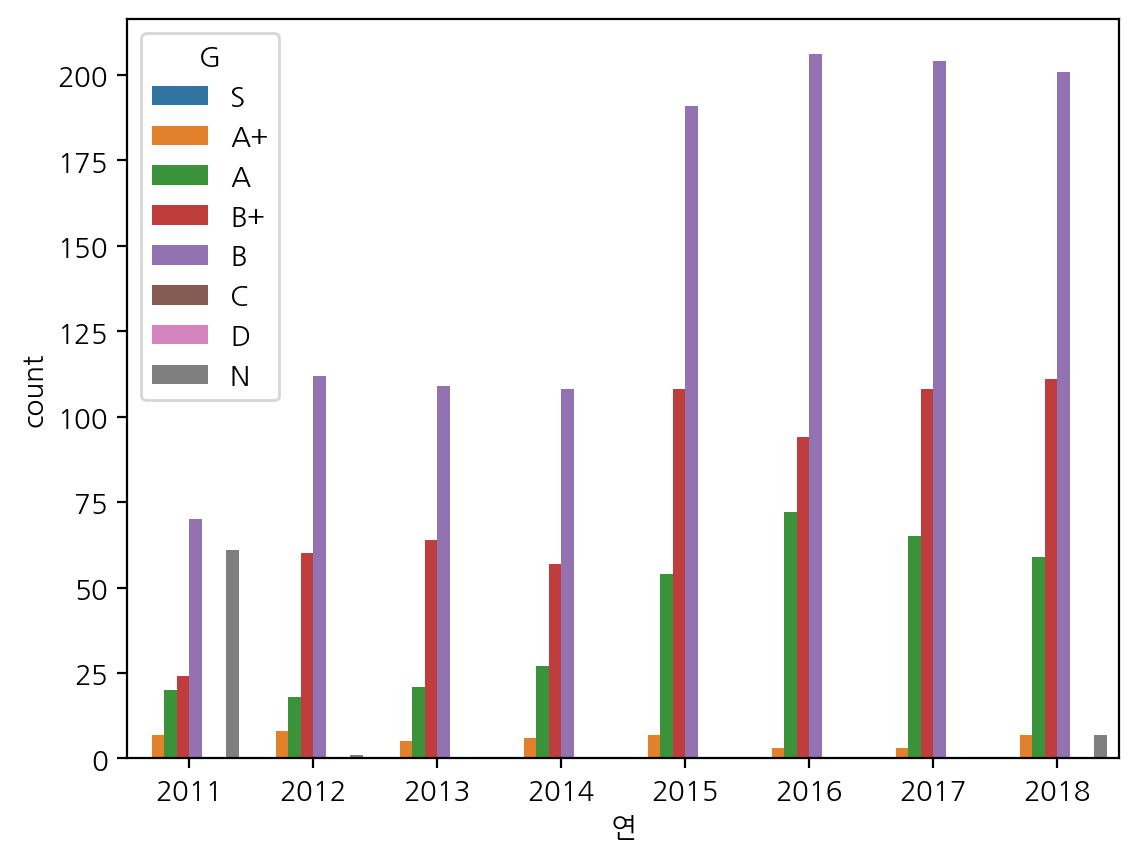

In [7]:
for i in list_esg:
    sns.countplot(df, x="연", hue=i)
    plt.show()

## 종가_연평균


ESG종합


ESG종합             A+              A             B+             B  \
연                                                                  
2011   100427.296083  281719.707661  121570.304809  57434.232154   
2012    68224.561492  124201.552251  154878.340534  57171.704511   
2013    71139.811336  113117.221997   85997.215625  79918.873664   
2014    57474.489796  111504.328042   81980.255995  73625.487536   
2015    42013.911290  134050.102888  102426.583234  91712.286829   
2016    78103.379065  167430.333457   72241.668360  91601.452501   
2017   136250.499706  170796.173895   69938.458016  87607.578189   
2018   113468.200820  167116.715295   97250.281867  77388.280988   

ESG종합              N  
연                     
2011   113604.190153  
2012    24503.024194  
2013             NaN  
2014             NaN  
2015             NaN  
2016             NaN  
2017             NaN  
2018    29730.907494

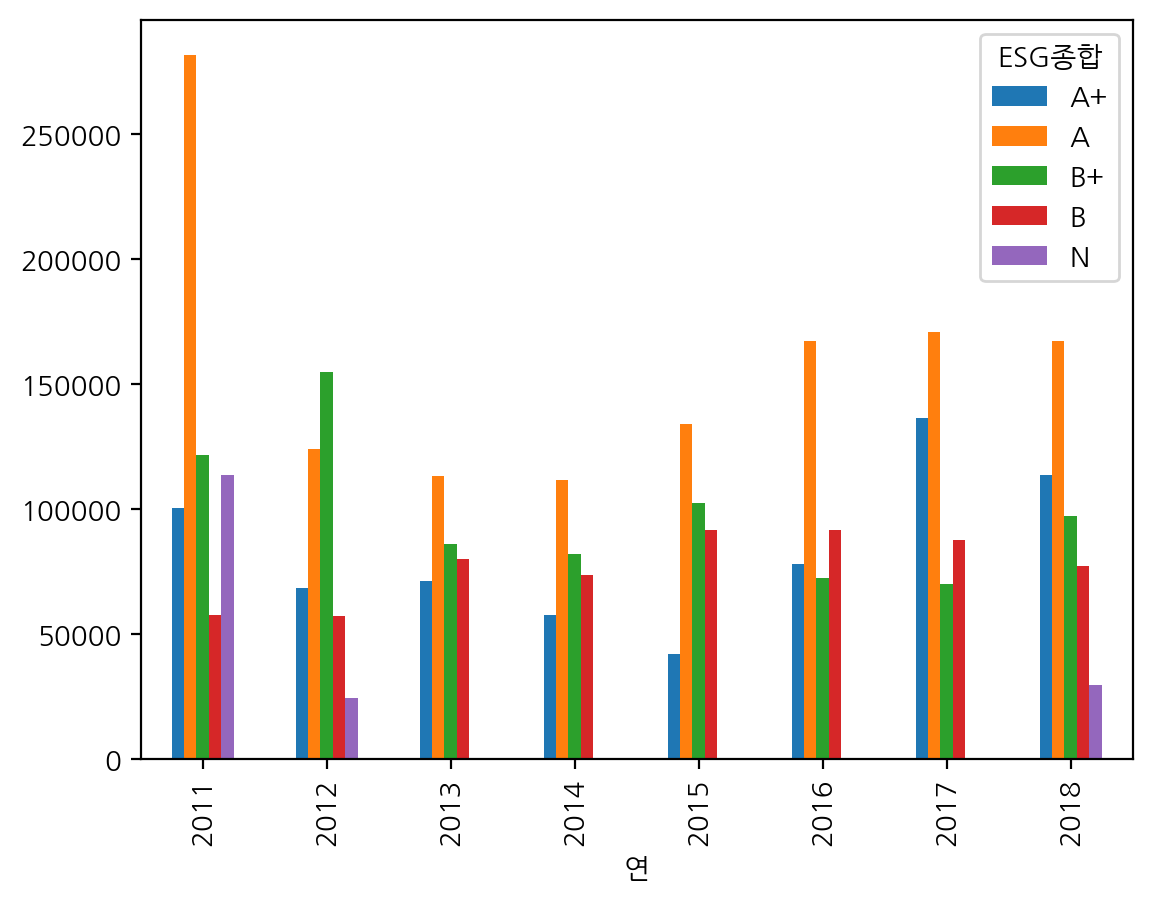


E


E                S             A+              A             B+  \
연                                                                 
2011           NaN   73398.607527   79050.864601  135738.926831   
2012           NaN   43659.391801   91725.885945   90579.361468   
2013           NaN   55583.569838   58168.712551   88150.039980   
2014           NaN   37136.296210   81759.716553   93552.415038   
2015           NaN   33128.896169   78904.757024   90351.452331   
2016           NaN   68494.717801   69268.738982  115161.819222   
2017  49094.238683  183698.765432   73510.278746   94526.465507   
2018           NaN  113862.396175  100131.735276   95275.292383   

E                 B              C              D  
연                                                  
2011  116578.130904   63299.544839            NaN  
2012   77790.301169  121588.790323            NaN  
2013   62847.991197  122872.209812  371247.662618  
2014   44605.124339  155422.874190    7792.693878  
2015   68219.222144  148614.783446   43473.585573  
2016   56067.477591   84008.301873  448242.096365  
2017   70197.099399  144772.631234  127584.710391  
2018   72916.990786  135059.129319   80575.307377

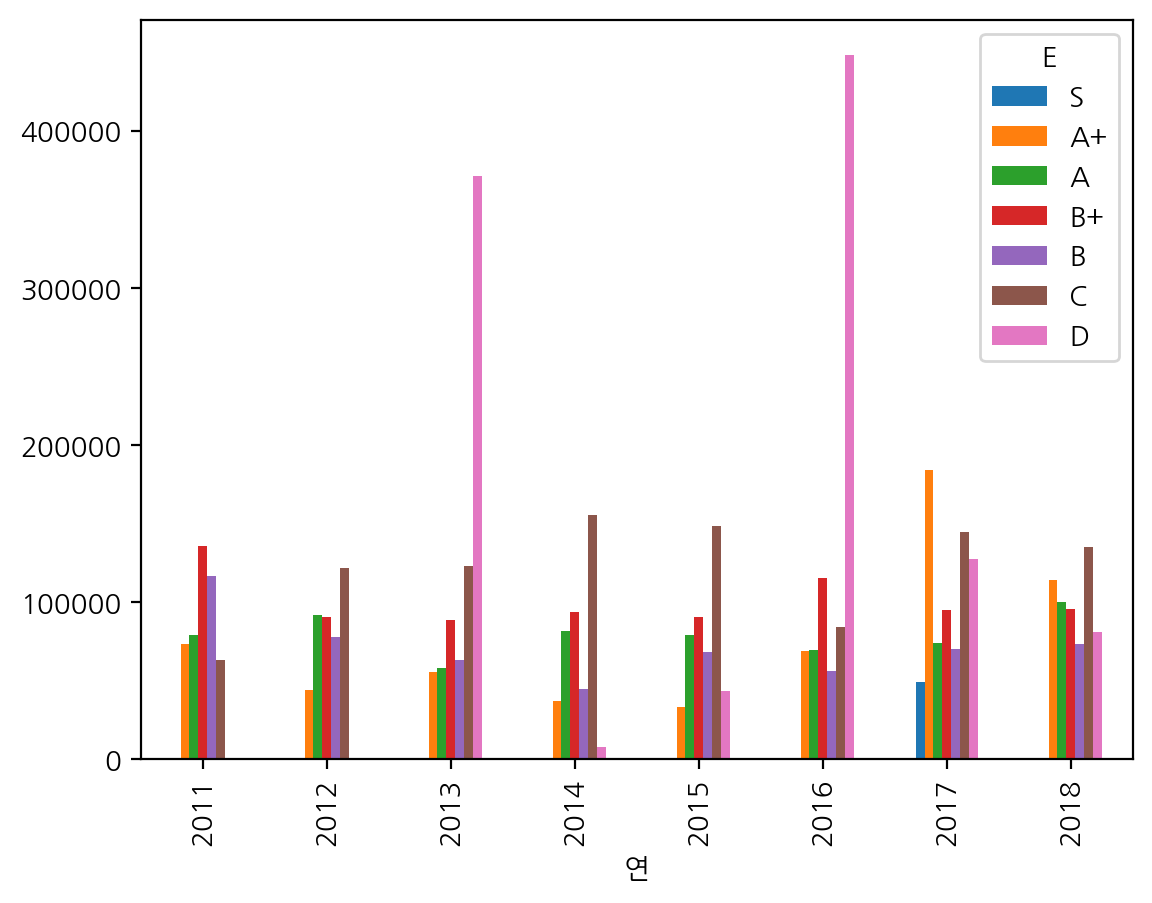


S


S                A+              A             B+             B              N
연                                                                             
2011  100427.296083  281719.707661  136825.182854  56535.966398  113604.190153
2012  161414.294758   77916.000576  154887.288797  61084.567378            NaN
2013  133160.829960   93227.126374  130993.677808  62311.557996            NaN
2014   63894.081633  109386.542581   79118.127551  72803.813148            NaN
2015  320431.750000  107535.920227   89662.108593  92247.163509            NaN
2016  172626.369411  107645.489756  115529.834426  64940.414736            NaN
2017  193552.206937  112716.601002   97848.380613  69134.894520            NaN
2018  197308.086663  131054.486571   64959.747648  75885.248463   29730.907494

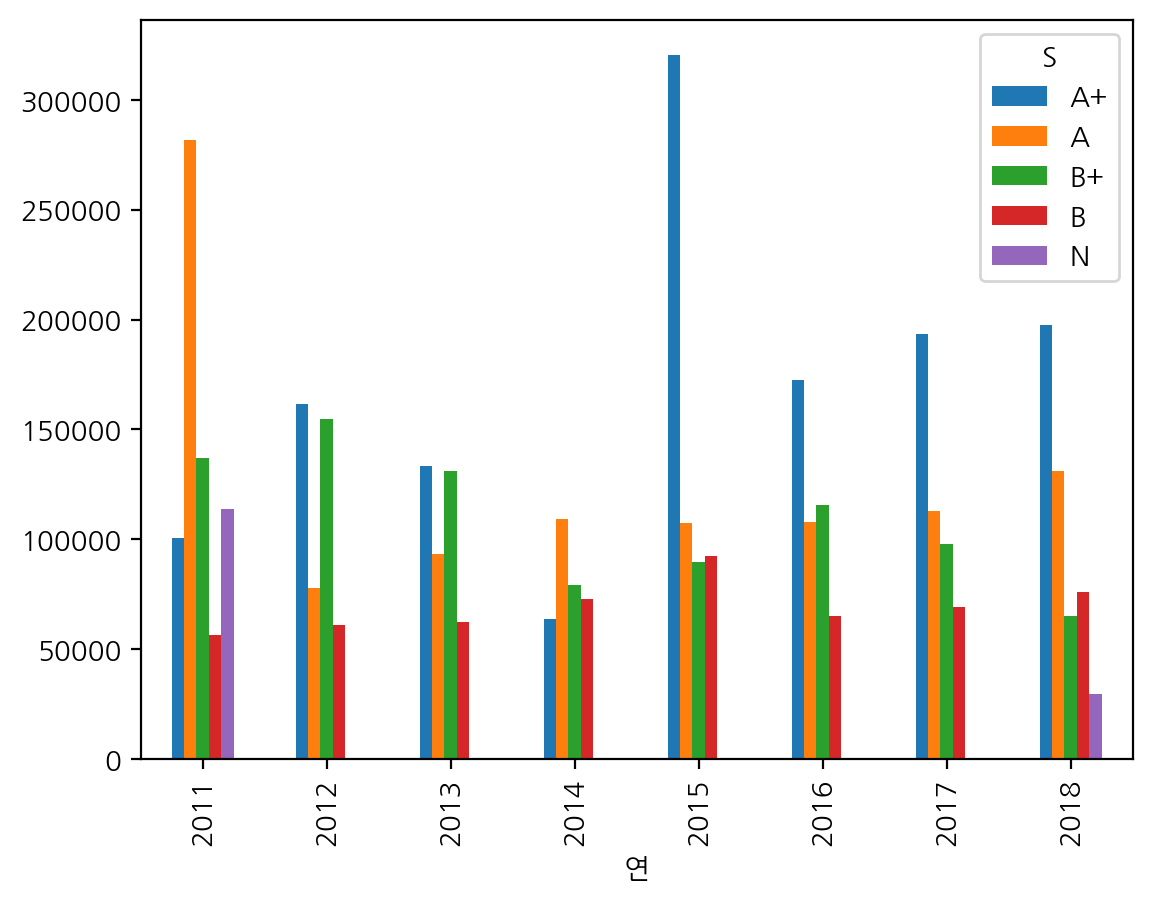


G


G                A+              A             B+             B             N
연                                                                            
2011   71149.410138  163703.562903  301088.654234  76848.671313  56643.054997
2012  100307.859879  134356.232079  130416.183804  53846.052635  24503.024194
2013   93635.155466  118197.663775  136326.357794  46885.758422           NaN
2014  127753.182313  103275.627589   98233.300179  63102.249698           NaN
2015  119135.557604  115662.044504  111001.232826  84184.412240           NaN
2016   48620.257453  123129.154810   61770.978464  97421.077670           NaN
2017   72986.145405  142873.914783   78676.155502  84372.796115           NaN
2018   87415.351288  146781.143304   90858.159836  82050.701962  29730.907494

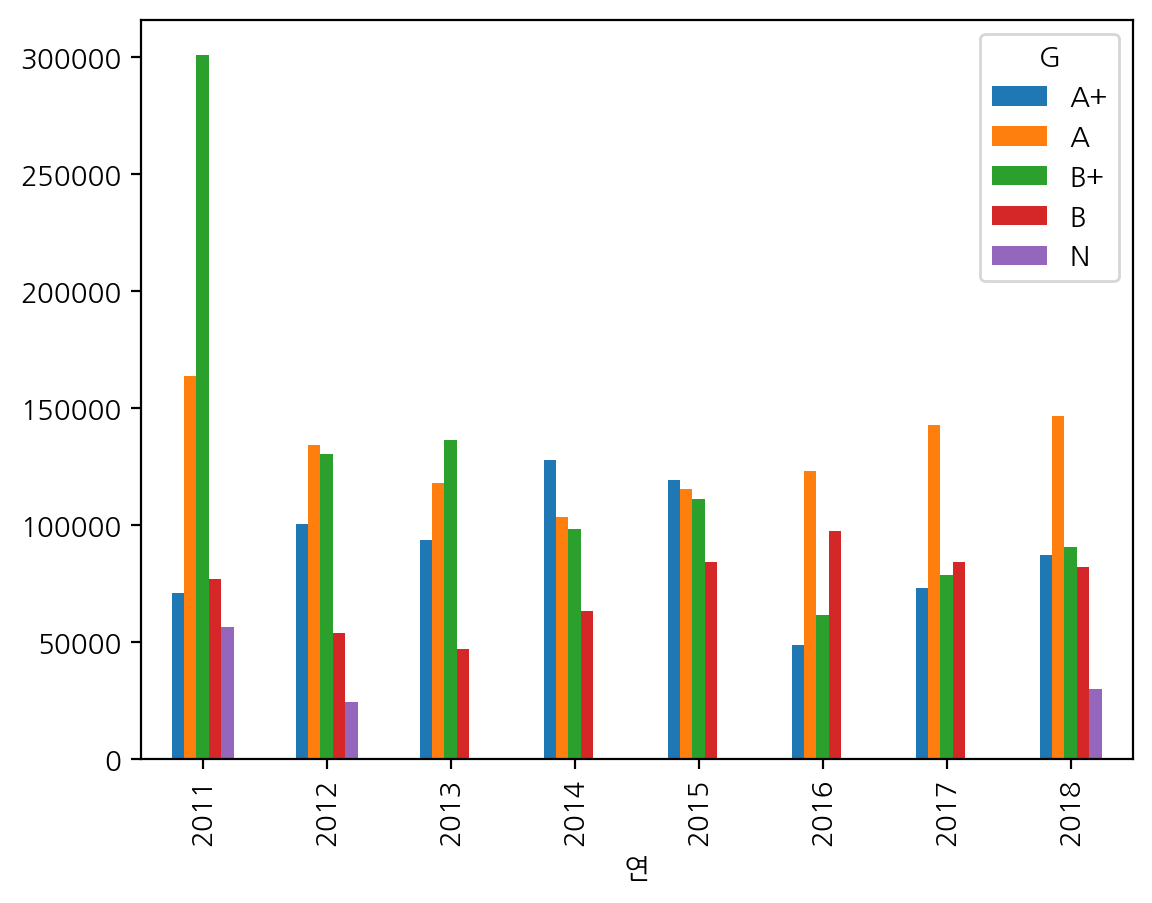

In [21]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table(["종가_연평균"], ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar")
    plt.show()
    print("---------- " * 8)

## 종가_mmscl_연평균


ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011   0.445609  0.486694  0.364339  0.272600  0.312829
2012   0.380325  0.341489  0.321761  0.248812  0.295898
2013   0.388379  0.298859  0.338062  0.302061       NaN
2014   0.145020  0.392212  0.346892  0.350199       NaN
2015   0.392822  0.341277  0.402202  0.446901       NaN
2016   0.283188  0.456021  0.312018  0.409024       NaN
2017   0.564453  0.478094  0.400544  0.382778       NaN
2018   0.595052  0.454829  0.371047  0.358996  0.257917

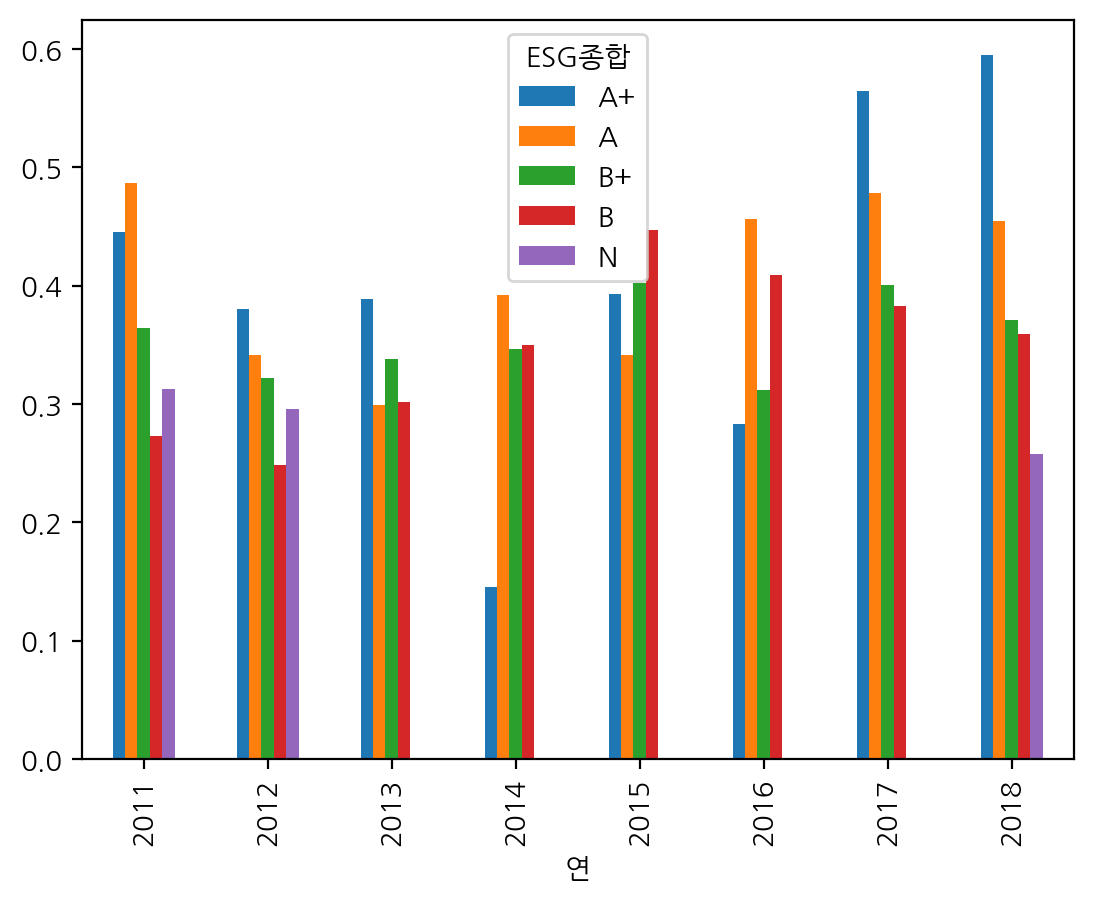

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

E


E            S        A+         A        B+         B         C         D
연                                                                         
2011       NaN  0.451152  0.389665  0.418920  0.284386  0.238123       NaN
2012       NaN  0.370494  0.371259  0.331962  0.228416  0.276344       NaN
2013       NaN  0.426697  0.383583  0.305283  0.325075  0.261500  0.213603
2014       NaN  0.490949  0.371141  0.335032  0.354752  0.342485  0.311279
2015       NaN  0.397827  0.401501  0.419614  0.447447  0.419058  0.412842
2016       NaN  0.305442  0.348864  0.412429  0.380365  0.389054  0.436656
2017  0.713867  0.626709  0.485129  0.374211  0.402485  0.379337  0.379242
2018       NaN  0.687066  0.414178  0.383096  0.353354  0.371426  0.395345

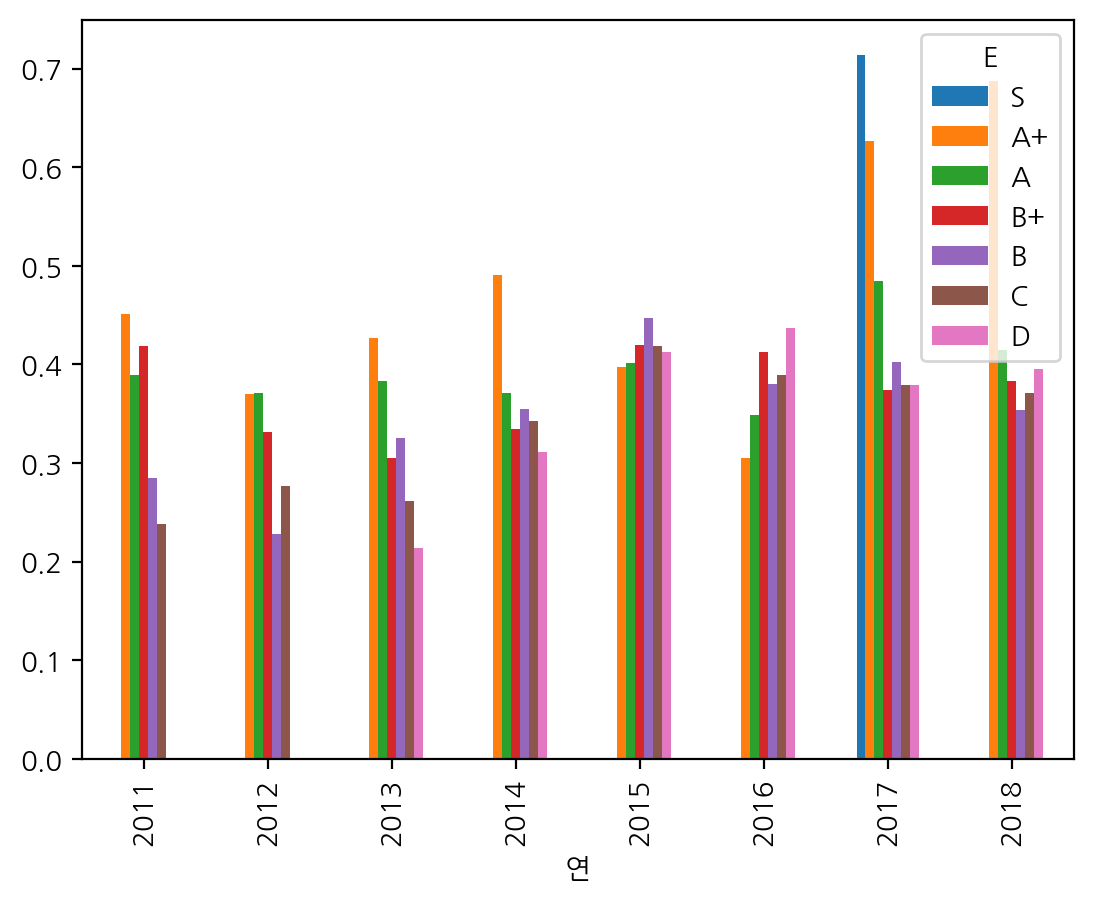

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

S


S           A+         A        B+         B         N
연                                                     
2011  0.445609  0.486694  0.382648  0.272084  0.312829
2012  0.371283  0.346497  0.291051  0.251542       NaN
2013  0.278740  0.350386  0.353990  0.293049       NaN
2014  0.296102  0.355597  0.395903  0.341039       NaN
2015  0.323172  0.372357  0.394746  0.452197       NaN
2016  0.372829  0.347268  0.370665  0.401479       NaN
2017  0.429905  0.533047  0.384964  0.372732       NaN
2018  0.470703  0.420997  0.404041  0.329601  0.257917

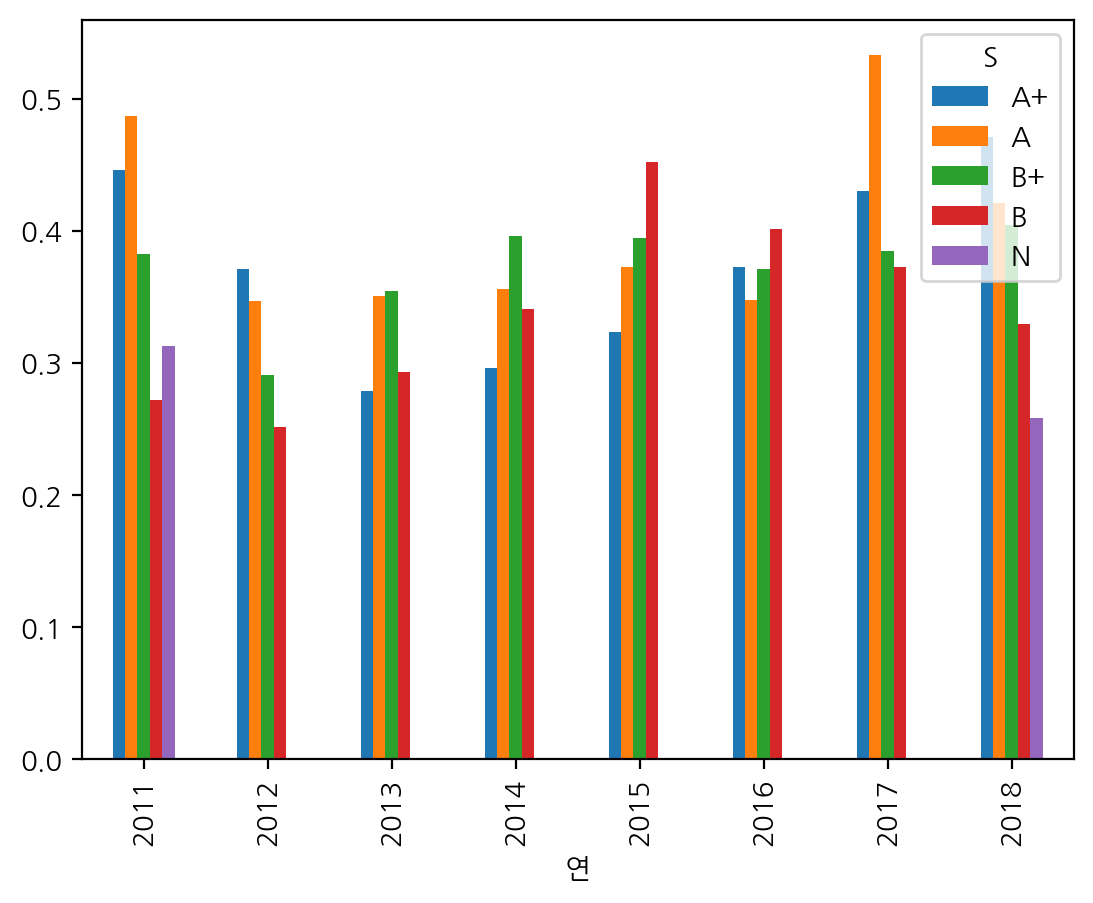

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

G


G           A+         A        B+         B         N
연                                                     
2011  0.364772  0.492572  0.431543  0.318120  0.246392
2012  0.398933  0.309570  0.299733  0.252957  0.295898
2013  0.399170  0.305173  0.316949  0.309532       NaN
2014  0.275004  0.408086  0.306508  0.368198       NaN
2015  0.292550  0.350835  0.413110  0.462443       NaN
2016  0.181071  0.342545  0.366829  0.412268       NaN
2017  0.481445  0.460863  0.370299  0.395695       NaN
2018  0.506906  0.439302  0.379235  0.361473  0.257917

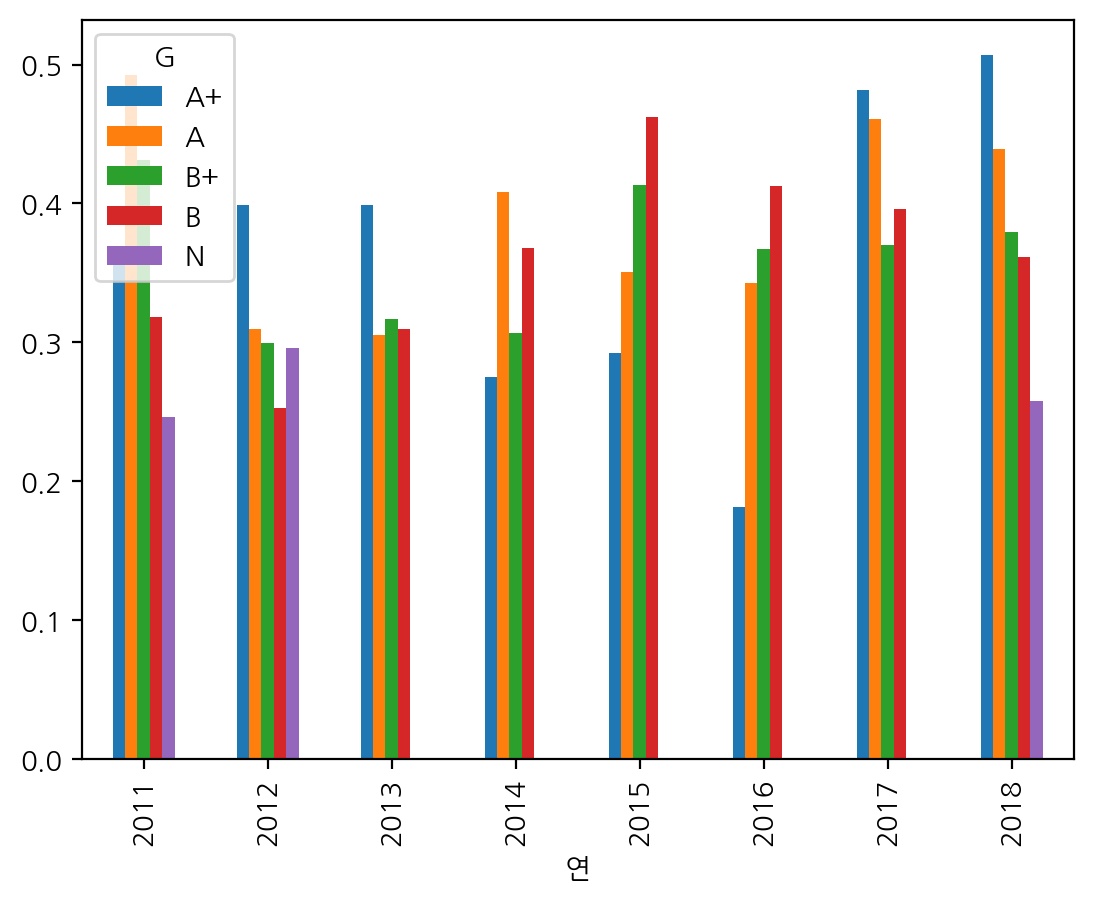

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [59]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table("종가_mmscl_연평균", ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar")
    plt.show()
    print("---------- " * 8)

## 거래량


ESG종합


거래량                                                        
ESG종합            A+             A            B+             B             N
연                                                                          
2011  -6.209786e+07  1.207110e+08  1.304585e+08  8.998987e+07  4.755382e+07
2012   4.952337e+08  1.218492e+08  8.905956e+07  6.108667e+07  9.458772e+07
2013   1.452573e+08  1.608267e+08  5.118222e+07  5.462644e+07           NaN
2014   9.774480e+07  1.136216e+08  1.031706e+08  4.113165e+07           NaN
2015   2.403083e+08  9.769585e+07  1.390258e+08  7.189665e+07           NaN
2016   1.321558e+08  7.913563e+07  1.134830e+08  4.390703e+07           NaN
2017   1.113857e+08  1.874863e+08  9.126459e+07  6.186806e+07           NaN
2018   1.382788e+08  2.692862e+08  1.233882e+08  5.622734e+07  4.297317e+07

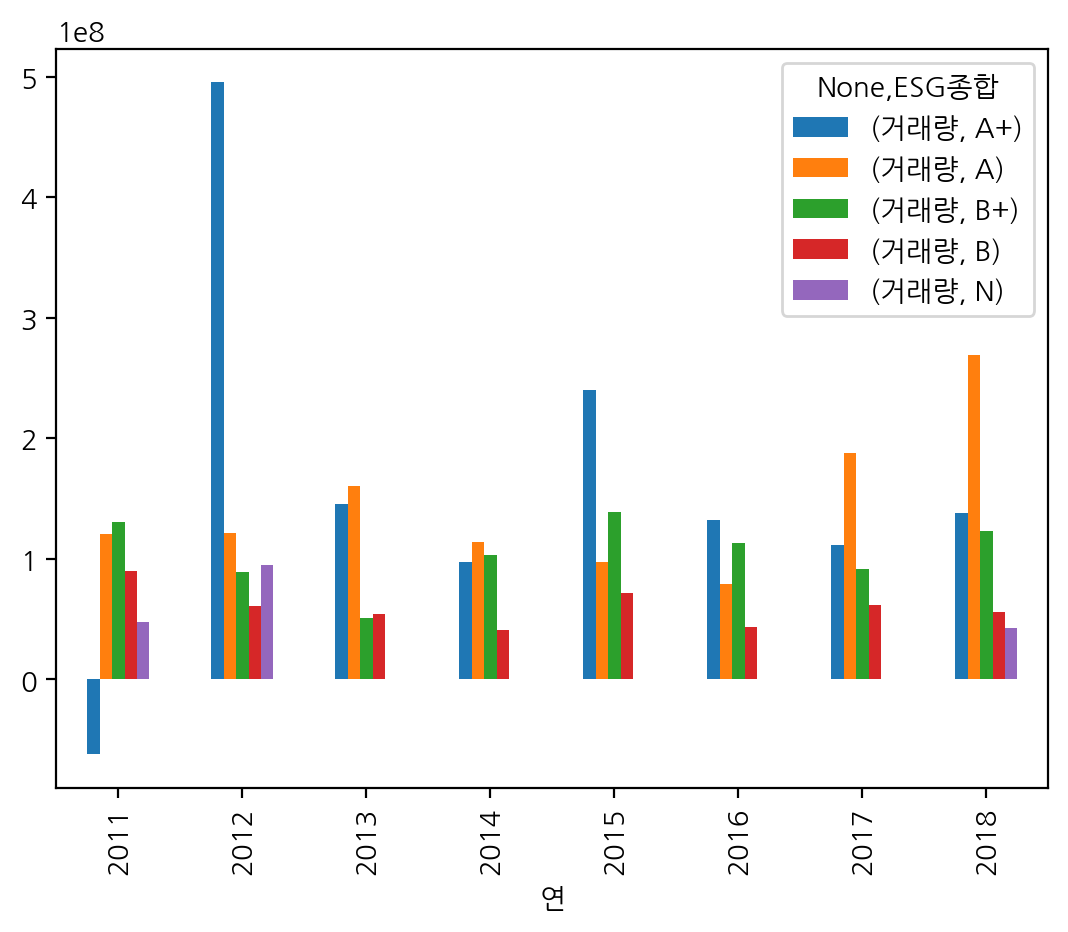

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

E


거래량                                                          \
E               S            A+             A            B+             B   
연                                                                           
2011          NaN -9.411088e+07  1.653979e+08  1.219225e+08  7.205440e+07   
2012          NaN  4.278055e+08  1.028941e+08  9.951638e+07  5.808062e+07   
2013          NaN  1.988781e+08  1.137201e+08  9.855826e+07  3.537644e+07   
2014          NaN  1.327792e+08  1.035348e+08  7.304327e+07  5.773736e+07   
2015          NaN  2.050610e+08  1.058623e+08  1.300878e+08  8.969872e+07   
2016          NaN  1.229816e+08  1.747722e+08  7.997805e+07  4.564691e+07   
2017  242632403.0  4.979132e+07  1.465953e+08  1.165961e+08  4.861764e+07   
2018          NaN  1.576820e+08  1.229368e+08  1.569637e+08  7.860944e+07   

                                  
E                C             D  
연                                 
2011  7.909431e+07           NaN  
2012  4.363100e+07           NaN  
2013  5.261253e+07  2.797840e+07  
2014  3.884224e+07  2.384805e+08  
2015  4.732402e+07  1.821375e+08  
2016  6.383515e+07  3.953699e+07  
2017  8.695397e+07  3.453935e+07  
2018  4.683112e+07  2.775826e+07

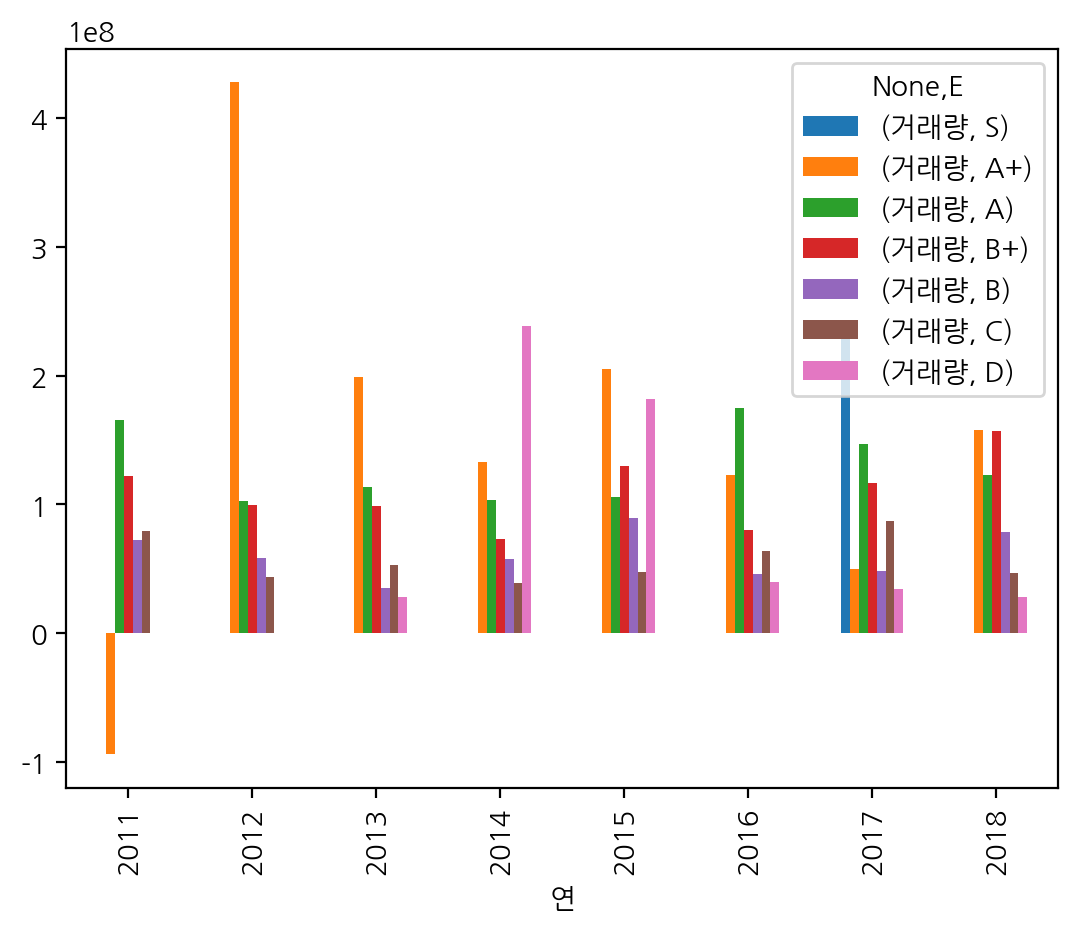

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

S


거래량                                                        
S               A+             A            B+             B             N
연                                                                         
2011 -6.209786e+07  1.207110e+08  1.500055e+08  8.724980e+07  4.755382e+07
2012  2.618618e+08  1.235372e+08  8.276385e+07  5.983529e+07           NaN
2013  2.494382e+08  1.042041e+08  2.425135e+07  5.911170e+07           NaN
2014  7.915490e+07  1.174304e+08  9.509443e+07  4.251311e+07           NaN
2015  8.185979e+07  1.020225e+08  1.409882e+08  6.844812e+07           NaN
2016  7.798920e+07  1.198843e+08  9.224492e+07  4.292991e+07           NaN
2017  8.187643e+07  1.574308e+08  8.251774e+07  6.691283e+07           NaN
2018  1.580269e+08  1.896095e+08  7.129772e+07  8.415423e+07  4.297317e+07

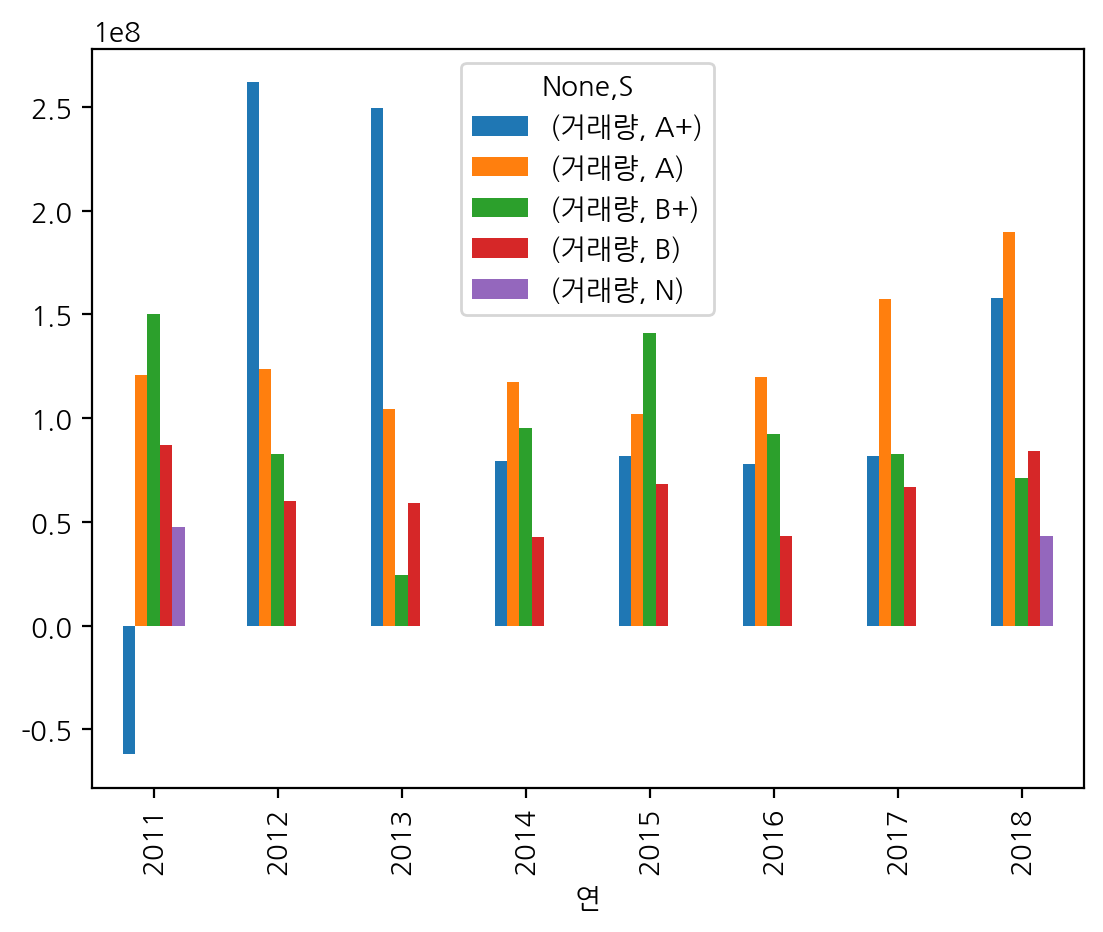

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 

G


거래량                                                        
G               A+             A            B+             B             N
연                                                                         
2011 -1.503151e+08  1.619606e+08  1.487628e+08  8.641643e+07  7.628919e+07
2012  2.932442e+08  8.774304e+07  7.901927e+07  6.962881e+07  9.458772e+07
2013  1.100212e+08  1.407022e+08  3.588520e+07  6.649474e+07           NaN
2014  7.723575e+07  1.325698e+08  6.381008e+07  5.104089e+07           NaN
2015  6.823931e+07  1.455495e+08  8.575767e+07  7.690717e+07           NaN
2016  1.365771e+08  1.065749e+08  8.864152e+07  4.173559e+07           NaN
2017  1.935114e+08  1.539606e+08  8.762498e+07  5.621275e+07           NaN
2018  1.203891e+08  2.536881e+08  1.063143e+08  5.583518e+07  4.297317e+07

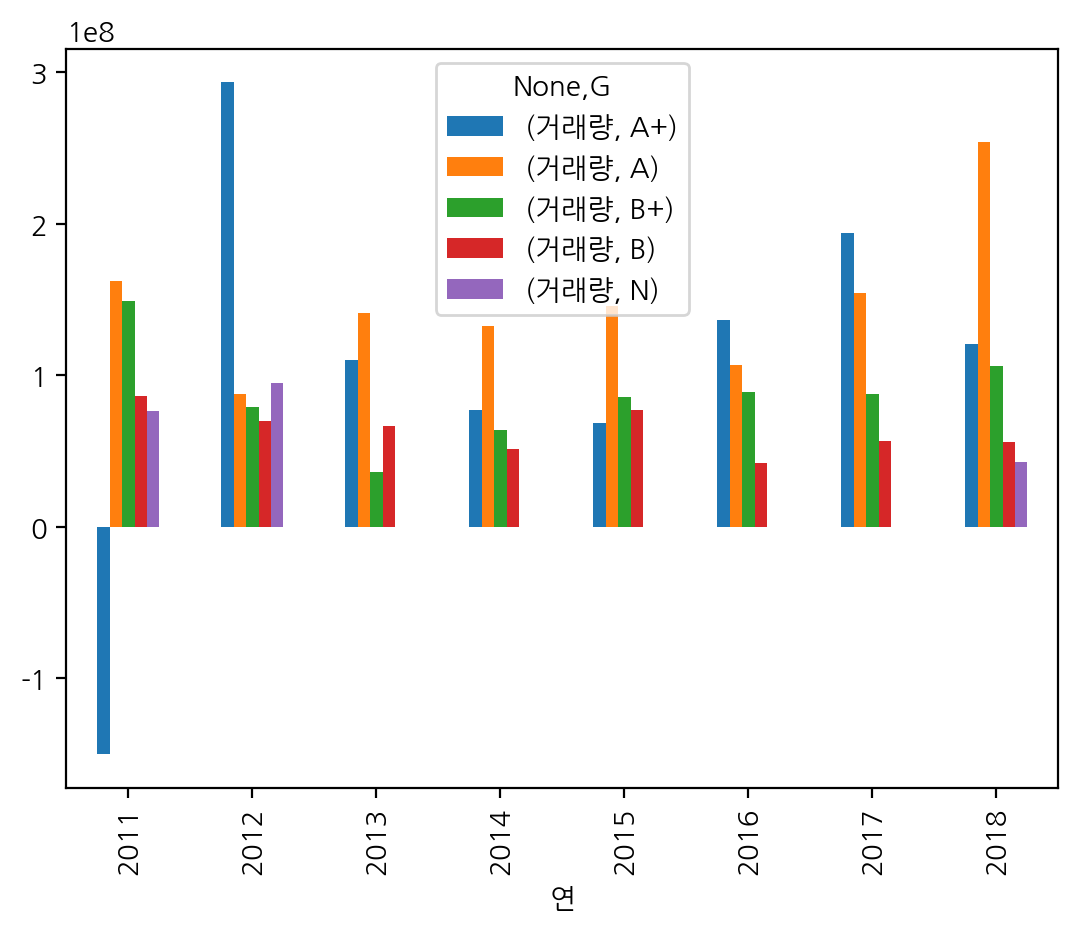

---------- ---------- ---------- ---------- ---------- ---------- ---------- ---------- 


In [30]:
for i in list_esg:
    print()
    print(i)

    d = df.pivot_table(["거래량"], ["연"], [i], aggfunc="mean")
    display(d)

    d.plot(kind="bar")
    plt.show()
    print("---------- " * 8)

## finaStat


기업매출금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  1.017339e+12  4.245284e+11           NaN
2012            NaN           NaN  9.872760e+11  4.728765e+11           NaN
2013            NaN           NaN           NaN  3.990871e+11           NaN
2014            NaN           NaN  3.905572e+12  7.432375e+11           NaN
2015            NaN  2.282318e+13  8.575496e+12  2.102933e+12           NaN
2016   1.524522e+13  2.558153e+13  7.818947e+12  1.486770e+12           NaN
2017   2.448677e+13  1.386676e+13  1.085163e+13  1.864159e+12           NaN
2018   2.945865e+13  2.137615e+13  5.657982e+12  1.553729e+12  1.277464e+12

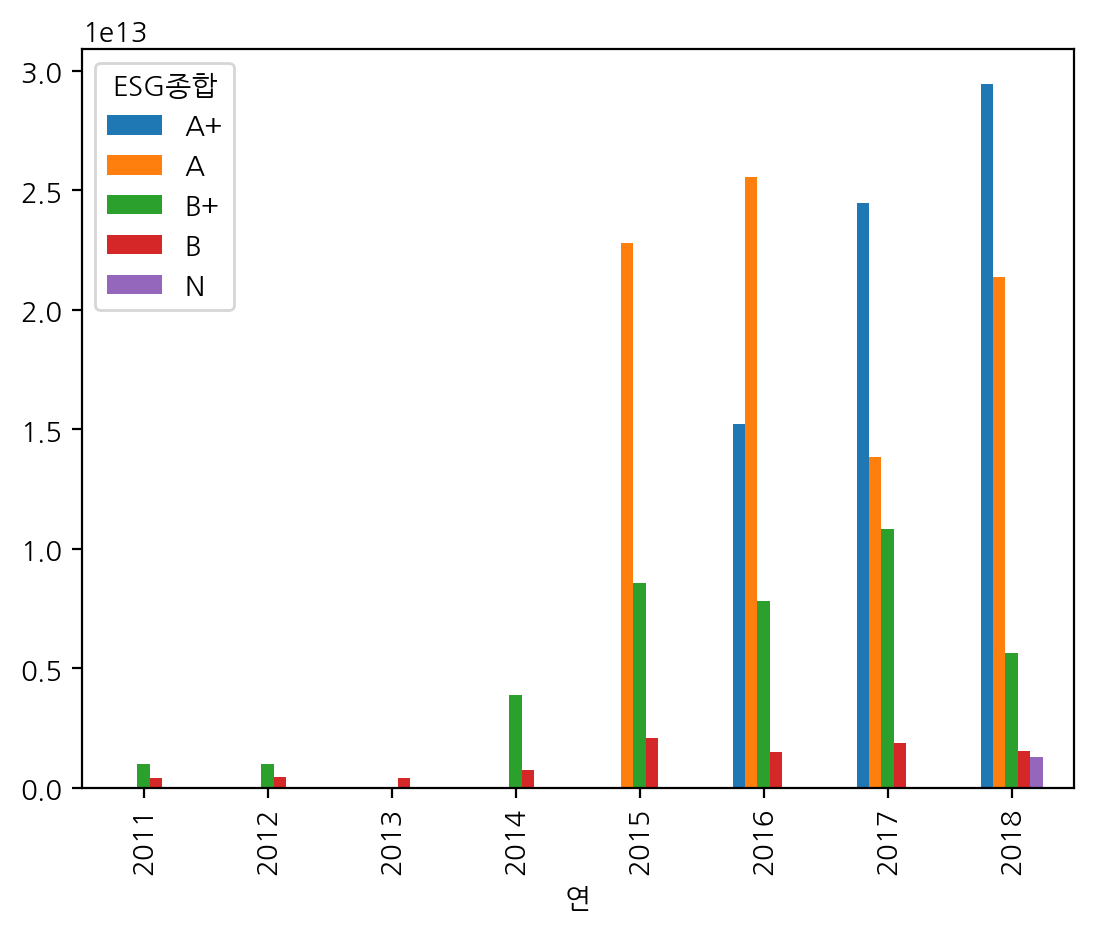

---------- ---------- ---------- ---------- ---------- 

기업매출금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  5.846464e+11  3.768670e+11   
2012           NaN           NaN           NaN  6.921805e+11  5.486680e+11   
2013           NaN           NaN           NaN  4.056326e+09  5.966025e+11   
2014           NaN           NaN  3.905572e+12           NaN  7.432375e+11   
2015           NaN  7.626967e+12  1.167699e+13  2.754092e+12  3.202655e+12   
2016  1.652395e+13  1.279448e+13  1.041572e+13  2.748410e+12  3.251218e+12   
2017  3.376977e+13  1.287584e+13  5.281394e+12  5.103495e+12  2.518989e+12   
2018  3.061341e+13  1.145332e+13  1.012634e+13  2.288436e+12  1.987741e+12   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  6.786939e+12  
2016  2.404959e+12  
2017  3.777998e+12  
2018  1.005295e+12

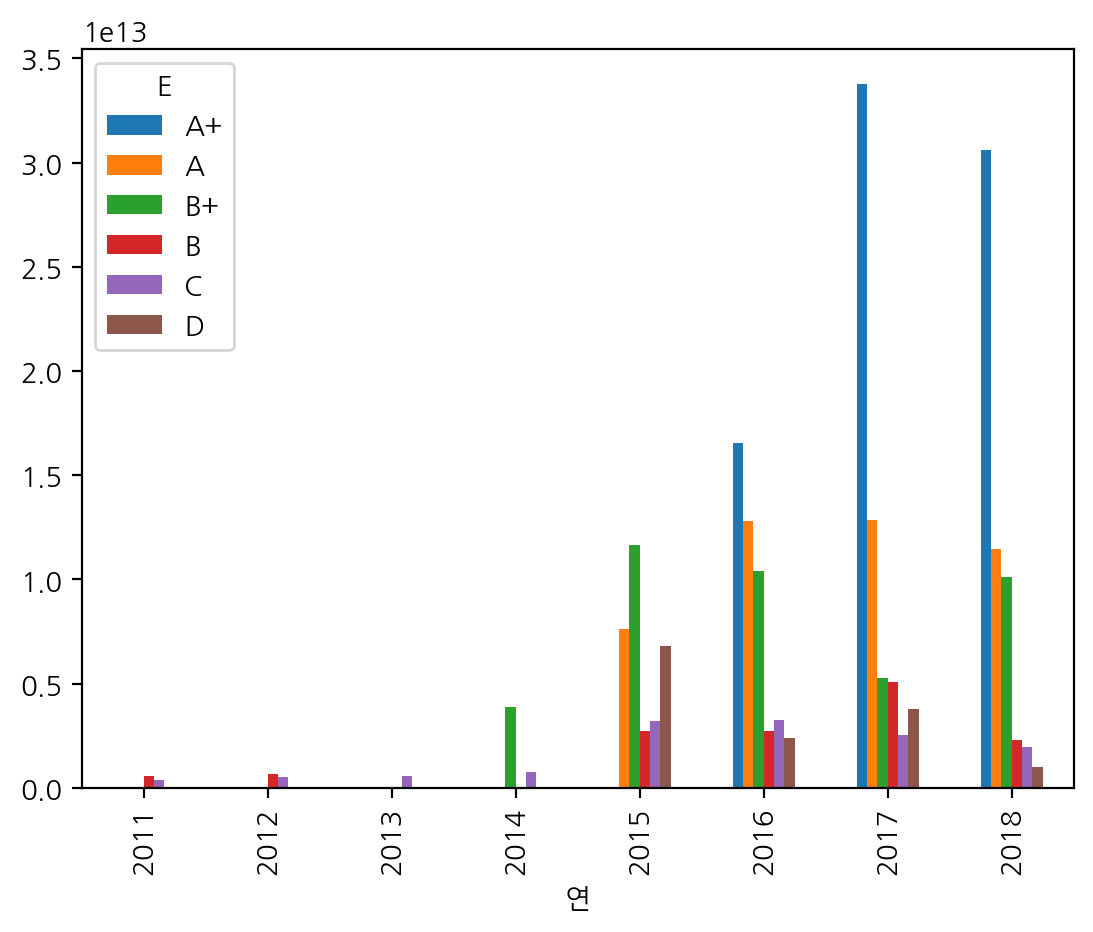

---------- ---------- ---------- ---------- ---------- 

기업매출금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  1.017339e+12  4.245284e+11           NaN
2012           NaN           NaN  9.872760e+11  4.728765e+11           NaN
2013           NaN           NaN           NaN  3.990871e+11           NaN
2014           NaN           NaN           NaN  1.375704e+12           NaN
2015  1.072094e+13  1.064175e+13  1.219649e+13  1.719033e+12           NaN
2016  2.482135e+13  9.210617e+12  5.120641e+12  1.631812e+12           NaN
2017  1.280430e+13  2.402223e+13  4.180031e+12  1.423801e+12           NaN
2018  1.485344e+13  2.153351e+13  2.243384e+12  1.507057e+12  1.277464e+12

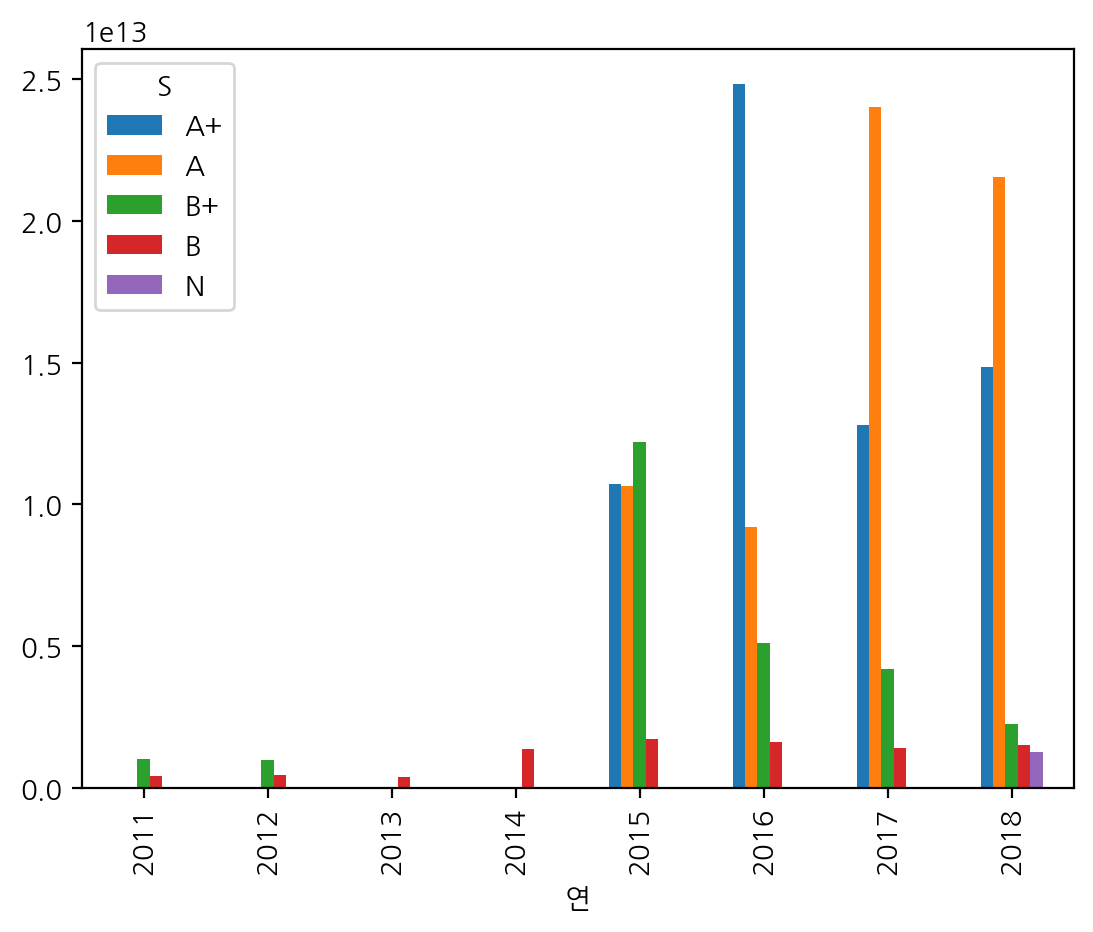

---------- ---------- ---------- ---------- ---------- 

기업매출금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  1.017339e+12  4.039370e+11  4.451197e+11
2012           NaN           NaN  9.872760e+11  4.728765e+11           NaN
2013           NaN           NaN           NaN  3.990871e+11           NaN
2014           NaN           NaN  2.030990e+12  3.927765e+11           NaN
2015  6.171555e+13  1.357929e+13  4.093450e+12  1.255524e+12           NaN
2016  5.361689e+12  1.743297e+13  3.691442e+12  1.425709e+12           NaN
2017  5.920758e+12  2.120301e+13  3.362998e+12  1.744559e+12           NaN
2018  1.427290e+13  2.132082e+13  5.484008e+12  1.316869e+12  1.277464e+12

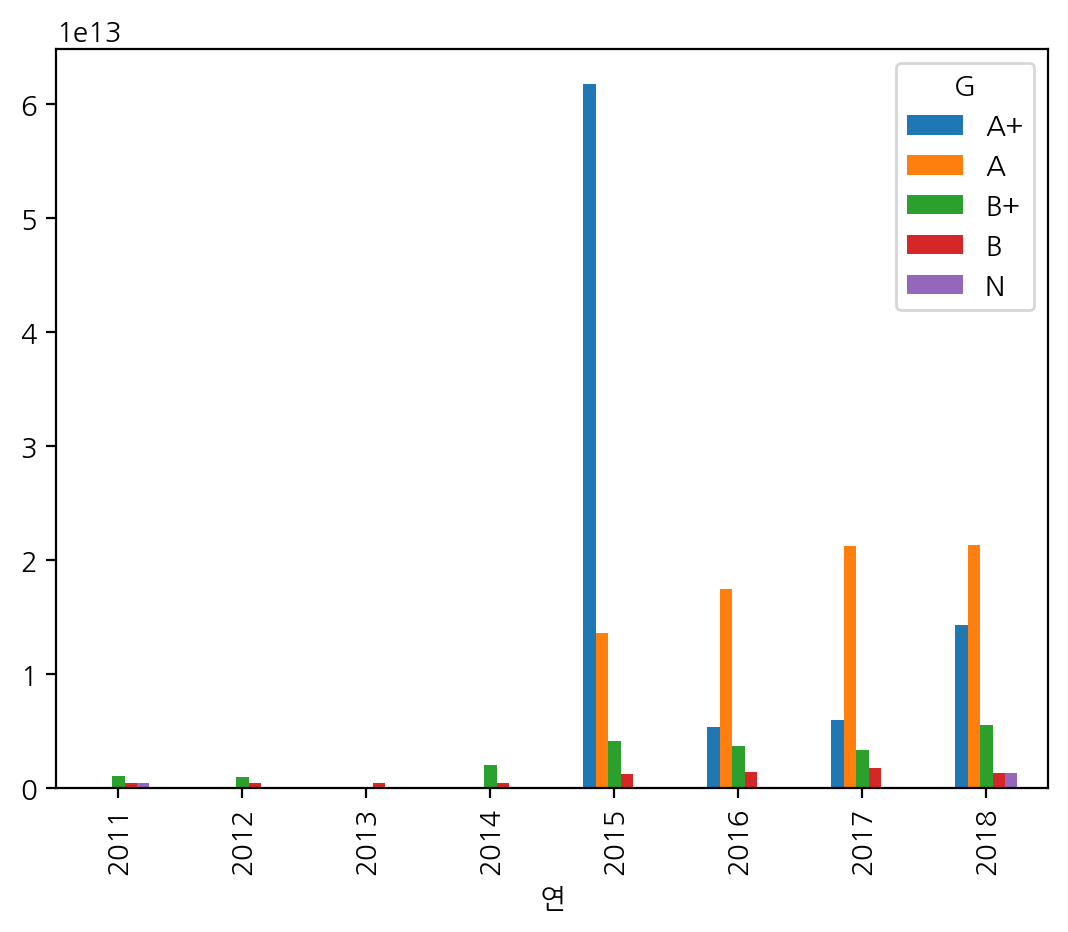

---------- ---------- ---------- ---------- ---------- 

기업영업이익
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  1.117900e+10  3.475231e+09           NaN
2012            NaN           NaN -5.980000e+09  1.191700e+10           NaN
2013            NaN           NaN           NaN  1.470364e+10           NaN
2014            NaN           NaN  1.878680e+11  1.671975e+10           NaN
2015            NaN  1.858241e+12  4.180014e+11  1.234248e+11           NaN
2016   5.298372e+11  2.522300e+12  4.444817e+11  1.005380e+11           NaN
2017   1.622327e+12  1.741426e+12  1.403495e+12  1.184061e+11           NaN
2018   1.418492e+12  3.758260e+12  3.243679e+11  1.080503e+11  4.601075e+10

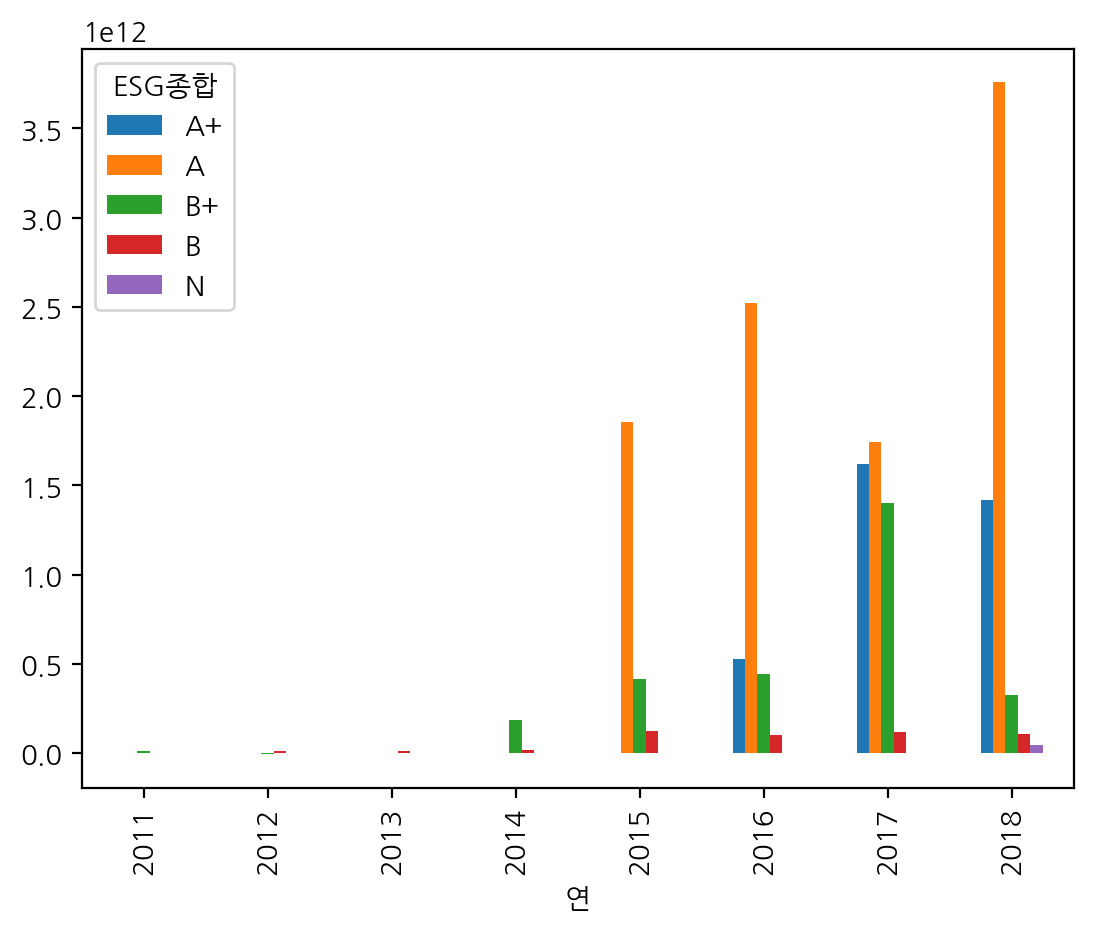

---------- ---------- ---------- ---------- ---------- 

기업영업이익
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  2.068981e+09  1.680400e+10   
2012           NaN           NaN           NaN  1.714000e+09  1.442600e+10   
2013           NaN           NaN           NaN -2.308079e+09  2.320950e+10   
2014           NaN           NaN  1.878680e+11           NaN  1.671975e+10   
2015           NaN  3.641386e+11  9.201180e+11  1.375150e+11  1.605763e+11   
2016  8.094403e+11  1.082182e+12  9.376662e+11  1.763549e+11  1.702986e+11   
2017  2.369605e+12  1.823469e+12  3.843329e+11  7.461023e+11  1.397591e+11   
2018  1.589107e+12  6.880507e+11  1.662576e+12  1.115126e+11  1.254005e+11   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  2.386210e+11  
2016  1.073311e+11  
2017  1.894883e+11  
2018  5.500218e+10

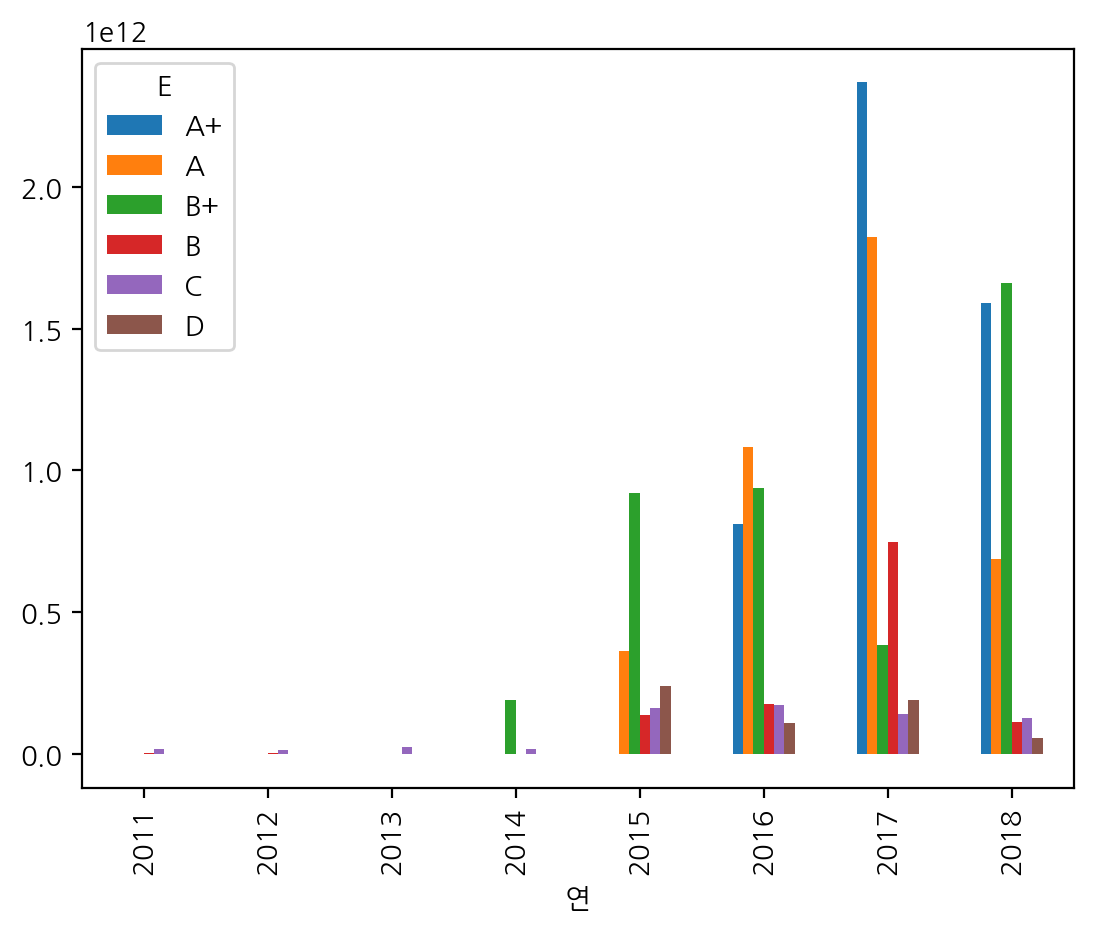

---------- ---------- ---------- ---------- ---------- 

기업영업이익
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  1.117900e+10  3.475231e+09           NaN
2012           NaN           NaN -5.980000e+09  1.191700e+10           NaN
2013           NaN           NaN           NaN  1.470364e+10           NaN
2014           NaN           NaN           NaN  5.094940e+10           NaN
2015  9.548822e+11  2.528570e+11  1.033939e+12  6.735094e+10           NaN
2016  2.239485e+12  3.431805e+11  3.407526e+11  1.085051e+11           NaN
2017  9.043679e+11  3.932176e+12  2.533660e+11  8.713623e+10           NaN
2018  1.622428e+12  3.190636e+12  1.453722e+11  9.336064e+10  4.601075e+10

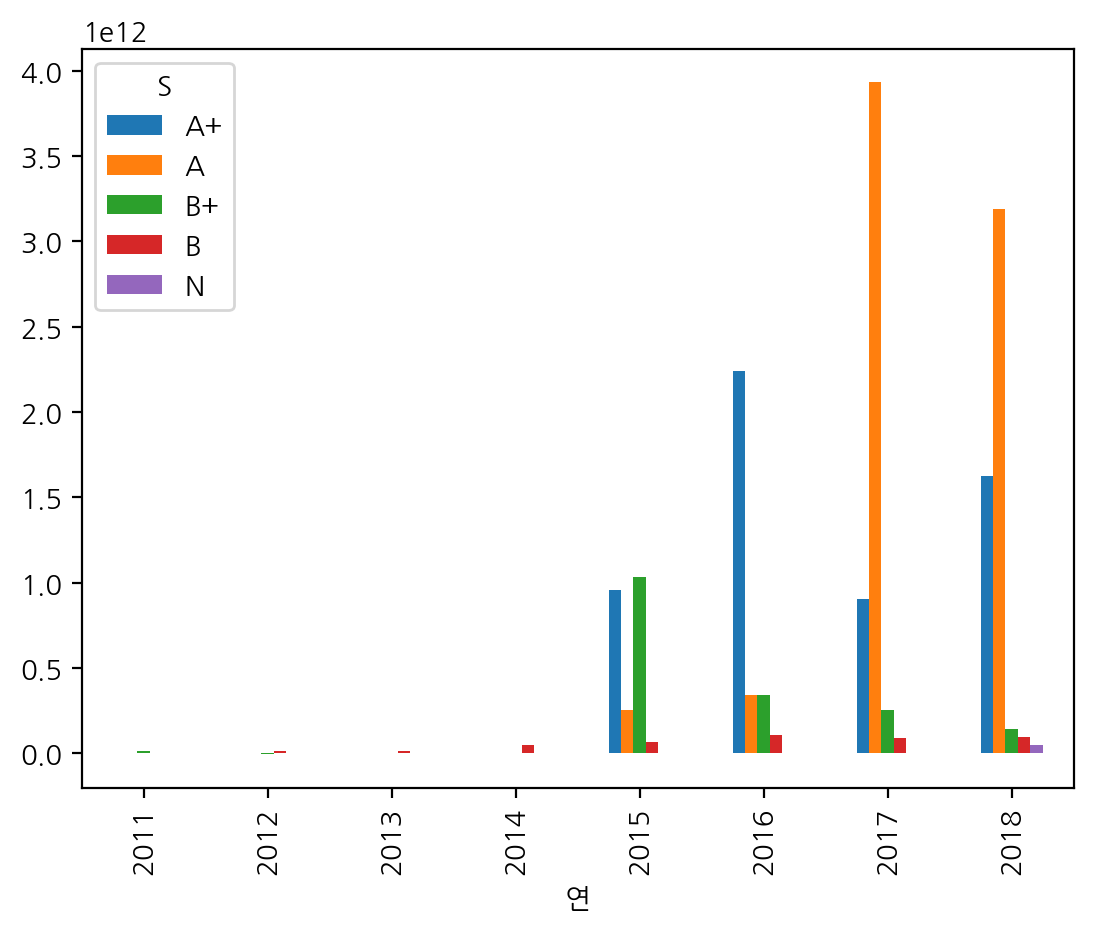

---------- ---------- ---------- ---------- ---------- 

기업영업이익
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  1.117900e+10  1.719850e+10 -1.024804e+10
2012           NaN           NaN -5.980000e+09  1.191700e+10           NaN
2013           NaN           NaN           NaN  1.470364e+10           NaN
2014           NaN           NaN  7.318267e+10  1.759950e+10           NaN
2015  7.082316e+12  3.355487e+11  3.257354e+11  8.201497e+10           NaN
2016 -1.129180e+11  1.286194e+12  2.886454e+11  9.721788e+10           NaN
2017  1.277724e+11  2.850494e+12  1.705885e+11  1.317199e+11           NaN
2018  7.025836e+11  2.607057e+12  6.846268e+11  1.009507e+11  4.601075e+10

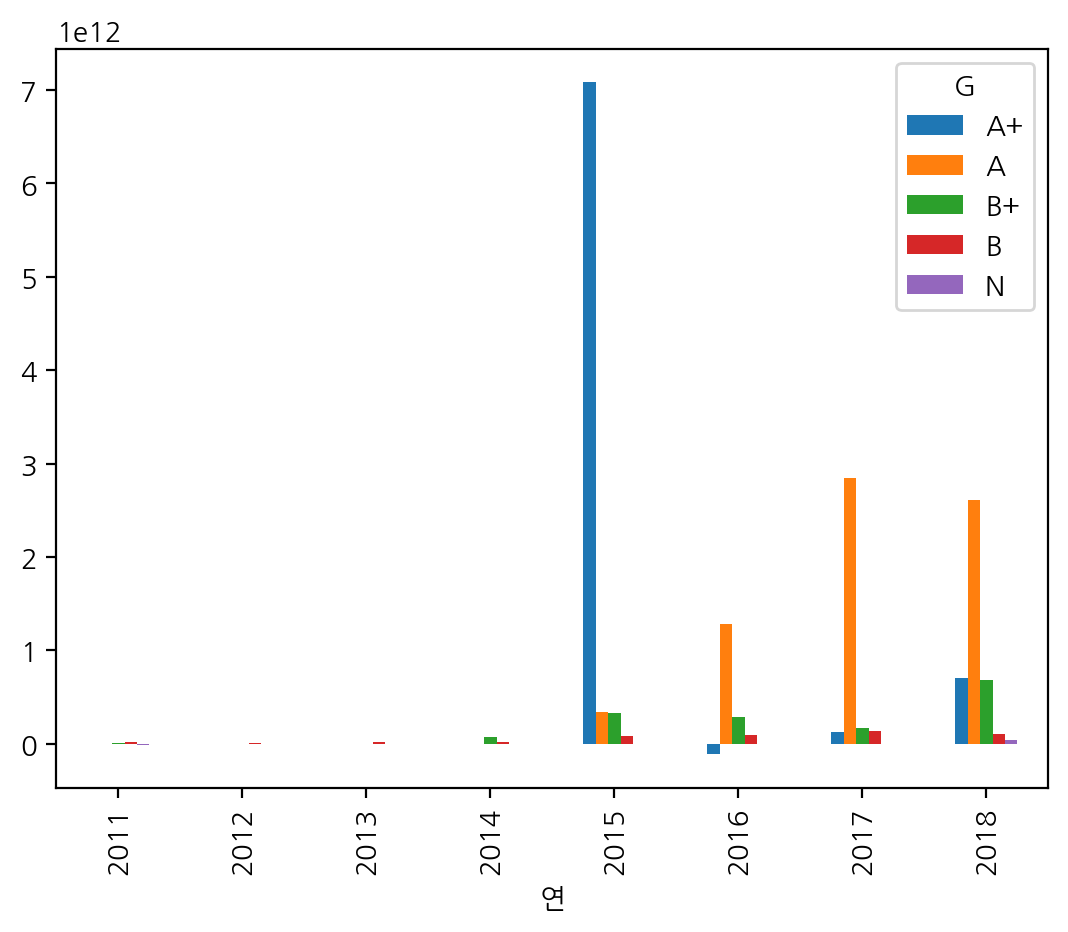

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN -1.176700e+10 -4.878722e+09           NaN
2012            NaN           NaN -1.367800e+10 -5.699550e+10           NaN
2013            NaN           NaN           NaN  3.200591e+09           NaN
2014            NaN           NaN  8.431100e+10 -4.409625e+10           NaN
2015            NaN  2.136946e+12  3.734157e+11  1.210981e+11           NaN
2016   6.316439e+11  2.470238e+12  3.280566e+11  8.806864e+10           NaN
2017   1.909732e+12  1.733342e+12  1.441793e+12  1.170019e+11           NaN
2018   2.361894e+12  3.841025e+12  2.932544e+11  8.709328e+10  6.207929e+10

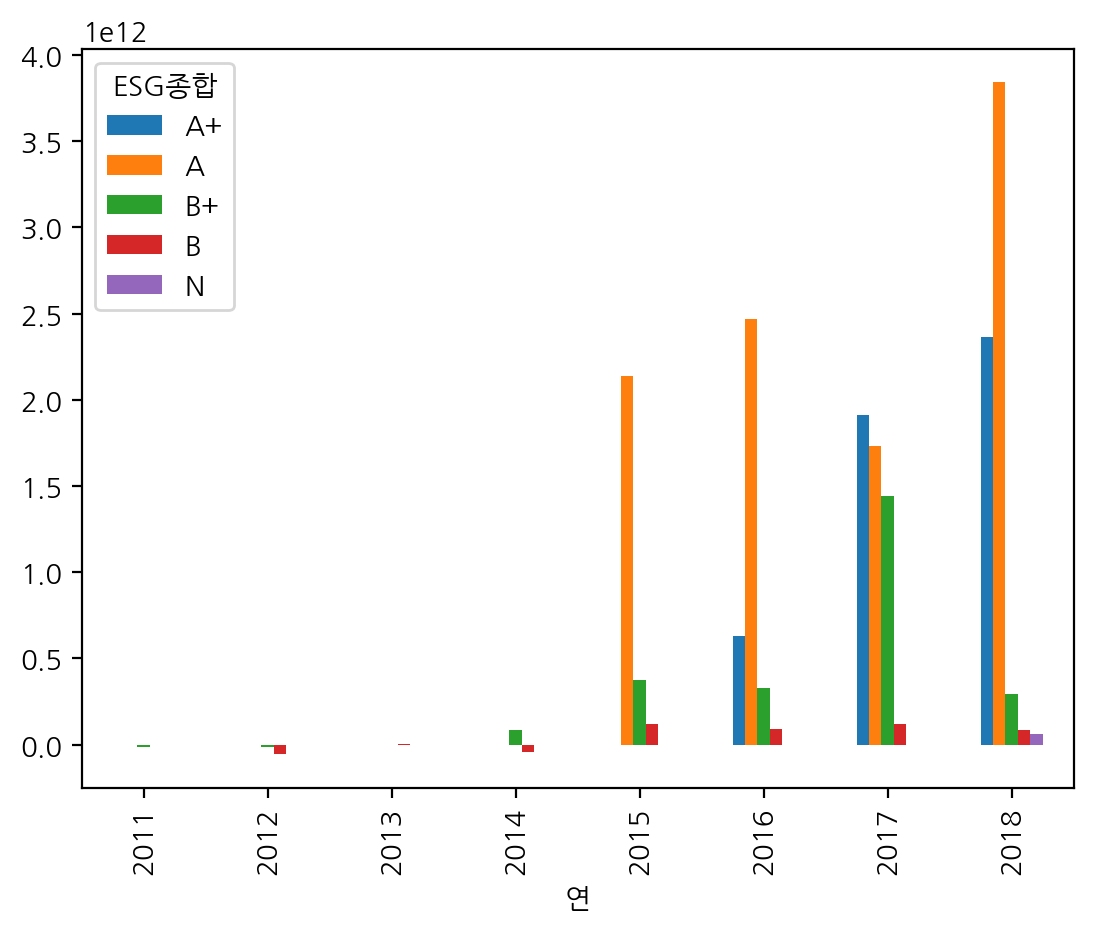

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN -1.202997e+10  1.683800e+10   
2012           NaN           NaN           NaN -1.472250e+10 -9.822400e+10   
2013           NaN           NaN           NaN -4.027226e+09  6.814500e+09   
2014           NaN           NaN  8.431100e+10           NaN -4.409625e+10   
2015           NaN  7.838802e+11  8.517805e+11  1.197589e+11  1.484770e+11   
2016  7.332820e+11  9.609502e+11  9.080850e+11  1.561559e+11  1.077666e+11   
2017  2.844610e+12  1.869462e+12  3.552759e+11  7.720739e+11  1.734391e+11   
2018  2.493675e+12  7.920772e+11  1.667265e+12  9.148075e+10  1.068683e+11   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  5.926820e+11  
2016  7.109405e+10  
2017  1.121382e+11  
2018  5.533721e+10

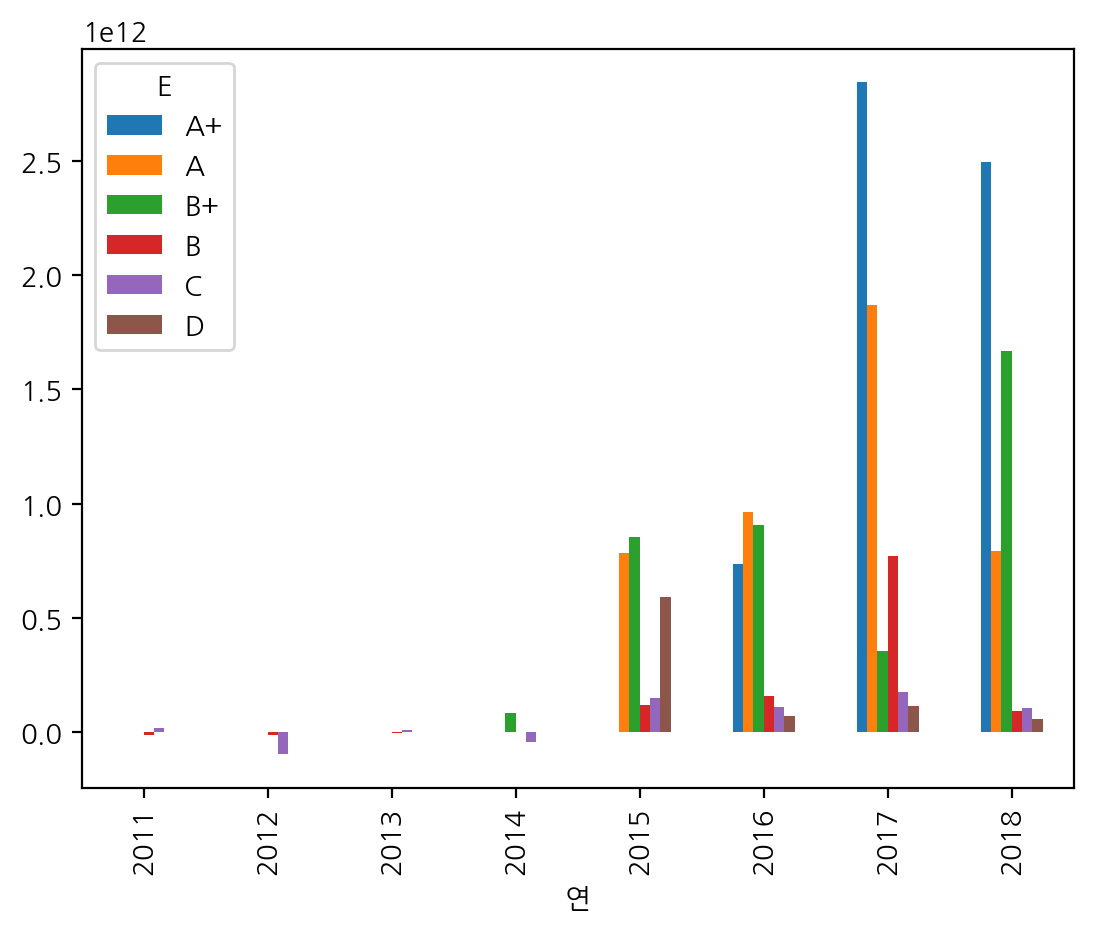

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN -1.176700e+10 -4.878722e+09           NaN
2012           NaN           NaN -1.367800e+10 -5.699550e+10           NaN
2013           NaN           NaN           NaN  3.200591e+09           NaN
2014           NaN           NaN           NaN -1.841480e+10           NaN
2015  8.824218e+11  4.375527e+11  1.016002e+12  6.419549e+10           NaN
2016  2.329077e+12  2.419781e+11  2.482090e+11  8.389885e+10           NaN
2017  9.234551e+11  4.057325e+12  2.354264e+11  9.119855e+10           NaN
2018  1.744722e+12  3.271749e+12  1.392582e+11  6.922508e+10  6.207929e+10

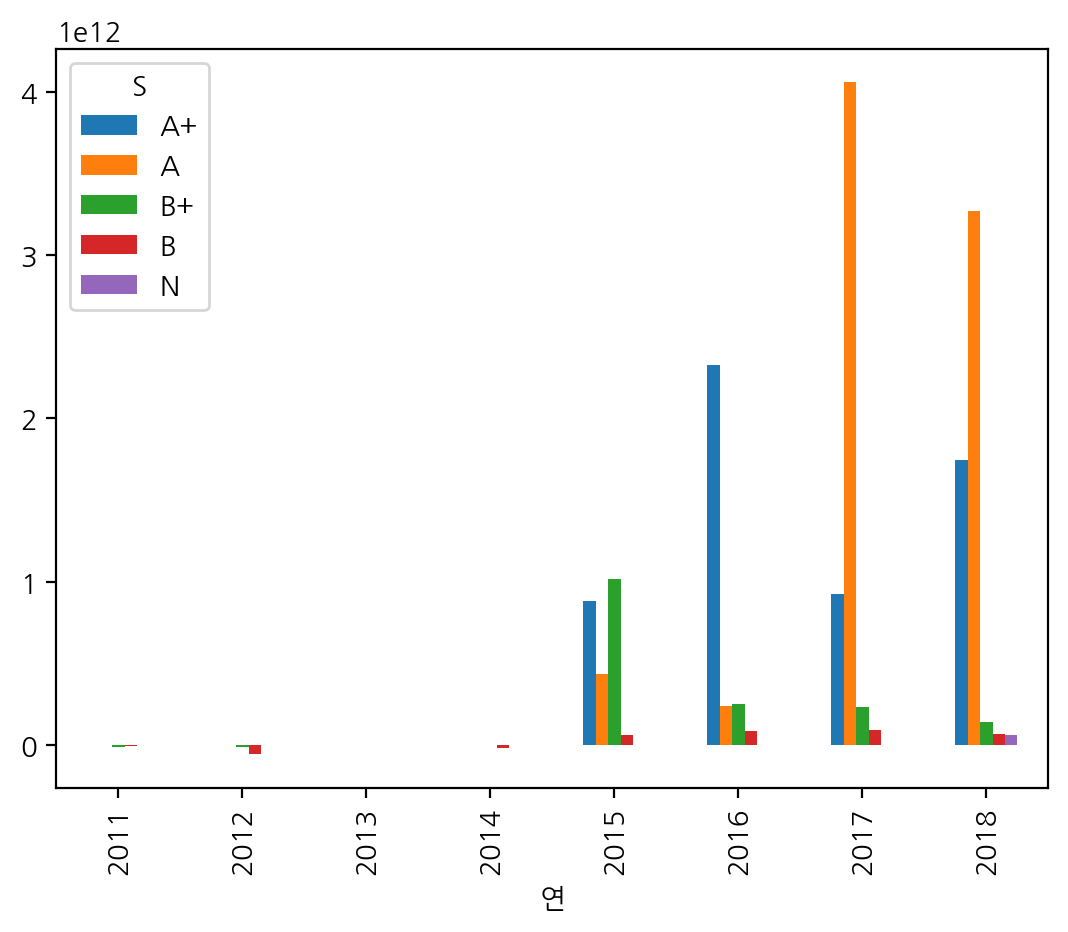

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN -1.176700e+10  2.646000e+09 -1.240344e+10
2012           NaN           NaN -1.367800e+10 -5.699550e+10           NaN
2013           NaN           NaN           NaN  3.200591e+09           NaN
2014           NaN           NaN -4.027033e+10  1.436850e+10           NaN
2015  7.120831e+12  3.654546e+11  3.581915e+11  7.158534e+10           NaN
2016 -3.560765e+10  1.125438e+12  2.596609e+11  9.364609e+10           NaN
2017  3.997539e+10  2.921587e+12  1.612283e+11  1.384062e+11           NaN
2018  1.211681e+12  2.732687e+12  6.431805e+11  1.004871e+11  6.207929e+10

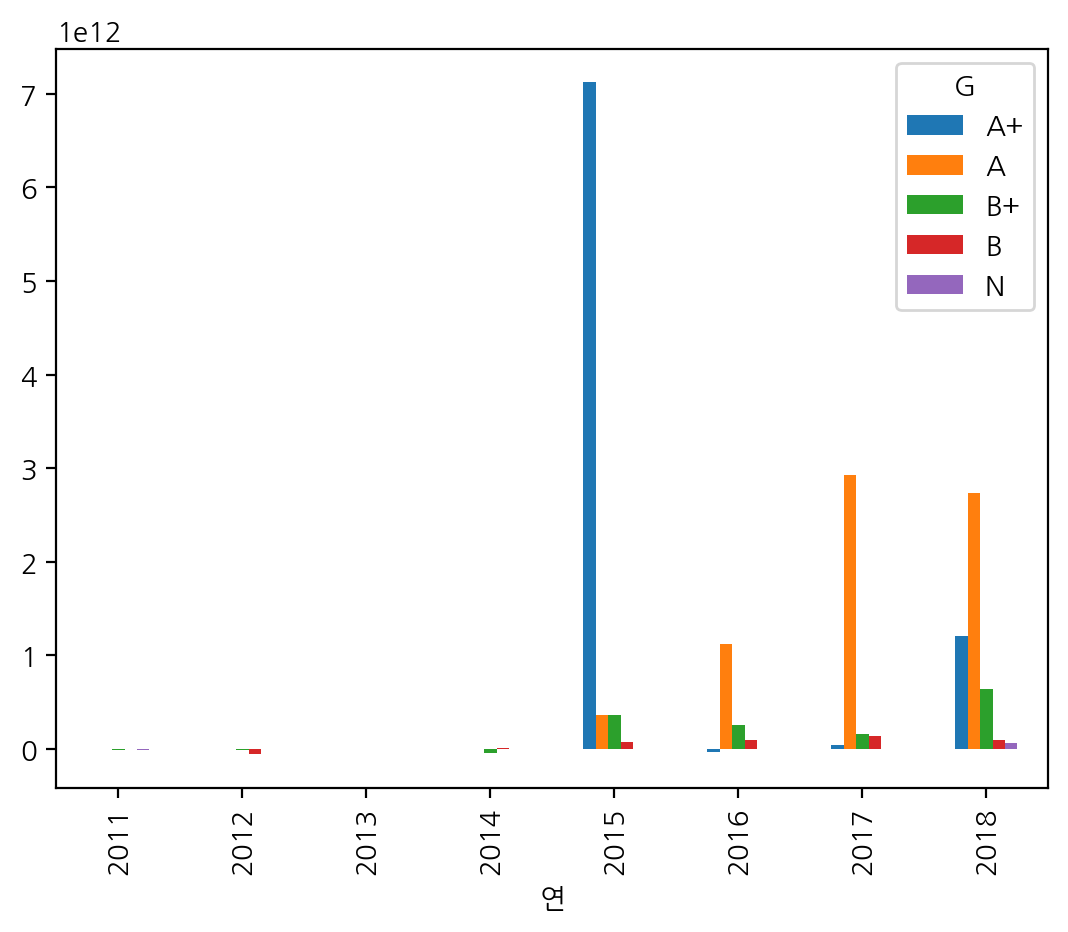

---------- ---------- ---------- ---------- ---------- 

기업당기순이익
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN -1.157800e+10 -4.005506e+09           NaN
2012            NaN           NaN -1.192700e+10 -5.356800e+10           NaN
2013            NaN           NaN           NaN  7.033562e+09           NaN
2014            NaN           NaN  4.494200e+10 -6.663325e+10           NaN
2015            NaN  1.473270e+12  3.107918e+11  8.828489e+10           NaN
2016   4.669959e+11  1.890780e+12  2.222605e+11  6.580673e+10           NaN
2017   1.363796e+12  1.336574e+12  1.112223e+12  1.396136e+11           NaN
2018   1.889137e+12  2.711379e+12  2.430442e+11  9.081427e+10  5.984832e+10

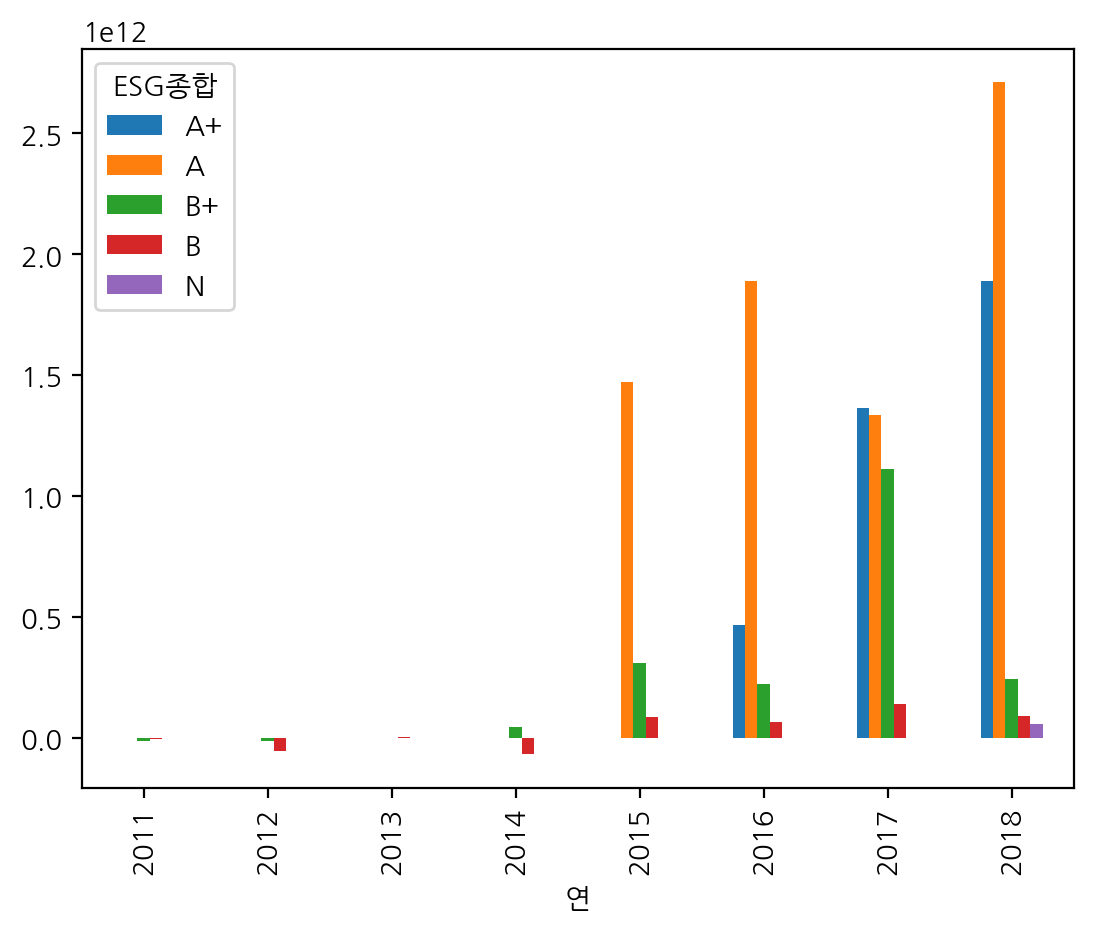

---------- ---------- ---------- ---------- ---------- 

기업당기순이익
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN -1.009451e+10  1.277800e+10   
2012           NaN           NaN           NaN -1.646800e+10 -8.612700e+10   
2013           NaN           NaN           NaN  1.435269e+10  3.374000e+09   
2014           NaN           NaN  4.494200e+10           NaN -6.663325e+10   
2015           NaN  3.908006e+11  6.641413e+11  9.848754e+10  1.005515e+11   
2016  5.224013e+11  7.654476e+11  7.108773e+11  1.121181e+11  5.036014e+10   
2017  2.043562e+12  1.434050e+12  2.834654e+11  6.486410e+11  1.787684e+11   
2018  2.030412e+12  4.197066e+11  1.231154e+12  6.700131e+10  1.821974e+11   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  5.803935e+11  
2016  3.636648e+10  
2017  9.485105e+10  
2018  3.719978e+10

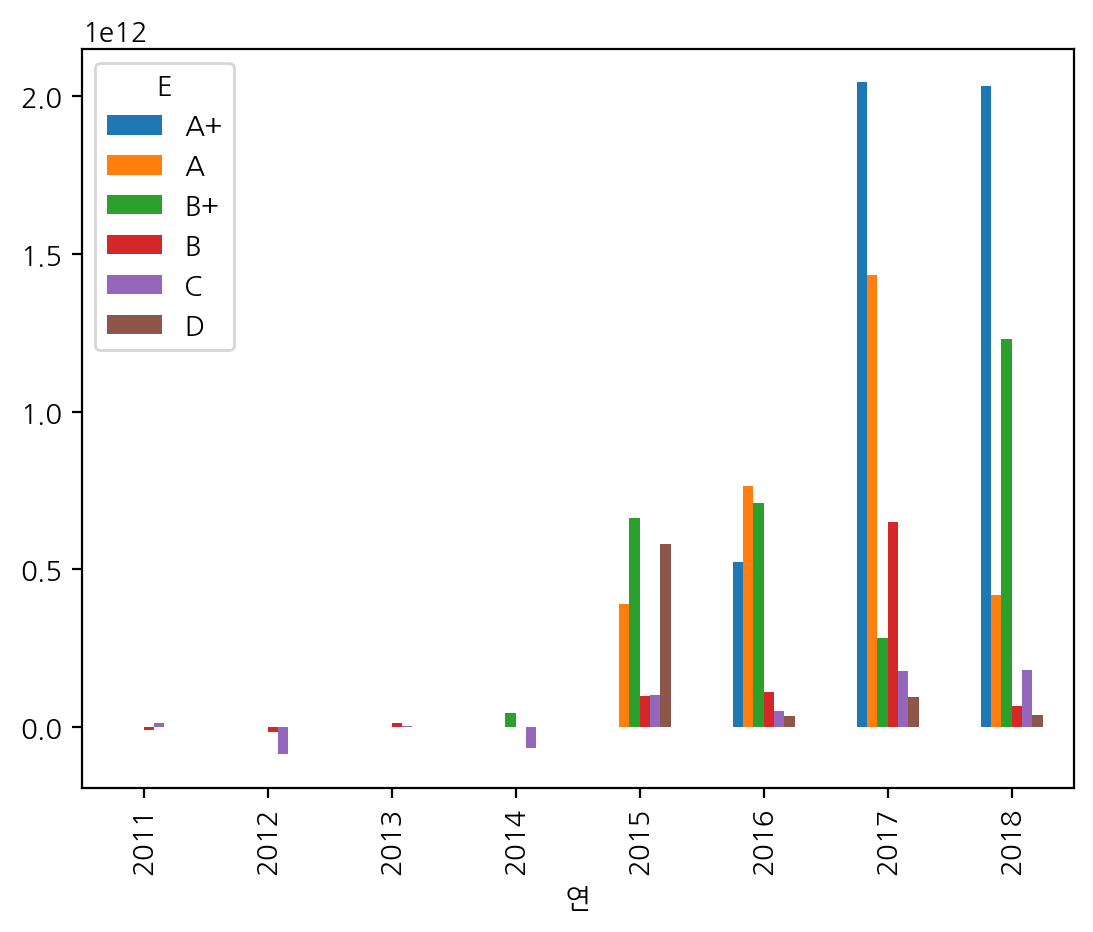

---------- ---------- ---------- ---------- ---------- 

기업당기순이익
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN -1.157800e+10 -4.005506e+09           NaN
2012           NaN           NaN -1.192700e+10 -5.356800e+10           NaN
2013           NaN           NaN           NaN  7.033562e+09           NaN
2014           NaN           NaN           NaN -4.431820e+10           NaN
2015  6.494638e+11  1.945547e+11  7.990505e+11  4.727795e+10           NaN
2016  1.724942e+12  2.706028e+11  1.641039e+11  6.239378e+10           NaN
2017  6.771964e+11  3.340596e+12  1.775446e+11  9.358986e+10           NaN
2018  1.212849e+12  2.409370e+12  1.783114e+11  4.640849e+10  5.984832e+10

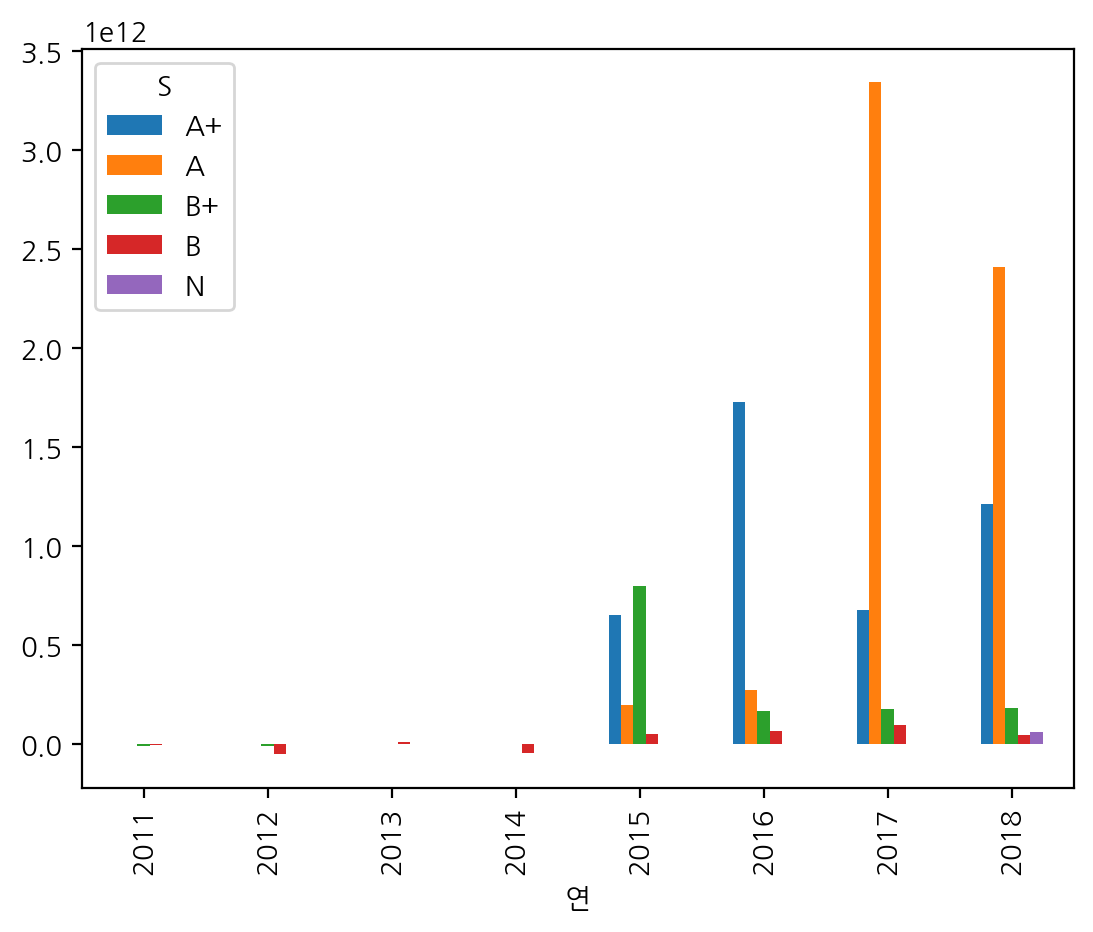

---------- ---------- ---------- ---------- ---------- 

기업당기순이익
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN -1.157800e+10  1.455000e+09 -9.466012e+09
2012           NaN           NaN -1.192700e+10 -5.356800e+10           NaN
2013           NaN           NaN           NaN  7.033562e+09           NaN
2014           NaN           NaN -7.973433e+10  8.806000e+09           NaN
2015  5.507228e+12  2.002736e+11  2.814194e+11  5.258105e+10           NaN
2016 -2.043937e+10  8.070548e+11  2.095829e+11  6.983331e+10           NaN
2017  4.263152e+09  2.214489e+12  1.171619e+11  1.786809e+11           NaN
2018  9.031773e+11  2.009552e+12  5.013782e+11  7.916774e+10  5.984832e+10

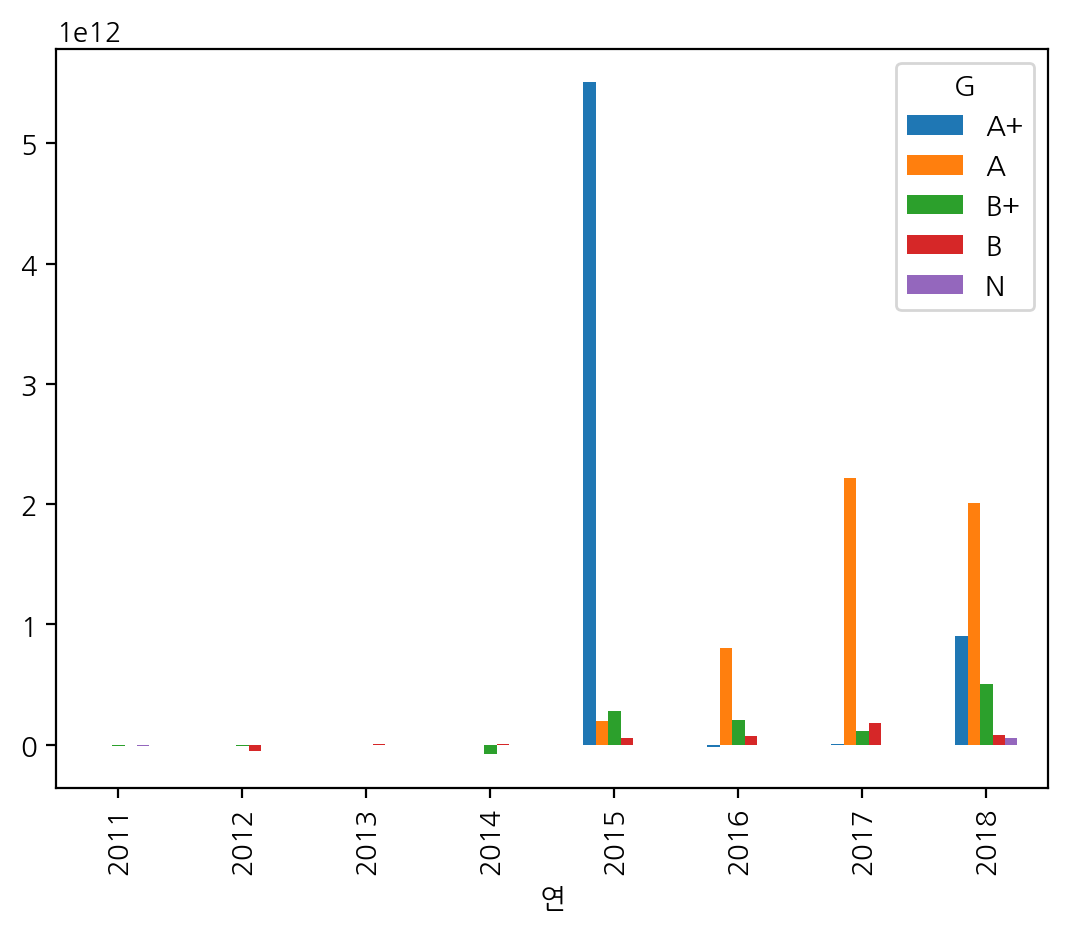

---------- ---------- ---------- ---------- ---------- 

기업총자산금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  7.686530e+11  4.757246e+11           NaN
2012            NaN           NaN  8.291580e+11  5.121300e+11           NaN
2013            NaN           NaN           NaN  5.031727e+11           NaN
2014            NaN           NaN  3.537038e+12  9.310376e+11           NaN
2015            NaN  2.985661e+13  1.270088e+13  2.631074e+12           NaN
2016   2.005803e+13  3.282448e+13  1.111272e+13  1.854202e+12           NaN
2017   2.876867e+13  2.115233e+13  1.338517e+13  2.383246e+12           NaN
2018   4.004697e+13  2.940985e+13  6.858336e+12  2.245647e+12  1.752497e+12

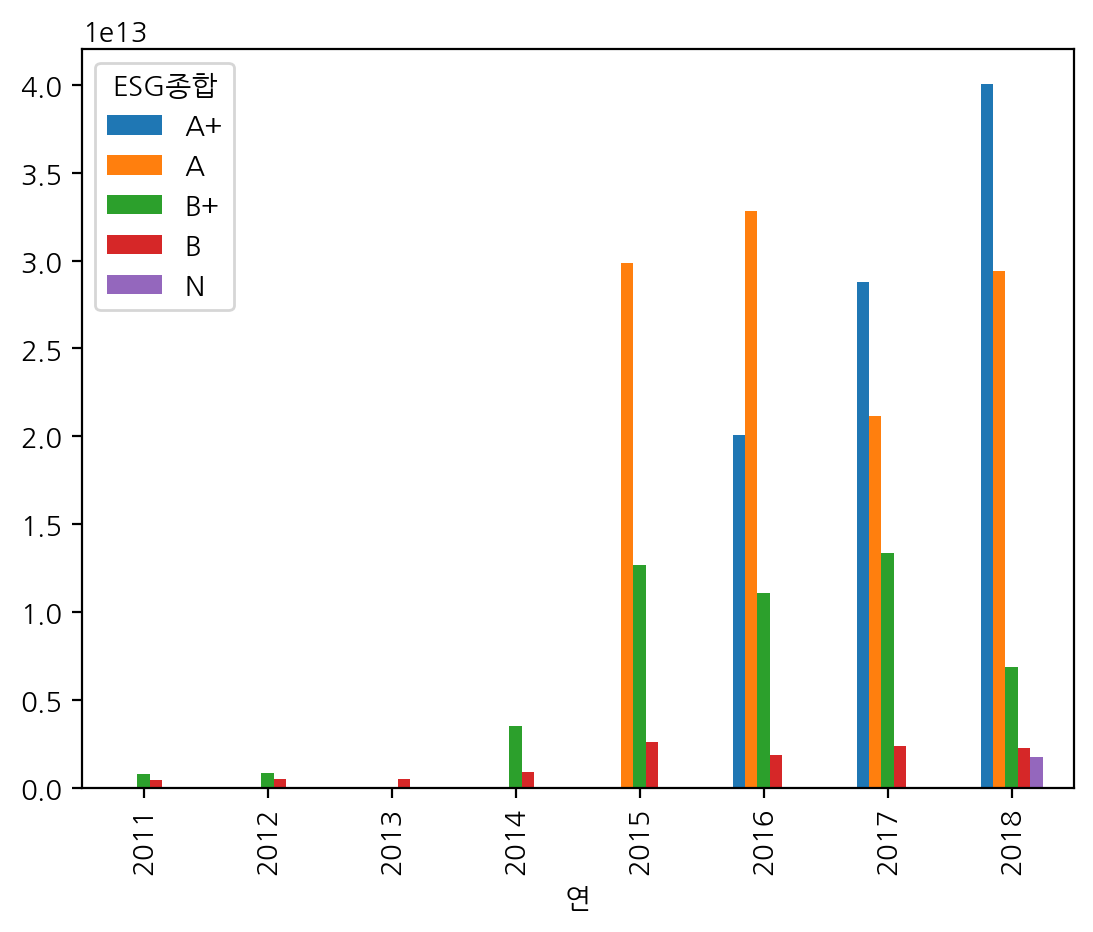

---------- ---------- ---------- ---------- ---------- 

기업총자산금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  4.774939e+11  7.615760e+11   
2012           NaN           NaN           NaN  7.152870e+11  4.228440e+11   
2013           NaN           NaN           NaN  8.601822e+10  7.117500e+11   
2014           NaN           NaN  3.537038e+12           NaN  9.310376e+11   
2015           NaN  1.297740e+13  1.522725e+13  3.831324e+12  3.499600e+12   
2016  2.081142e+13  1.845546e+13  1.501936e+13  2.870666e+12  4.690841e+12   
2017  3.997525e+13  2.261477e+13  6.414399e+12  6.406953e+12  3.032046e+12   
2018  4.068122e+13  1.834103e+13  1.315558e+13  2.944273e+12  2.796671e+12   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  1.800846e+13  
2016  2.898949e+12  
2017  4.075517e+12  
2018  1.328826e+12

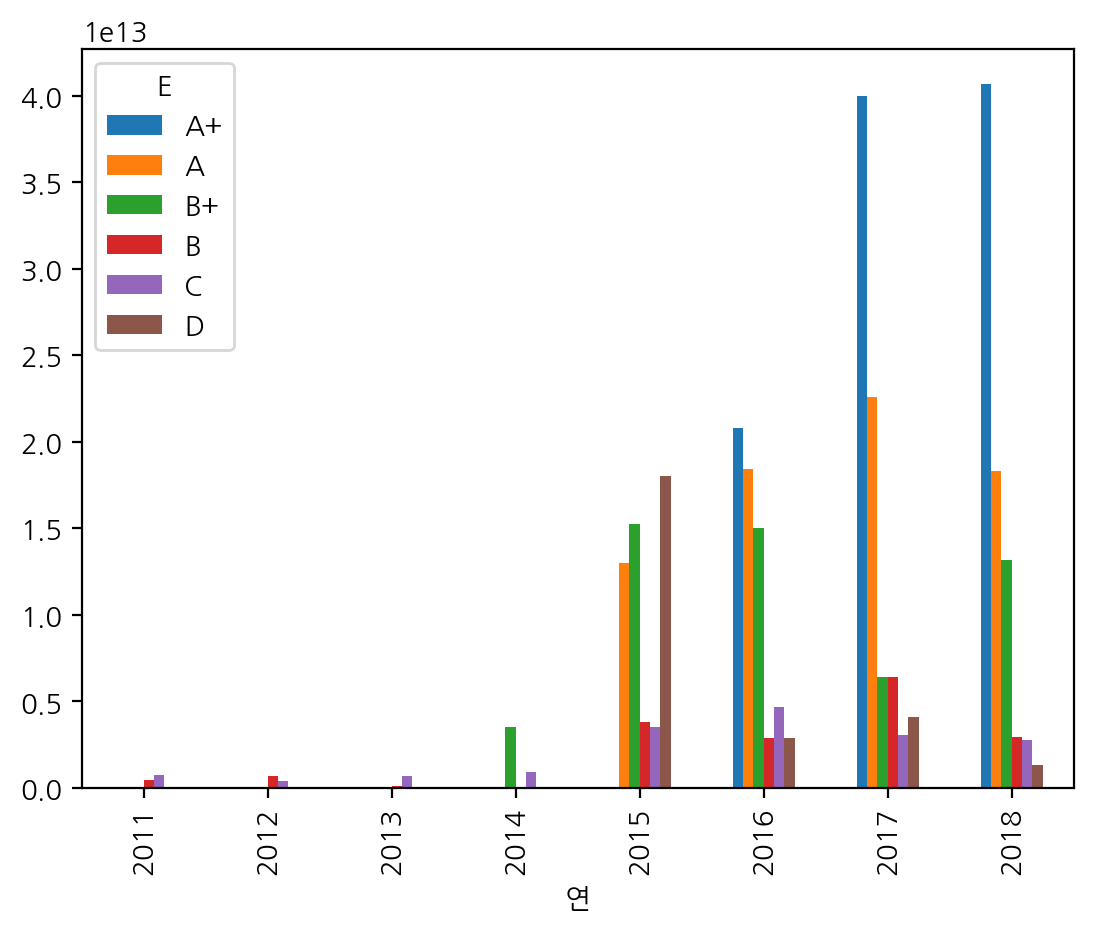

---------- ---------- ---------- ---------- ---------- 

기업총자산금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  7.686530e+11  4.757246e+11           NaN
2012           NaN           NaN  8.291580e+11  5.121300e+11           NaN
2013           NaN           NaN           NaN  5.031727e+11           NaN
2014           NaN           NaN           NaN  1.452238e+12           NaN
2015  8.456787e+12  1.455317e+13  1.707252e+13  2.288242e+12           NaN
2016  3.020438e+13  1.303357e+13  7.272313e+12  2.284968e+12           NaN
2017  1.990262e+13  2.802574e+13  5.257183e+12  2.031610e+12           NaN
2018  1.775124e+13  3.119498e+13  2.760458e+12  2.274595e+12  1.752497e+12

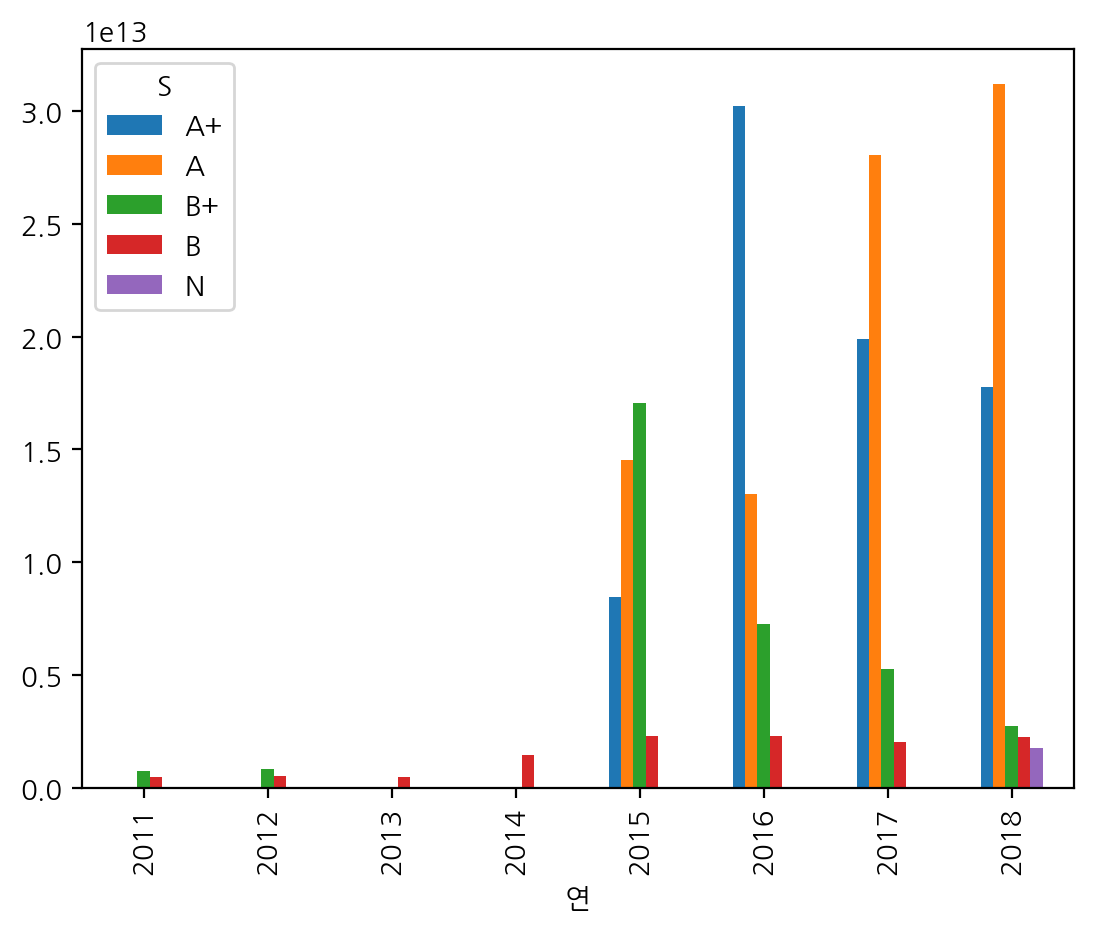

---------- ---------- ---------- ---------- ---------- 

기업총자산금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  7.686530e+11  7.137270e+11  2.377223e+11
2012           NaN           NaN  8.291580e+11  5.121300e+11           NaN
2013           NaN           NaN           NaN  5.031727e+11           NaN
2014           NaN           NaN  1.904097e+12  7.744493e+11           NaN
2015  7.733738e+13  1.972428e+13  5.582721e+12  1.503296e+12           NaN
2016  6.367598e+12  2.421669e+13  4.726089e+12  1.641420e+12           NaN
2017  6.355504e+12  2.876332e+13  4.128281e+12  2.098811e+12           NaN
2018  2.024980e+13  2.910508e+13  7.011340e+12  1.840360e+12  1.752497e+12

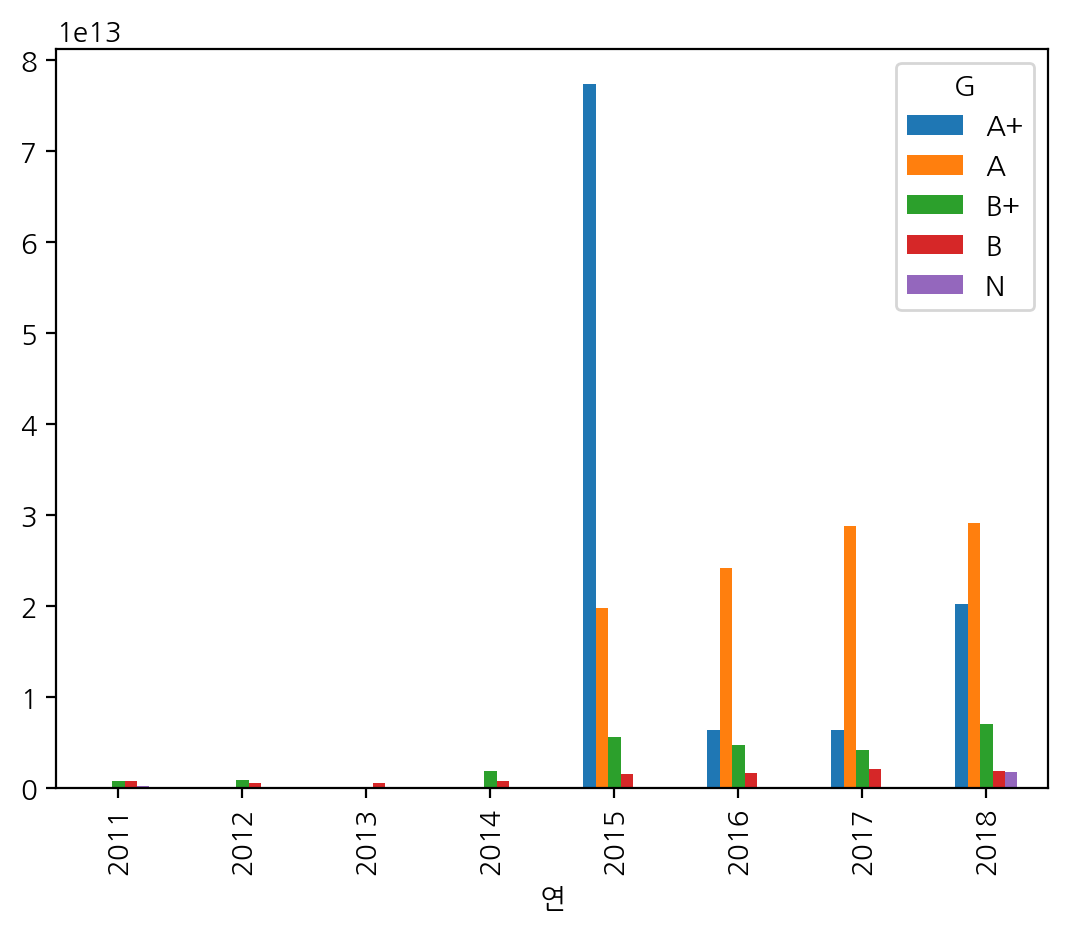

---------- ---------- ---------- ---------- ---------- 

기업총부채금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  4.348770e+11  2.968821e+11           NaN
2012            NaN           NaN  5.118230e+11  3.573500e+11           NaN
2013            NaN           NaN           NaN  3.309835e+11           NaN
2014            NaN           NaN  1.912214e+12  6.615524e+11           NaN
2015            NaN  1.054122e+13  7.640078e+12  1.346514e+12           NaN
2016   1.002891e+13  1.199609e+13  6.551320e+12  8.491632e+11           NaN
2017   1.546057e+13  1.152090e+13  5.491544e+12  1.029151e+12           NaN
2018   2.033825e+13  1.202868e+13  3.300376e+12  1.032712e+12  5.154410e+11

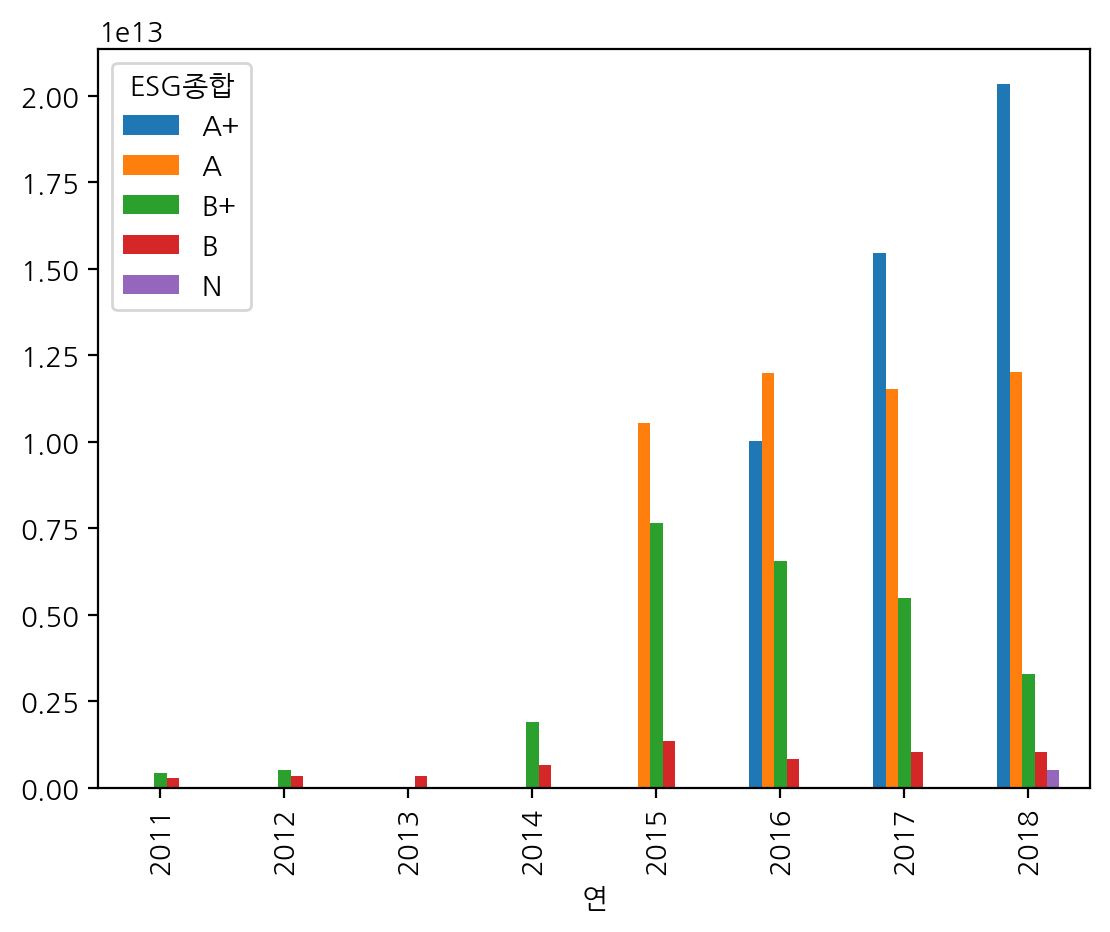

---------- ---------- ---------- ---------- ---------- 

기업총부채금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  3.056793e+11  3.996880e+11   
2012           NaN           NaN           NaN  4.756530e+11  2.752170e+11   
2013           NaN           NaN           NaN  8.975754e+10  4.515965e+11   
2014           NaN           NaN  1.912214e+12           NaN  6.615524e+11   
2015           NaN  6.232192e+12  6.966921e+12  2.083348e+12  1.698764e+12   
2016  9.475100e+12  8.664776e+12  6.868165e+12  1.430602e+12  2.525109e+12   
2017  2.203254e+13  1.233810e+13  3.357167e+12  2.265708e+12  1.211907e+12   
2018  2.131063e+13  1.142682e+13  4.895153e+12  1.441245e+12  1.105792e+12   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  1.226059e+13  
2016  1.526771e+12  
2017  2.275418e+12  
2018  4.826000e+11

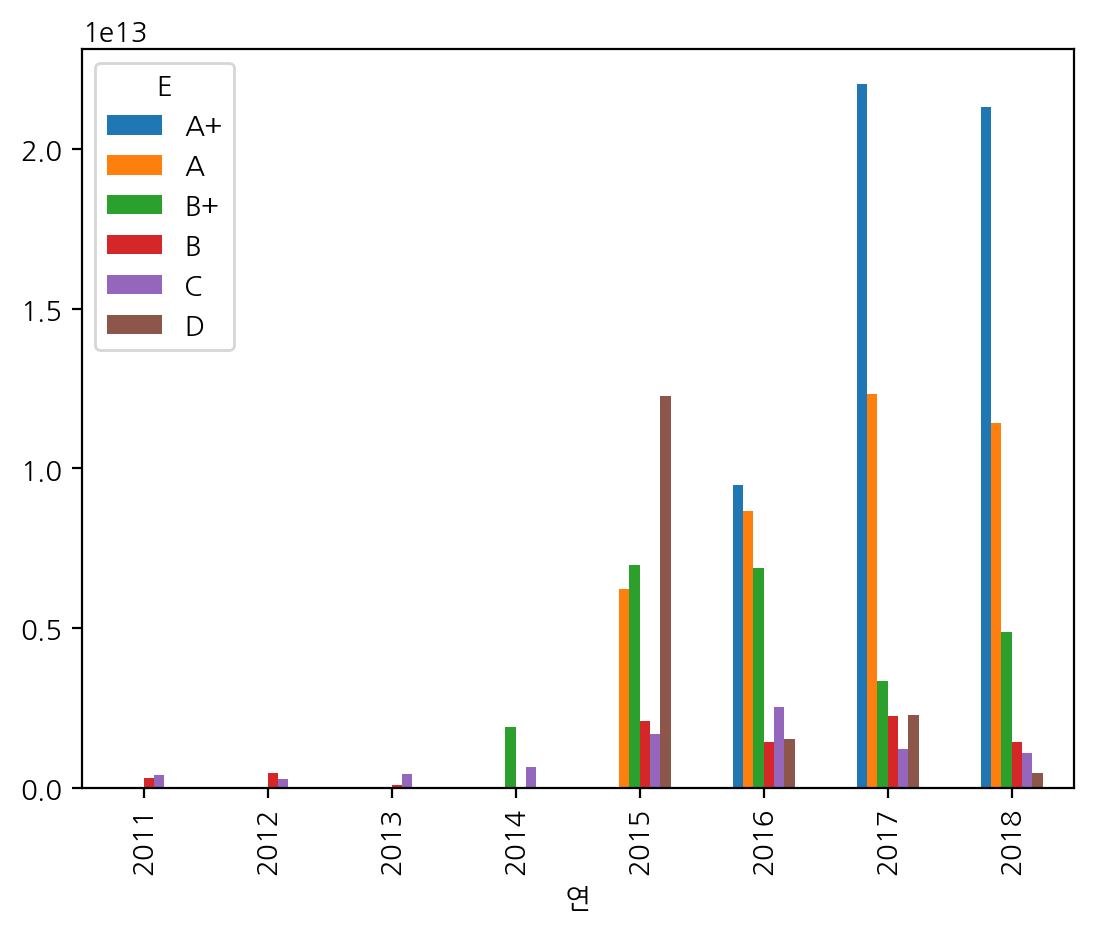

---------- ---------- ---------- ---------- ---------- 

기업총부채금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  4.348770e+11  2.968821e+11           NaN
2012           NaN           NaN  5.118230e+11  3.573500e+11           NaN
2013           NaN           NaN           NaN  3.309835e+11           NaN
2014           NaN           NaN           NaN  9.116847e+11           NaN
2015  3.560826e+12  7.656536e+12  8.149260e+12  1.190914e+12           NaN
2016  1.133505e+13  6.339261e+12  4.315577e+12  1.147694e+12           NaN
2017  1.140495e+13  9.849007e+12  2.896575e+12  8.991686e+11           NaN
2018  7.976826e+12  1.348629e+13  1.183043e+12  1.121470e+12  5.154410e+11

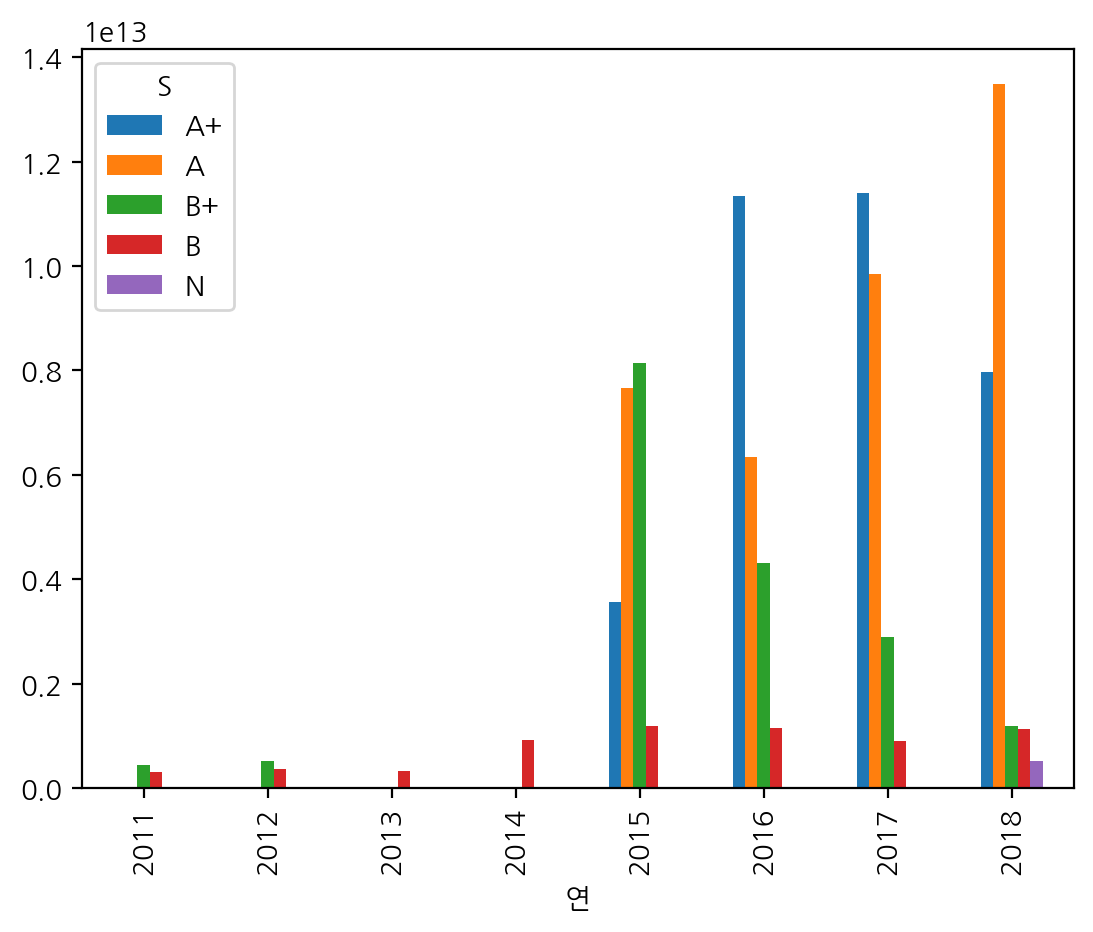

---------- ---------- ---------- ---------- ---------- 

기업총부채금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  4.348770e+11  4.482645e+11  1.454997e+11
2012           NaN           NaN  5.118230e+11  3.573500e+11           NaN
2013           NaN           NaN           NaN  3.309835e+11           NaN
2014           NaN           NaN  1.251296e+12  4.022678e+11           NaN
2015  1.857593e+13  1.278719e+13  2.569036e+12  6.379655e+11           NaN
2016  2.192647e+12  1.233963e+13  2.085701e+12  6.531915e+11           NaN
2017  2.316636e+12  1.344174e+13  2.062685e+12  8.182450e+11           NaN
2018  9.334068e+12  1.293106e+13  3.333614e+12  6.990284e+11  5.154410e+11

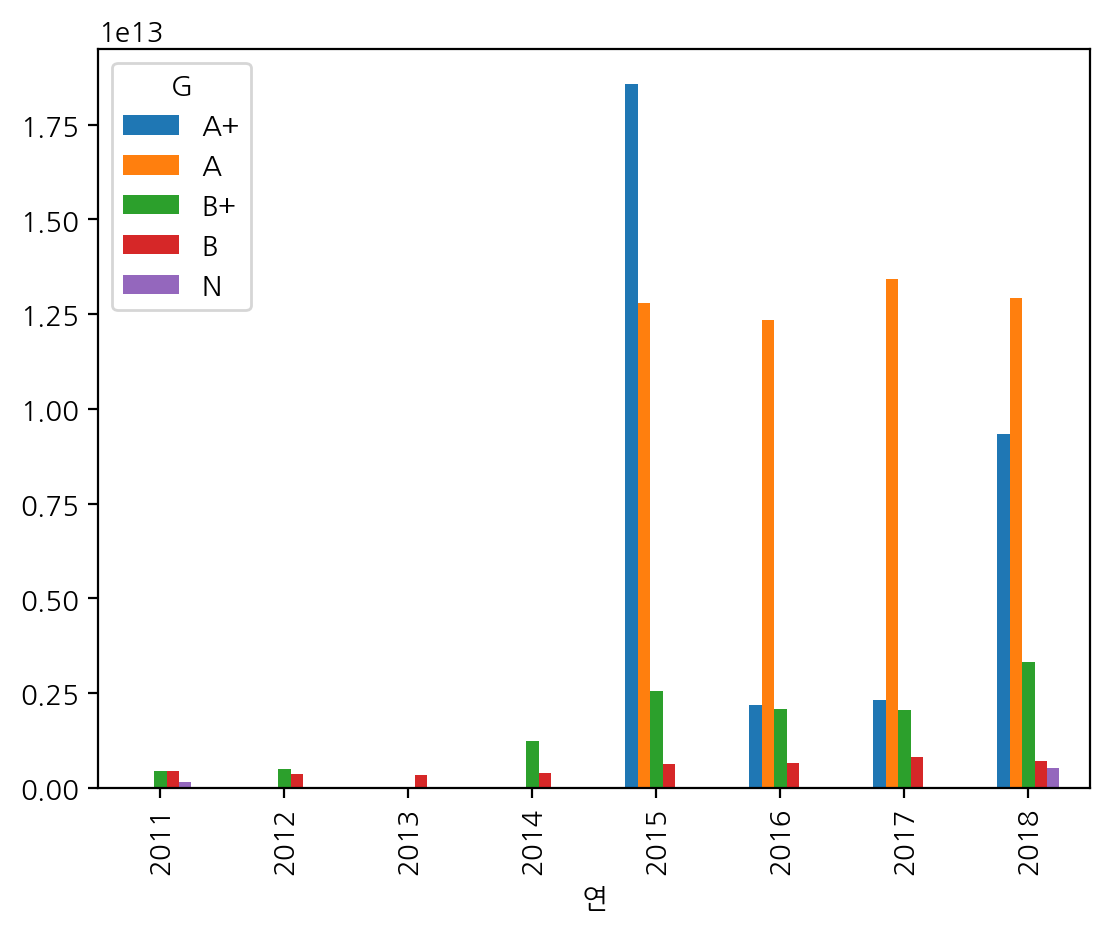

---------- ---------- ---------- ---------- ---------- 

기업총자본금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  3.337760e+11  1.788425e+11           NaN
2012            NaN           NaN  3.173350e+11  1.547800e+11           NaN
2013            NaN           NaN           NaN  1.721892e+11           NaN
2014            NaN           NaN  1.624824e+12  2.694853e+11           NaN
2015            NaN  1.931539e+13  5.060806e+12  1.289095e+12           NaN
2016   1.002912e+13  2.082839e+13  4.550440e+12  1.010287e+12           NaN
2017   1.330810e+13  9.600928e+12  7.893623e+12  1.333923e+12           NaN
2018   1.970872e+13  1.738117e+13  3.557961e+12  1.183801e+12  1.237056e+12

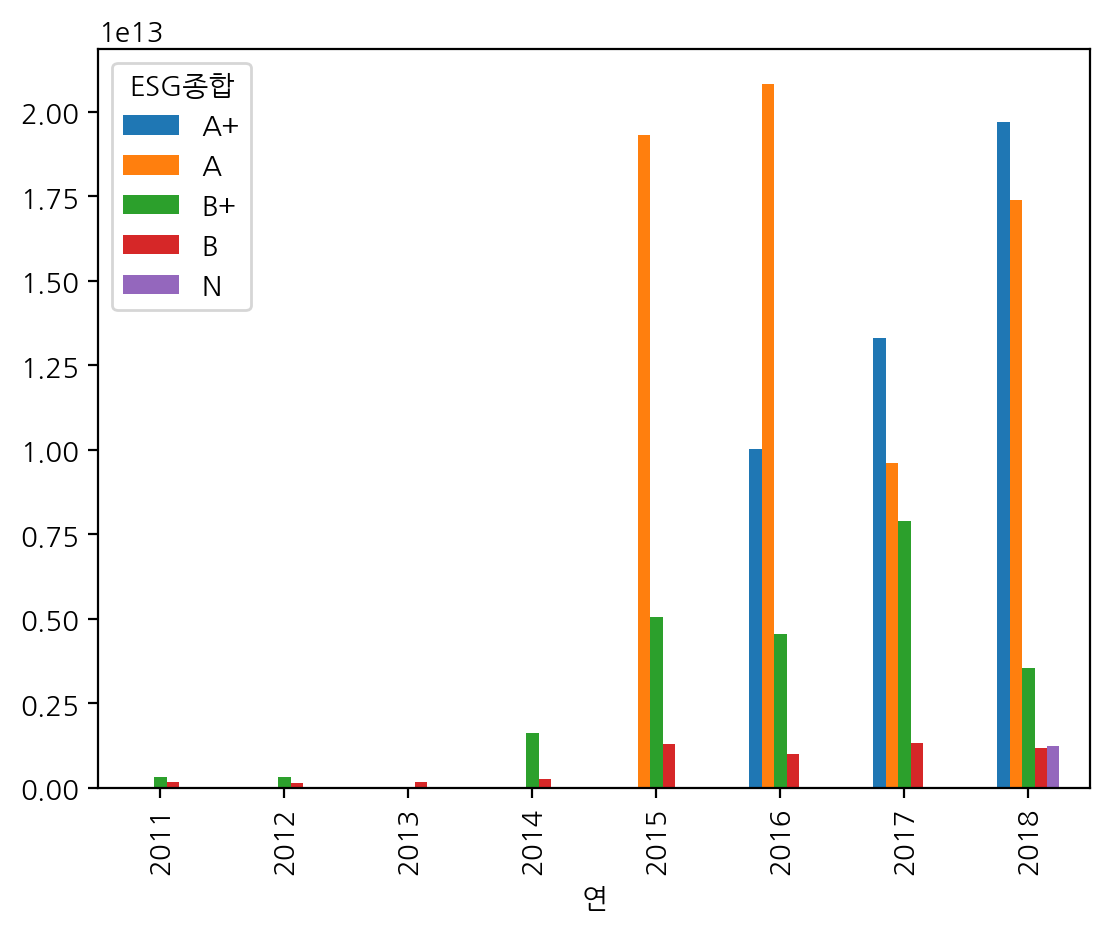

---------- ---------- ---------- ---------- ---------- 

기업총자본금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  1.718145e+11  3.618880e+11   
2012           NaN           NaN           NaN  2.396340e+11  1.476270e+11   
2013           NaN           NaN           NaN -3.739311e+09  2.601535e+11   
2014           NaN           NaN  1.624824e+12           NaN  2.694853e+11   
2015           NaN  6.745210e+12  8.265161e+12  1.756370e+12  1.797587e+12   
2016  1.133632e+13  9.790687e+12  8.136246e+12  1.440064e+12  2.178882e+12   
2017  1.794271e+13  1.027667e+13  3.047935e+12  4.109305e+12  1.820139e+12   
2018  1.937059e+13  6.914213e+12  8.220046e+12  1.500573e+12  1.669593e+12   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  5.747865e+12  
2016  1.372178e+12  
2017  1.800099e+12  
2018  8.462259e+11

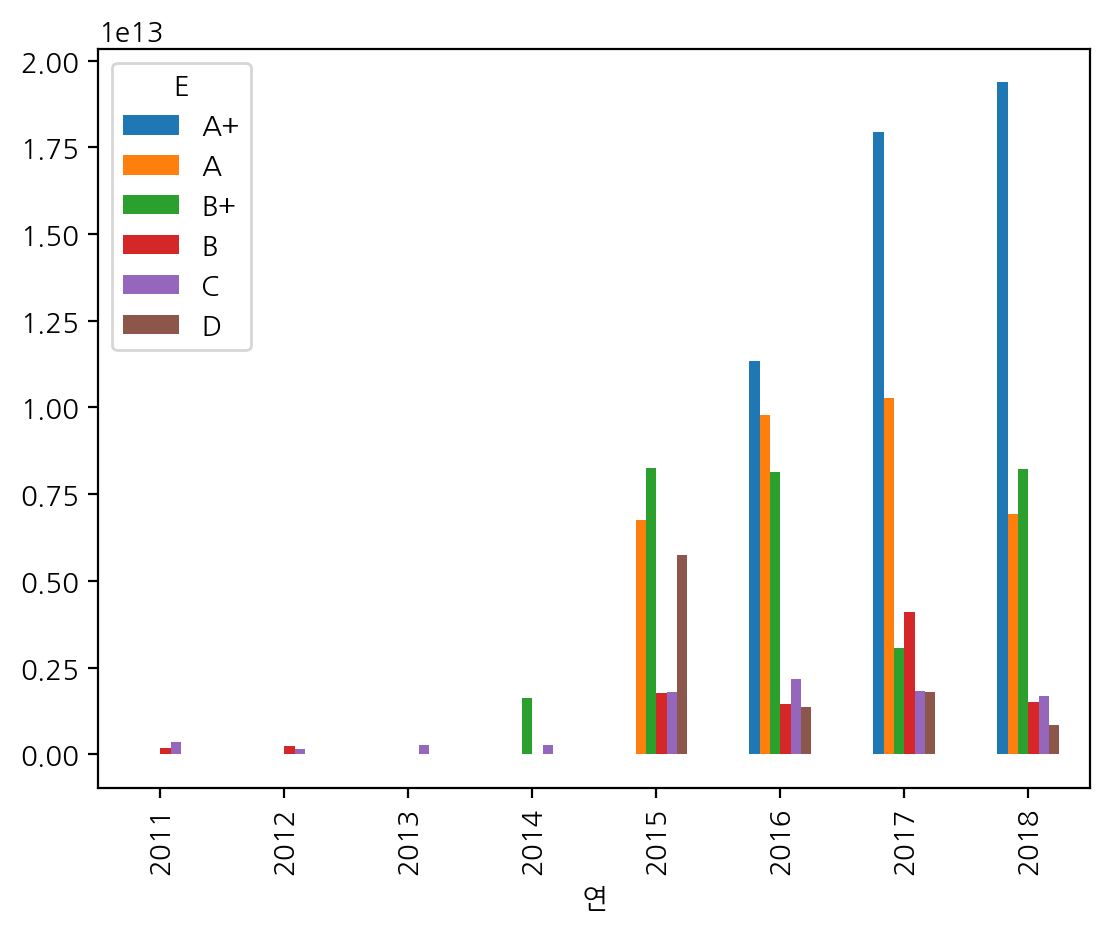

---------- ---------- ---------- ---------- ---------- 

기업총자본금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  3.337760e+11  1.788425e+11           NaN
2012           NaN           NaN  3.173350e+11  1.547800e+11           NaN
2013           NaN           NaN           NaN  1.721892e+11           NaN
2014           NaN           NaN           NaN  5.405530e+11           NaN
2015  4.895961e+12  6.896630e+12  8.918708e+12  1.103766e+12           NaN
2016  1.886933e+13  6.694311e+12  2.958698e+12  1.137275e+12           NaN
2017  8.468098e+12  1.817674e+13  2.360609e+12  1.108733e+12           NaN
2018  9.774413e+12  1.770869e+13  1.554406e+12  1.129699e+12  1.237056e+12

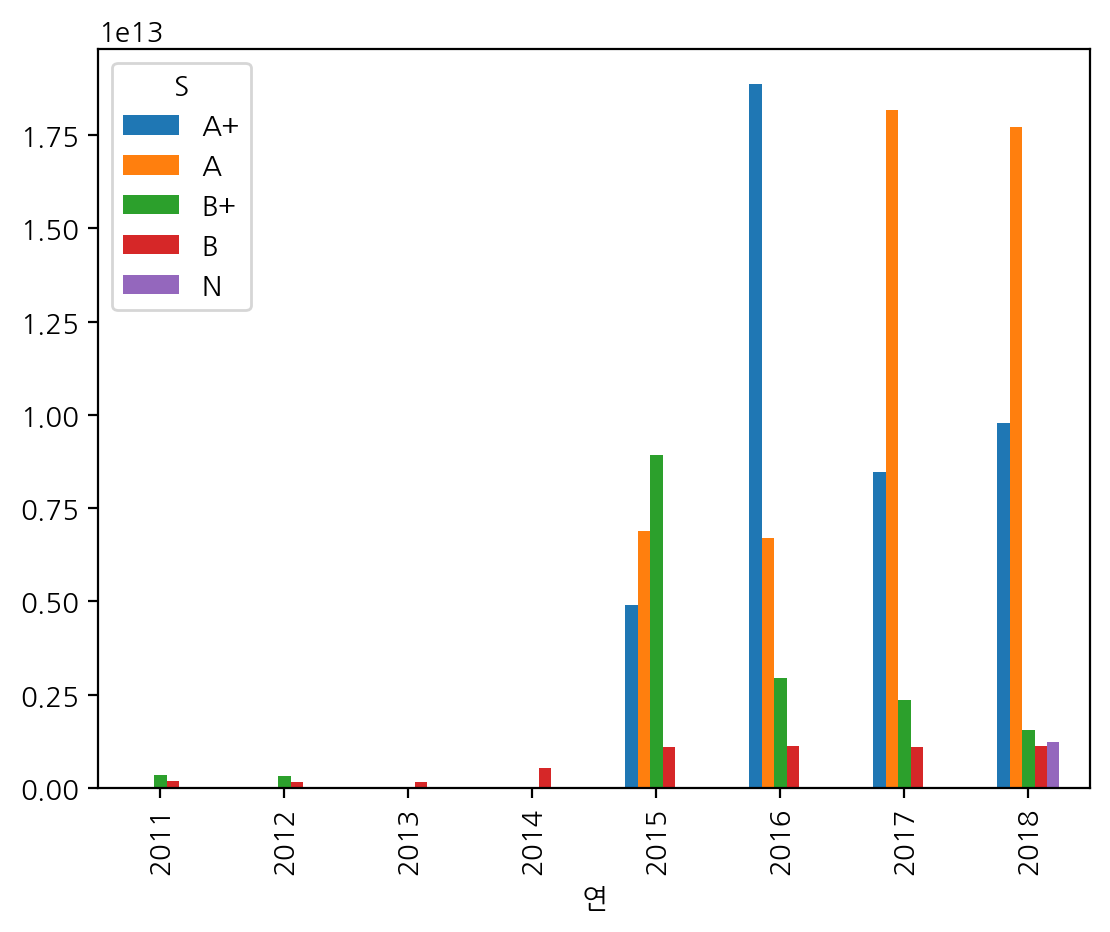

---------- ---------- ---------- ---------- ---------- 

기업총자본금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  3.337760e+11  2.654625e+11  9.222258e+10
2012           NaN           NaN  3.173350e+11  1.547800e+11           NaN
2013           NaN           NaN           NaN  1.721892e+11           NaN
2014           NaN           NaN  6.528007e+11  3.721815e+11           NaN
2015  5.876146e+13  6.937091e+12  3.013685e+12  8.715264e+11           NaN
2016  4.174951e+12  1.186255e+13  2.640388e+12  9.945262e+11           NaN
2017  4.038867e+12  1.530504e+13  2.065595e+12  1.256358e+12           NaN
2018  1.091574e+13  1.617403e+13  3.677726e+12  1.108535e+12  1.237056e+12

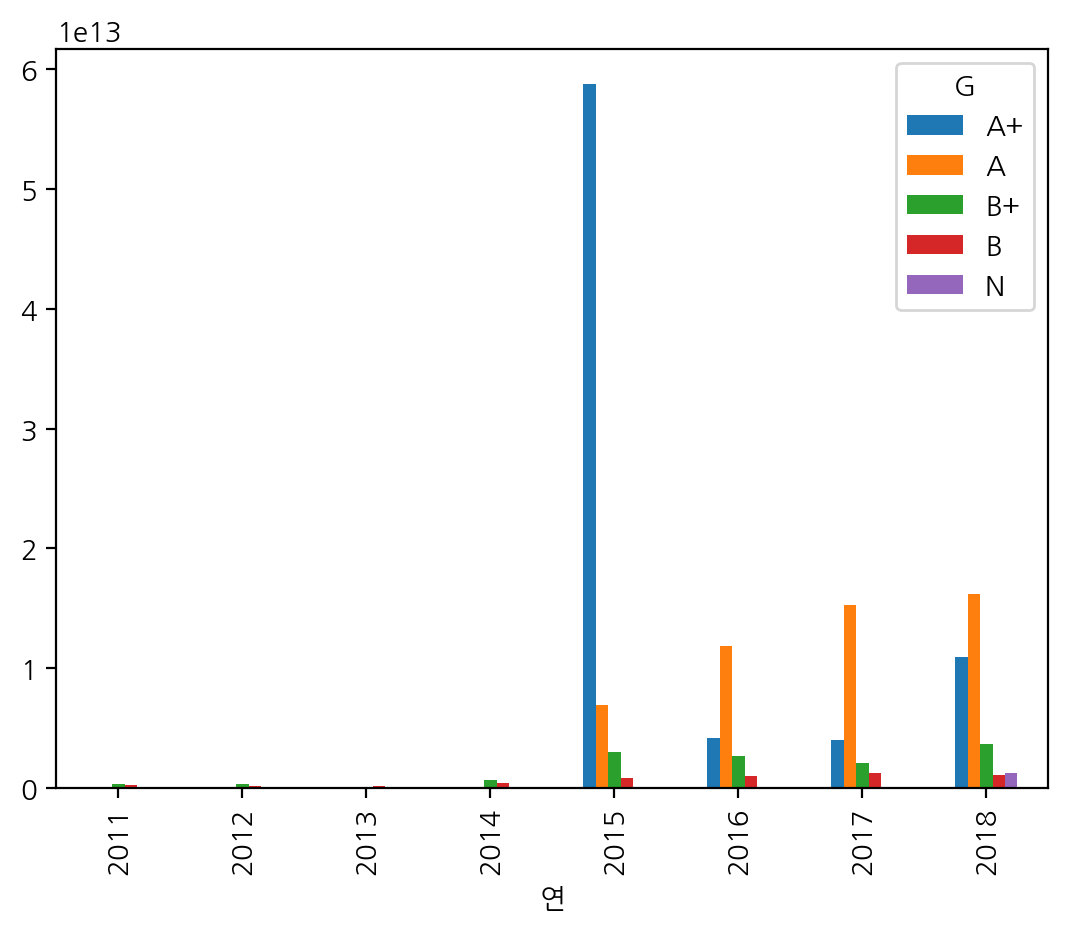

---------- ---------- ---------- ---------- ---------- 

기업자본금액
ESG종합


ESG종합            A+             A            B+             B             N
연                                                                          
2011            NaN           NaN  3.708000e+10  2.029209e+10           NaN
2012            NaN           NaN  3.708000e+10  4.339850e+10           NaN
2013            NaN           NaN           NaN  2.599620e+10           NaN
2014            NaN           NaN  1.393590e+11  1.700102e+11           NaN
2015            NaN  7.409488e+10  6.769916e+10  3.785247e+10           NaN
2016   1.618379e+11  7.917872e+10  8.990380e+10  3.257035e+10           NaN
2017   2.316335e+11  5.393329e+11  2.552180e+11  8.324826e+10           NaN
2018   9.266694e+10  5.493579e+11  2.958389e+11  6.614798e+10  7.020085e+10

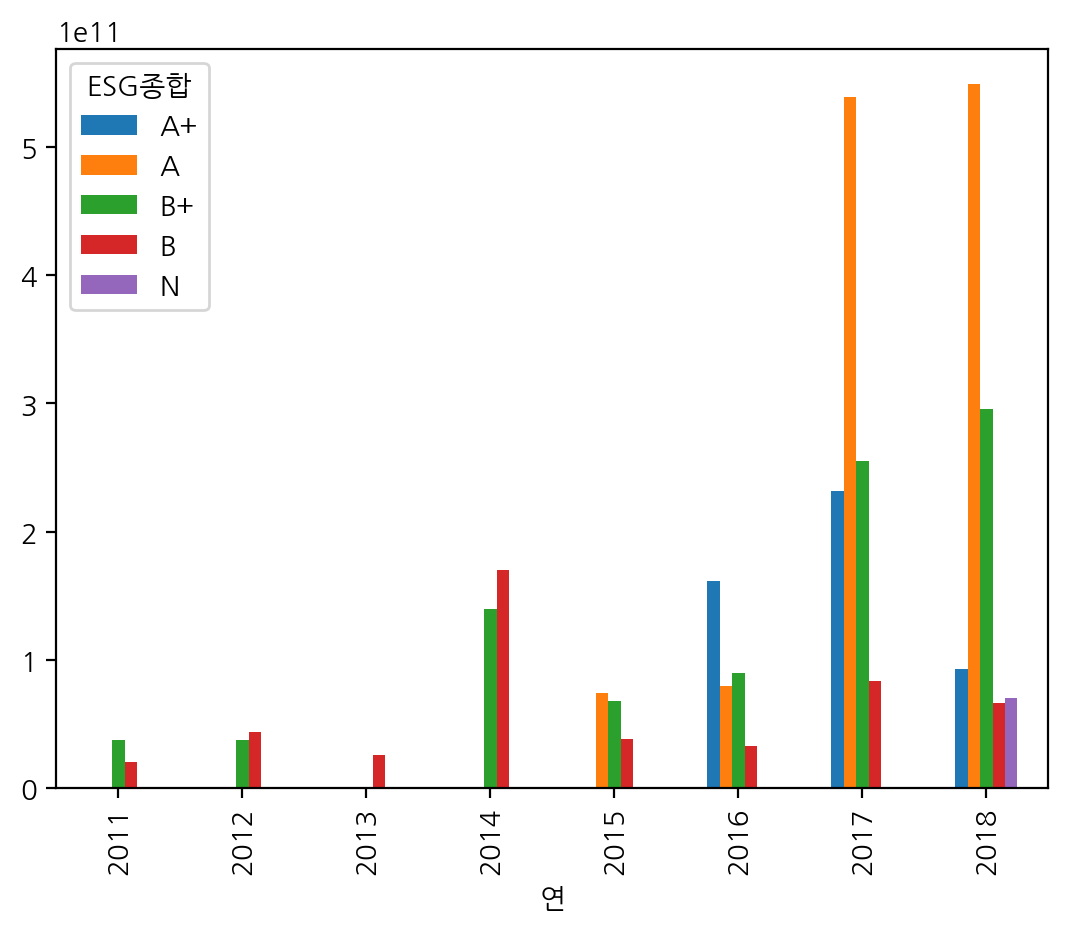

---------- ---------- ---------- ---------- ---------- 

기업자본금액
E


E               A+             A            B+             B             C  \
연                                                                            
2011           NaN           NaN           NaN  2.637034e+10  1.276700e+10   
2012           NaN           NaN           NaN  3.301750e+10  5.784200e+10   
2013           NaN           NaN           NaN  5.896603e+09  3.604600e+10   
2014           NaN           NaN  1.393590e+11           NaN  1.700102e+11   
2015           NaN  2.989454e+10  8.284137e+10  3.326457e+10  4.018032e+10   
2016  1.213784e+11  5.101835e+10  6.986962e+10  5.027729e+10  4.299928e+10   
2017  1.534485e+11  4.846690e+11  2.446749e+11  8.976180e+10  1.208745e+11   
2018  1.171787e+11  2.623173e+11  3.294925e+11  1.240828e+11  6.988694e+10   

E                D  
연                   
2011           NaN  
2012           NaN  
2013           NaN  
2014           NaN  
2015  1.181710e+11  
2016  3.384365e+10  
2017  1.049317e+11  
2018  1.788464e+10

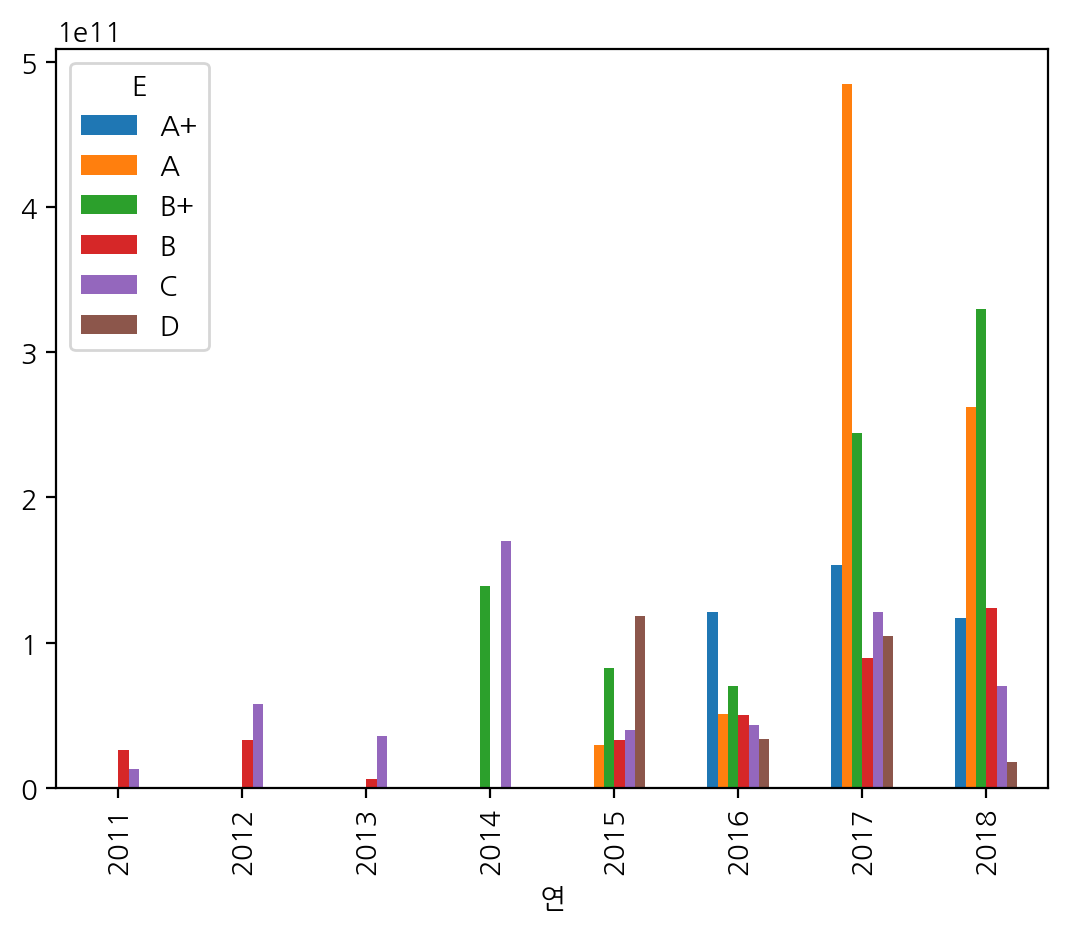

---------- ---------- ---------- ---------- ---------- 

기업자본금액
S


S               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  3.708000e+10  2.029209e+10           NaN
2012           NaN           NaN  3.708000e+10  4.339850e+10           NaN
2013           NaN           NaN           NaN  2.599620e+10           NaN
2014           NaN           NaN           NaN  1.638799e+11           NaN
2015  2.856285e+10  1.009109e+11  6.227143e+10  3.470958e+10           NaN
2016  6.884412e+10  1.724779e+11  5.970214e+10  3.370607e+10           NaN
2017  2.336829e+11  5.212126e+11  1.883708e+11  8.352536e+10           NaN
2018  4.567547e+11  3.419966e+11  1.143726e+11  1.156301e+11  7.020085e+10

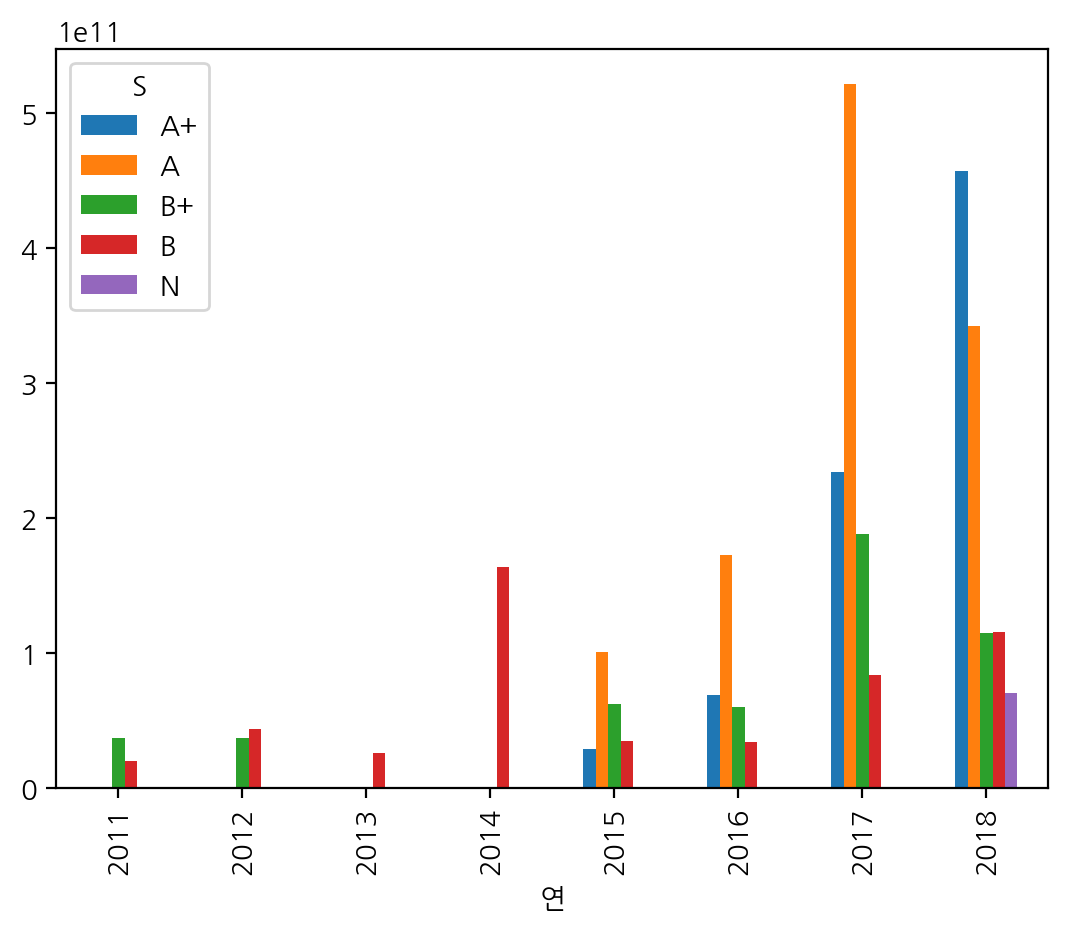

---------- ---------- ---------- ---------- ---------- 

기업자본금액
G


G               A+             A            B+             B             N
연                                                                         
2011           NaN           NaN  3.708000e+10  1.914300e+10  2.144118e+10
2012           NaN           NaN  3.708000e+10  4.339850e+10           NaN
2013           NaN           NaN           NaN  2.599620e+10           NaN
2014           NaN           NaN  2.543413e+11  2.818781e+10           NaN
2015  1.474669e+11  7.512231e+10  7.241333e+10  1.998241e+10           NaN
2016  1.940017e+11  1.211788e+11  6.715979e+10  2.039217e+10           NaN
2017  3.880034e+11  4.669254e+11  1.747598e+11  7.074500e+10           NaN
2018  2.989707e+10  5.117546e+11  2.592749e+11  5.459831e+10  7.020085e+10

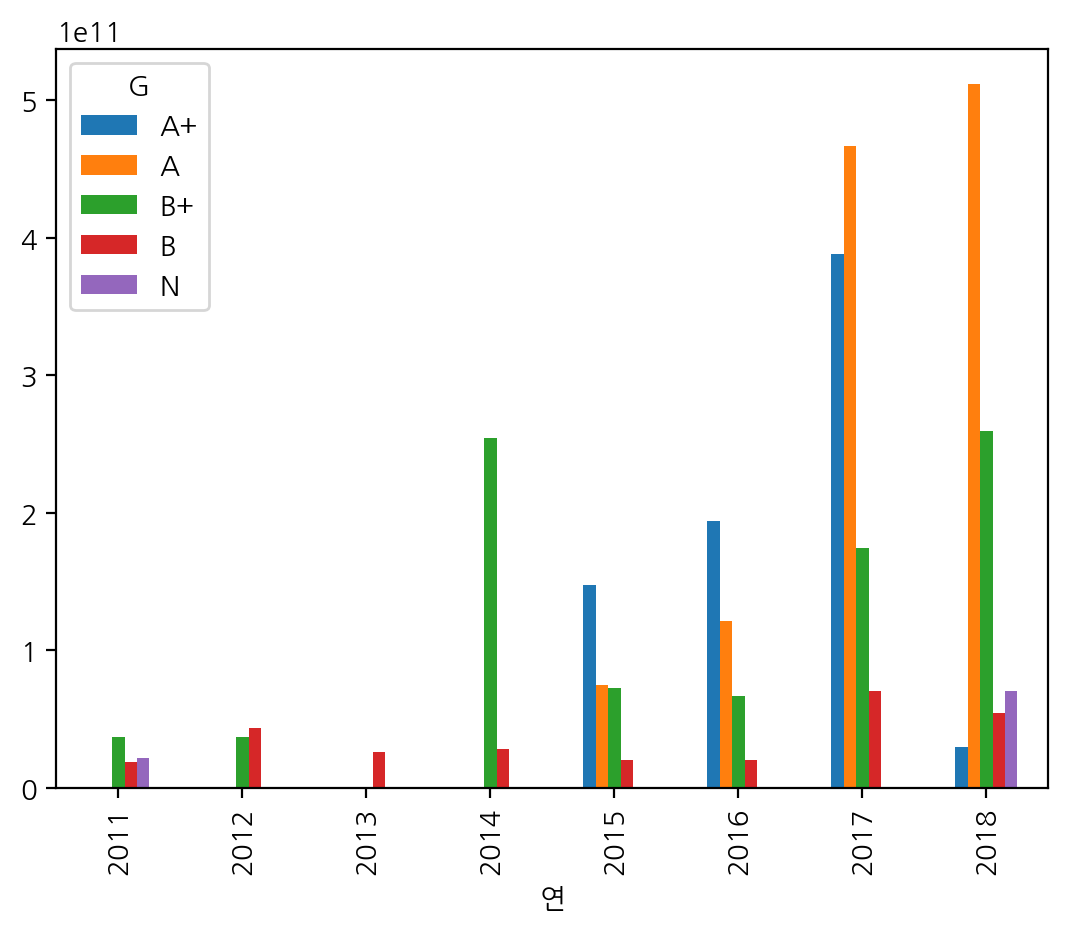

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
ESG종합


ESG종합          A+           A          B+           B          N
연                                                               
2011          NaN         NaN  130.250000  178.578125        NaN
2012          NaN         NaN  161.250000  228.937500        NaN
2013          NaN         NaN         NaN -681.500000        NaN
2014          NaN         NaN  117.687500  977.031250        NaN
2015          NaN   83.914963  212.078369   97.535484        NaN
2016    91.174477   80.663460  240.167191   79.126282        NaN
2017    92.322914  129.691772  107.980049   91.043571        NaN
2018   102.542969  130.739151   92.299828   85.430435  29.271484

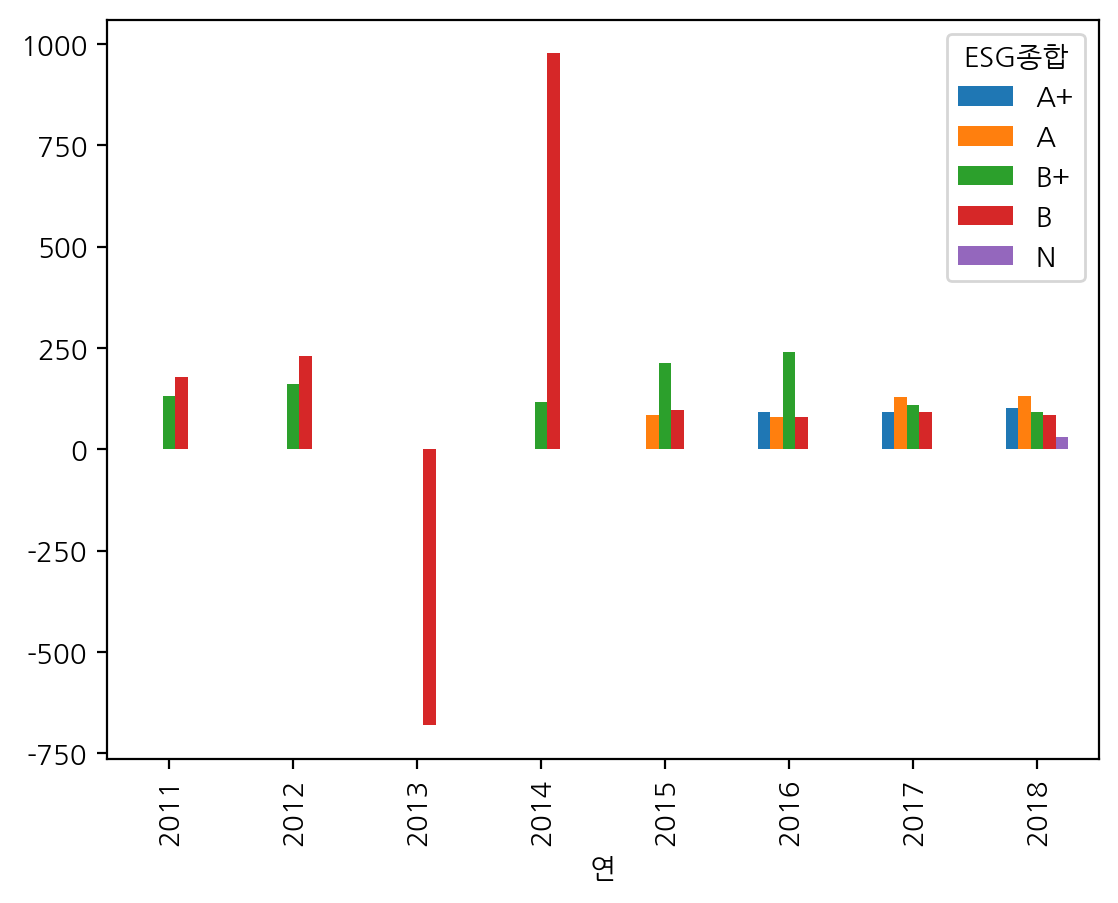

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
E


E             A+           A          B+            B           C           D
연                                                                            
2011         NaN         NaN         NaN   183.531250  110.437500         NaN
2012         NaN         NaN         NaN   216.375000  186.375000         NaN
2013         NaN         NaN         NaN -2400.000000  177.750000         NaN
2014         NaN         NaN  117.687500          NaN  977.031250         NaN
2015         NaN   66.531693  113.056671   147.828979   92.519165  352.830353
2016   79.513672   95.774956  100.361092    89.745621  203.710159   76.689453
2017  110.664062   91.242531  112.063782    95.562798   86.399200   90.762817
2018  108.828125  148.973251   93.021957    94.126282   67.371887   71.643471

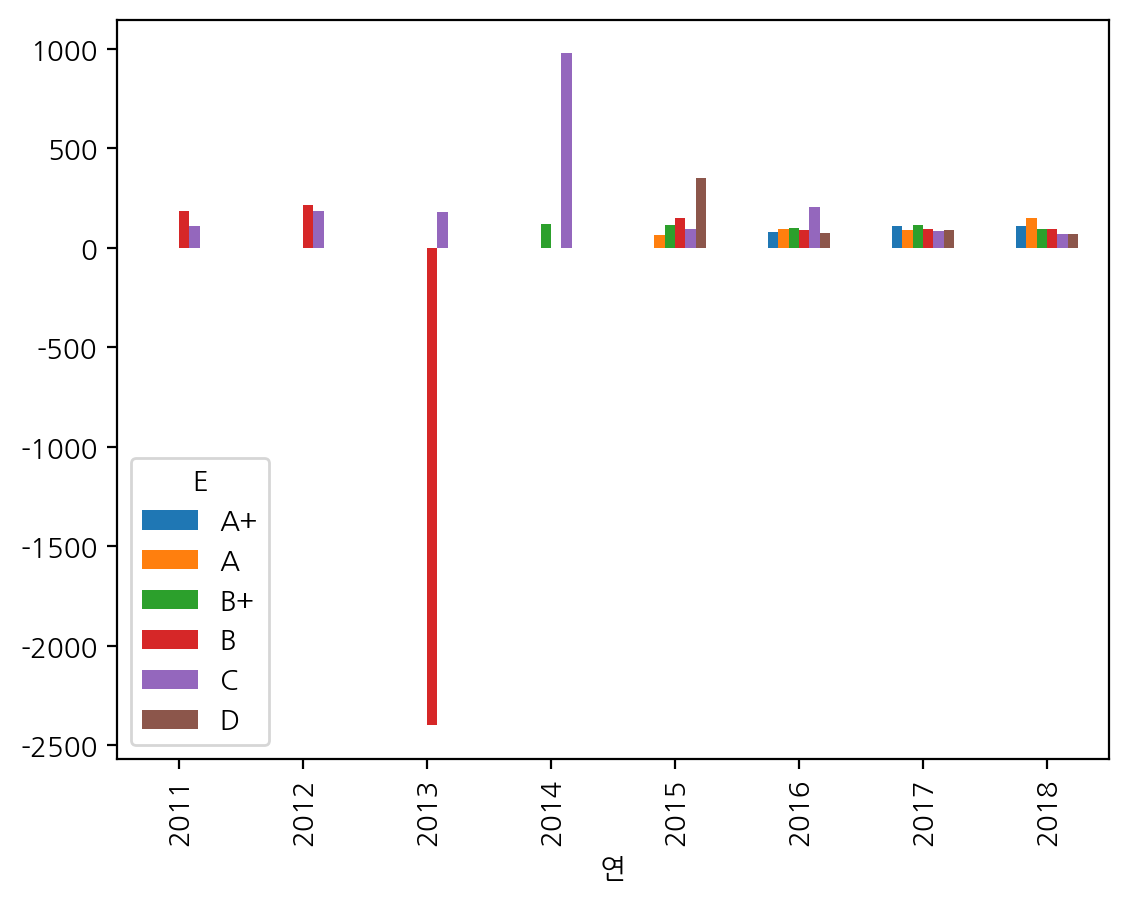

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
S


S             A+           A          B+           B          N
연                                                              
2011         NaN         NaN  130.250000  178.578125        NaN
2012         NaN         NaN  161.250000  228.937500        NaN
2013         NaN         NaN         NaN -681.500000        NaN
2014         NaN         NaN         NaN  805.162476        NaN
2015   82.432289  100.429443  145.791428  117.555237        NaN
2016   99.254166   79.044083  206.535599   81.058731        NaN
2017  119.618370   91.865341  145.888474   75.182869        NaN
2018  106.624565  121.633202   77.102509   93.023399  29.271484

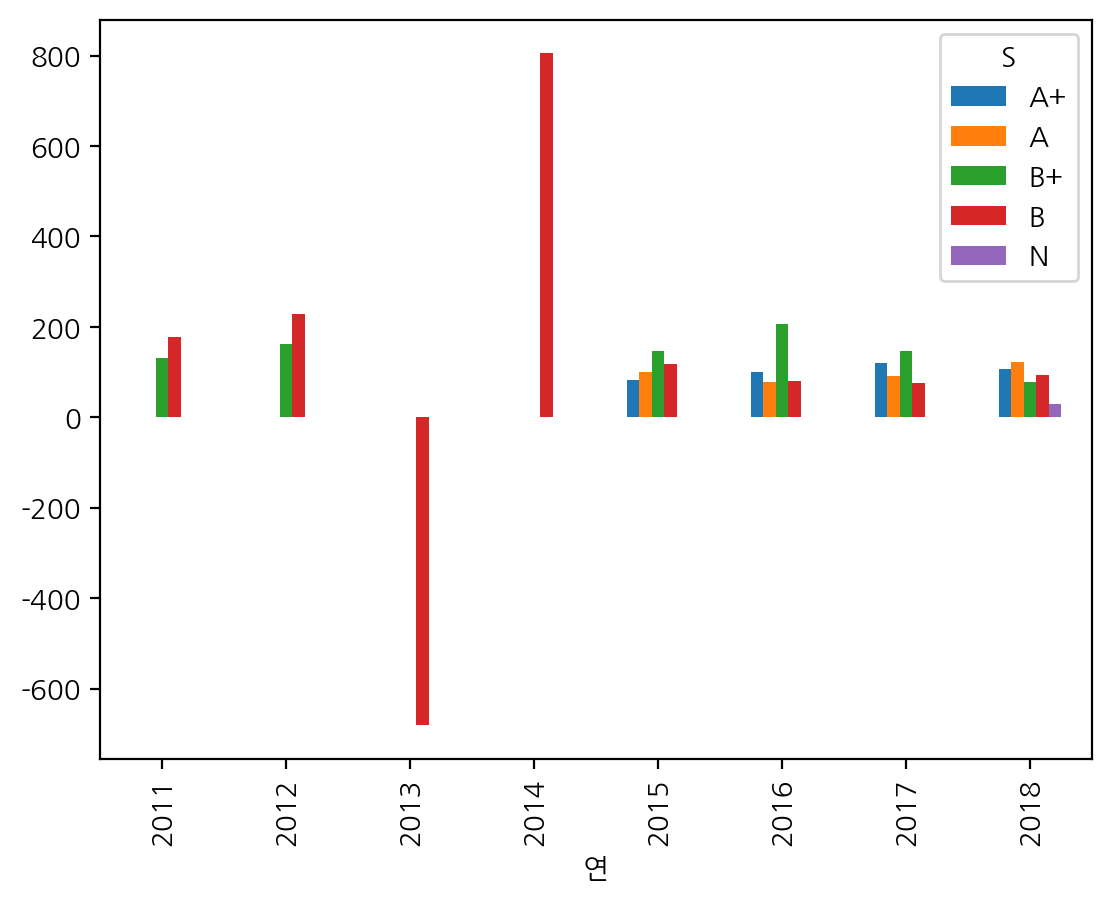

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율
G


G            A+           A           B+           B           N
연                                                               
2011        NaN         NaN   130.250000  202.218750  154.937500
2012        NaN         NaN   161.250000  228.937500         NaN
2013        NaN         NaN          NaN -681.500000         NaN
2014        NaN         NaN  1268.229126  110.562500         NaN
2015  38.611980  307.666931   103.405281   79.700706         NaN
2016  51.554688  275.046631    98.306686   77.085541         NaN
2017  55.640625  138.704178   107.667023   81.991943         NaN
2018  98.156250  121.418045   113.523323   73.960533   29.271484

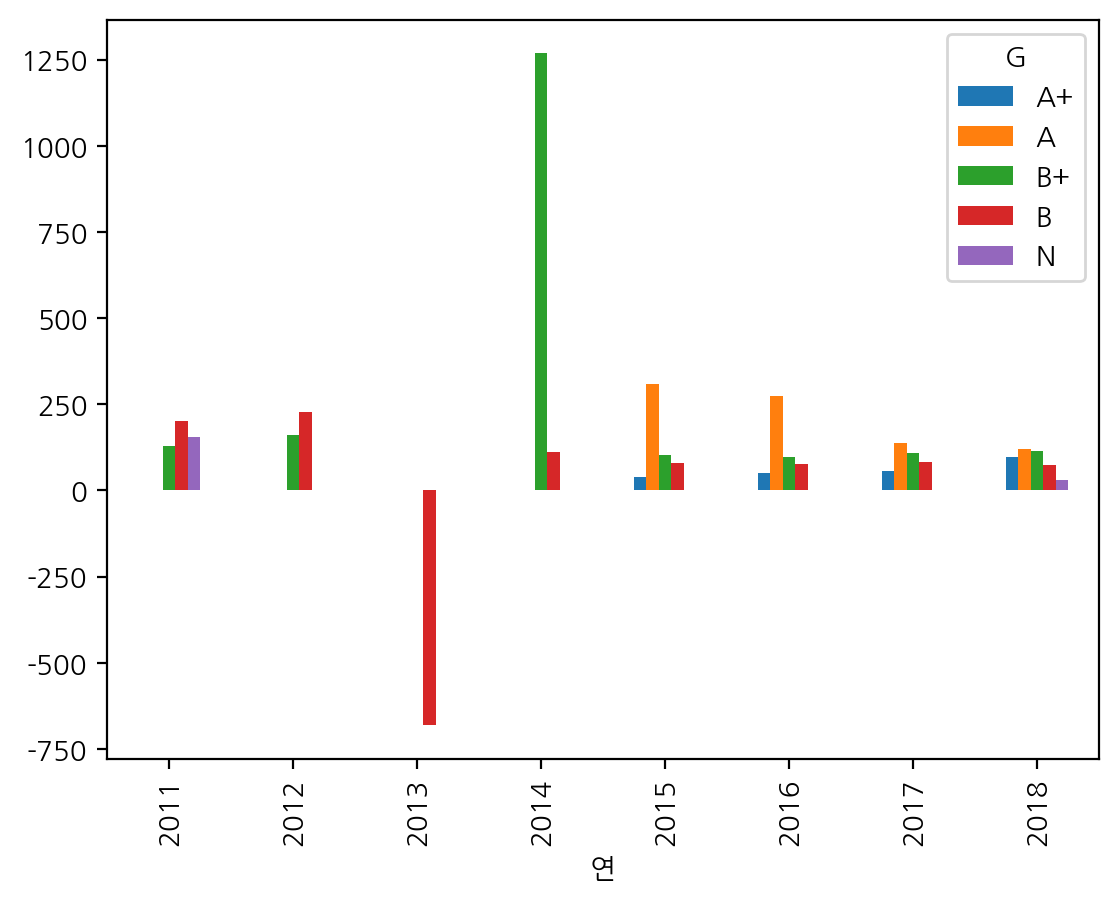

---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.929199  0.462463       NaN
2012        NaN       NaN  0.851074  0.019806       NaN
2013        NaN       NaN       NaN  0.120768       NaN
2014        NaN       NaN  0.450684  0.087032       NaN
2015        NaN  0.370268  0.365568  0.377021       NaN
2016   0.290894  0.408612  0.445391  0.427253       NaN
2017   0.436839  0.523007  0.514130  0.491950       NaN
2018   0.681452  0.559387  0.546681  0.565614  0.291303

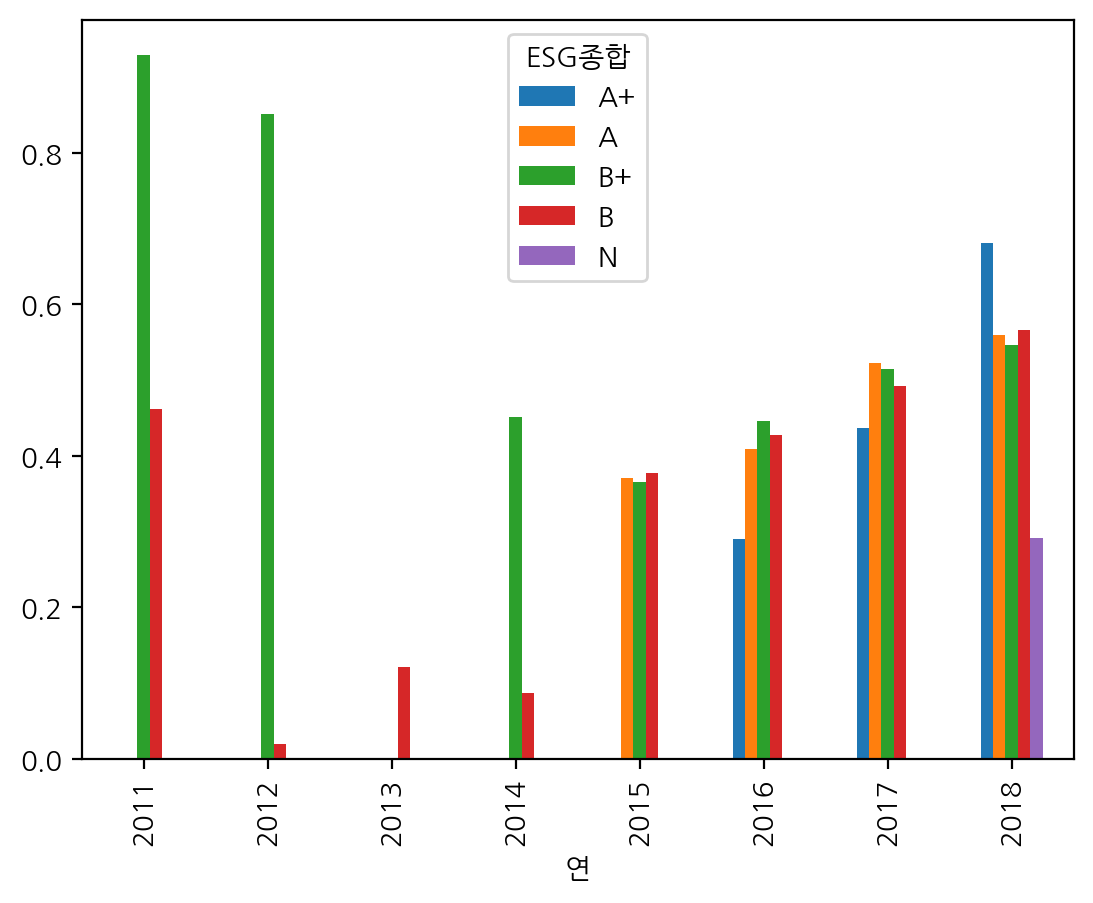

---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.444763  1.000000       NaN
2012       NaN       NaN       NaN  0.445343  0.000000       NaN
2013       NaN       NaN       NaN  0.000000  0.181152       NaN
2014       NaN       NaN  0.450684       NaN  0.087032       NaN
2015       NaN  0.351948  0.437802  0.338131  0.381033  0.365322
2016  0.308014  0.425760  0.398780  0.455589  0.408885  0.463651
2017  0.479614  0.546200  0.502688  0.504172  0.474160  0.458963
2018  0.652499  0.536405  0.555445  0.574194  0.521602  0.571013

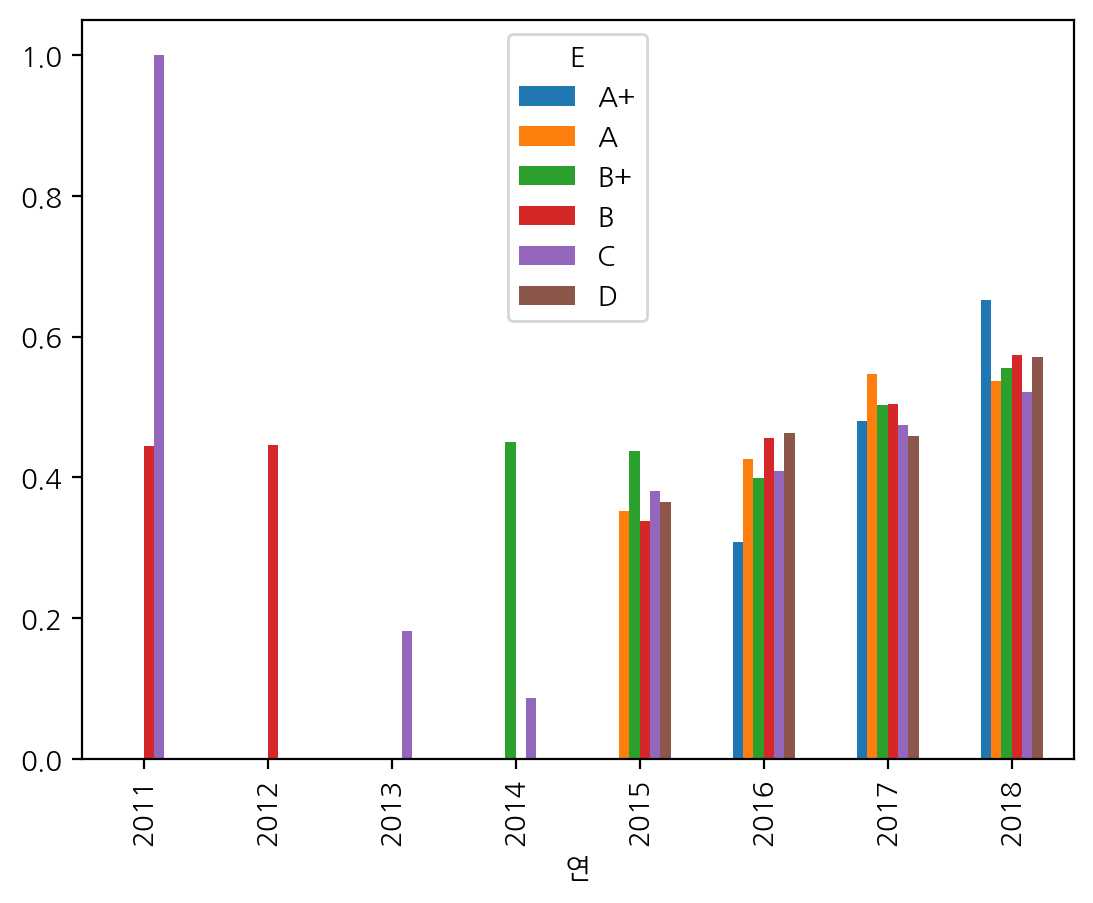

---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.929199  0.462463       NaN
2012       NaN       NaN  0.851074  0.019806       NaN
2013       NaN       NaN       NaN  0.120768       NaN
2014       NaN       NaN       NaN  0.159763       NaN
2015  0.234060  0.338591  0.388069  0.377993       NaN
2016  0.380713  0.477375  0.416868  0.436547       NaN
2017  0.475014  0.519133  0.533306  0.484262       NaN
2018  0.595277  0.602086  0.531892  0.563502  0.291303

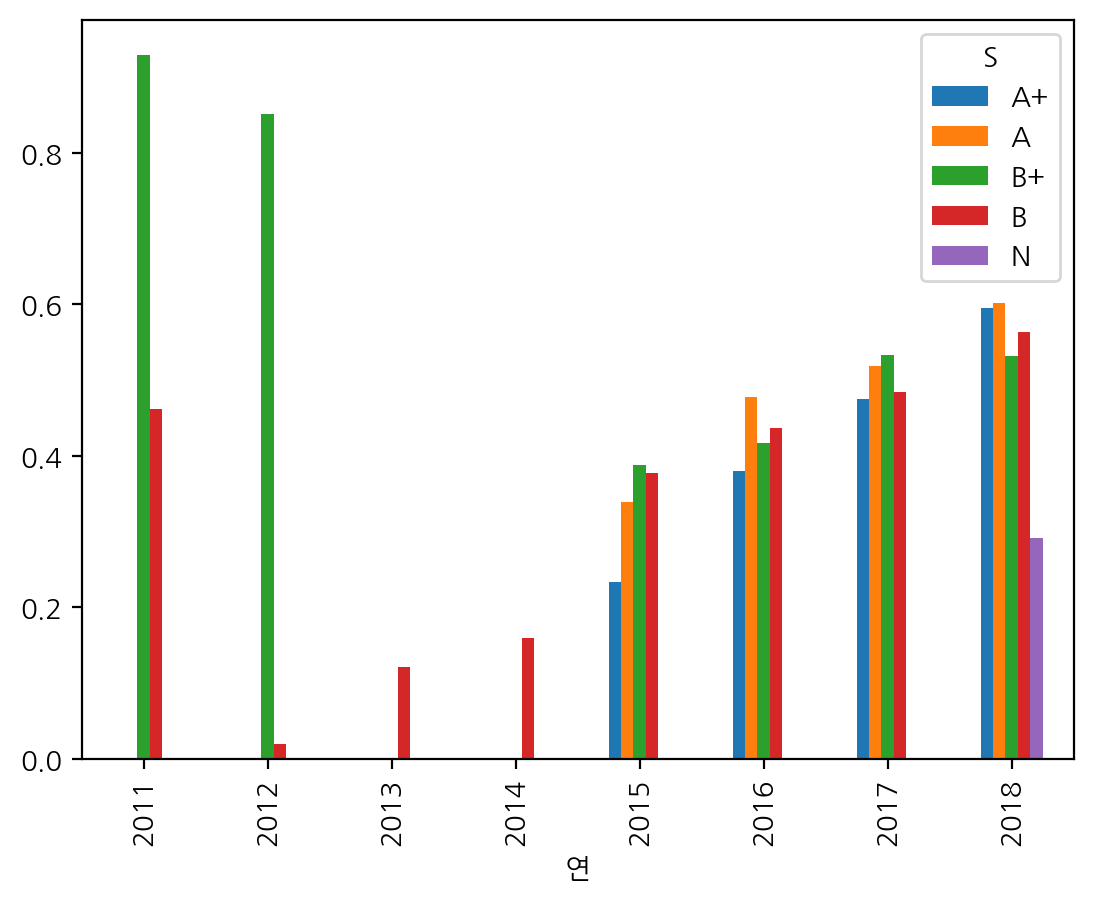

---------- ---------- ---------- ---------- ---------- 

기업매출금액_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.929199  0.751221  0.173706
2012       NaN       NaN  0.851074  0.019806       NaN
2013       NaN       NaN       NaN  0.120768       NaN
2014       NaN       NaN  0.157221  0.163574       NaN
2015  0.367153  0.388565  0.378006  0.367325       NaN
2016  0.191650  0.446103  0.395964  0.439543       NaN
2017  0.351288  0.485398  0.526181  0.490925       NaN
2018  0.741394  0.509982  0.601925  0.552289  0.291303

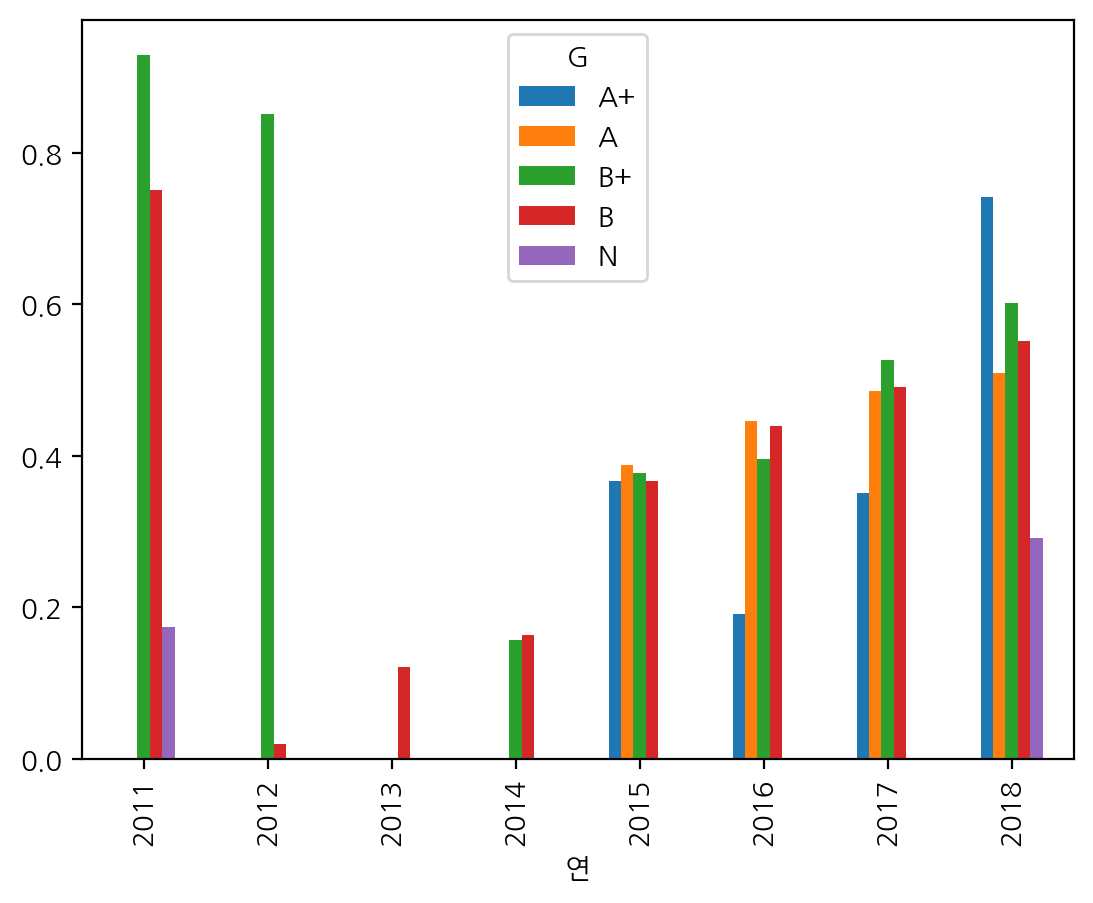

---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
ESG종합


ESG종합        A+         A        B+         B        N
연                                                     
2011        NaN       NaN  0.325684  0.158722      NaN
2012        NaN       NaN  0.000000  0.434570      NaN
2013        NaN       NaN       NaN  0.499430      NaN
2014        NaN       NaN  0.000000  0.195435      NaN
2015        NaN  0.272261  0.313940  0.504145      NaN
2016   0.444194  0.464112  0.516554  0.546630      NaN
2017   0.535075  0.660723  0.544594  0.467854      NaN
2018   0.505719  0.595965  0.436491  0.441088  0.26679

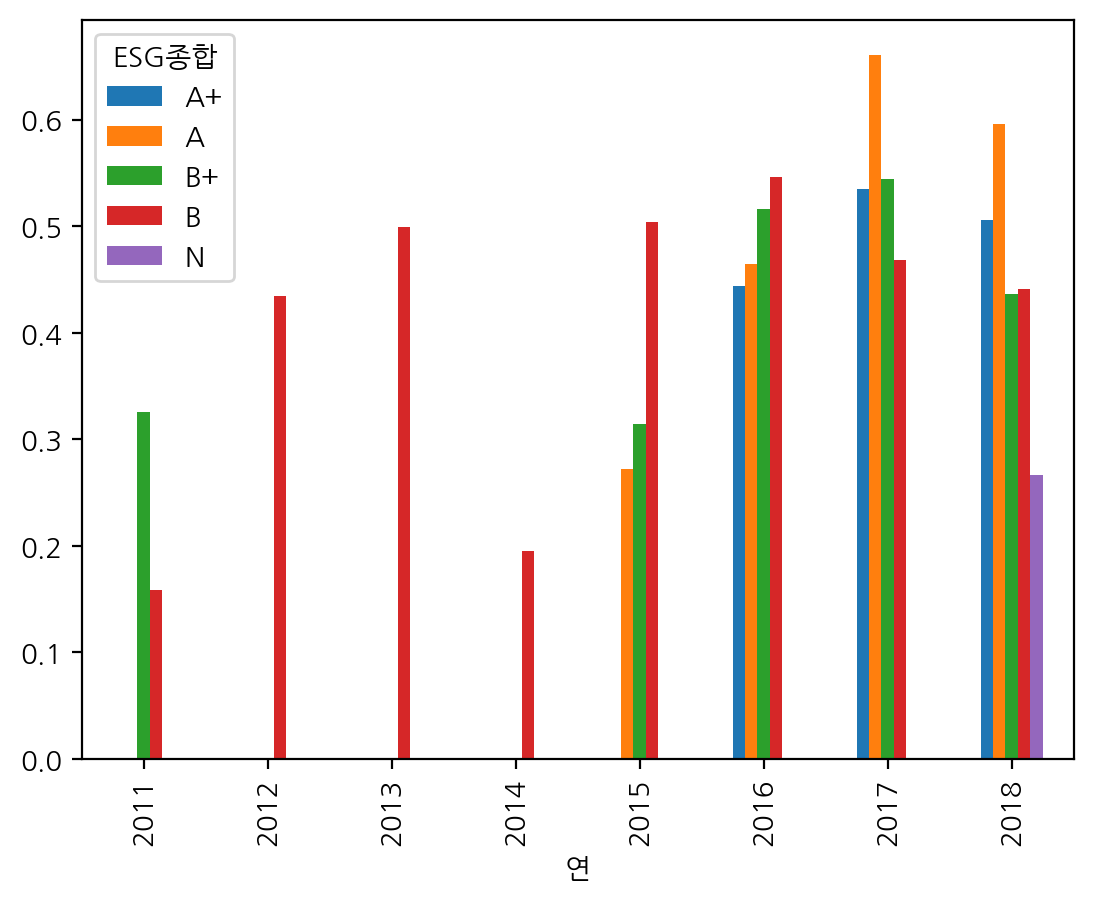

---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.240143  0.000000       NaN
2012       NaN       NaN       NaN  0.000000  0.869141       NaN
2013       NaN       NaN       NaN  0.000000  0.749146       NaN
2014       NaN       NaN  0.000000       NaN  0.195435       NaN
2015       NaN  0.297940  0.384457  0.481428  0.460005  0.559640
2016  0.457901  0.472709  0.486558  0.526437  0.607968  0.421983
2017  0.653595  0.646911  0.560564  0.475385  0.462211  0.322132
2018  0.391008  0.603025  0.518359  0.438020  0.328071  0.549886

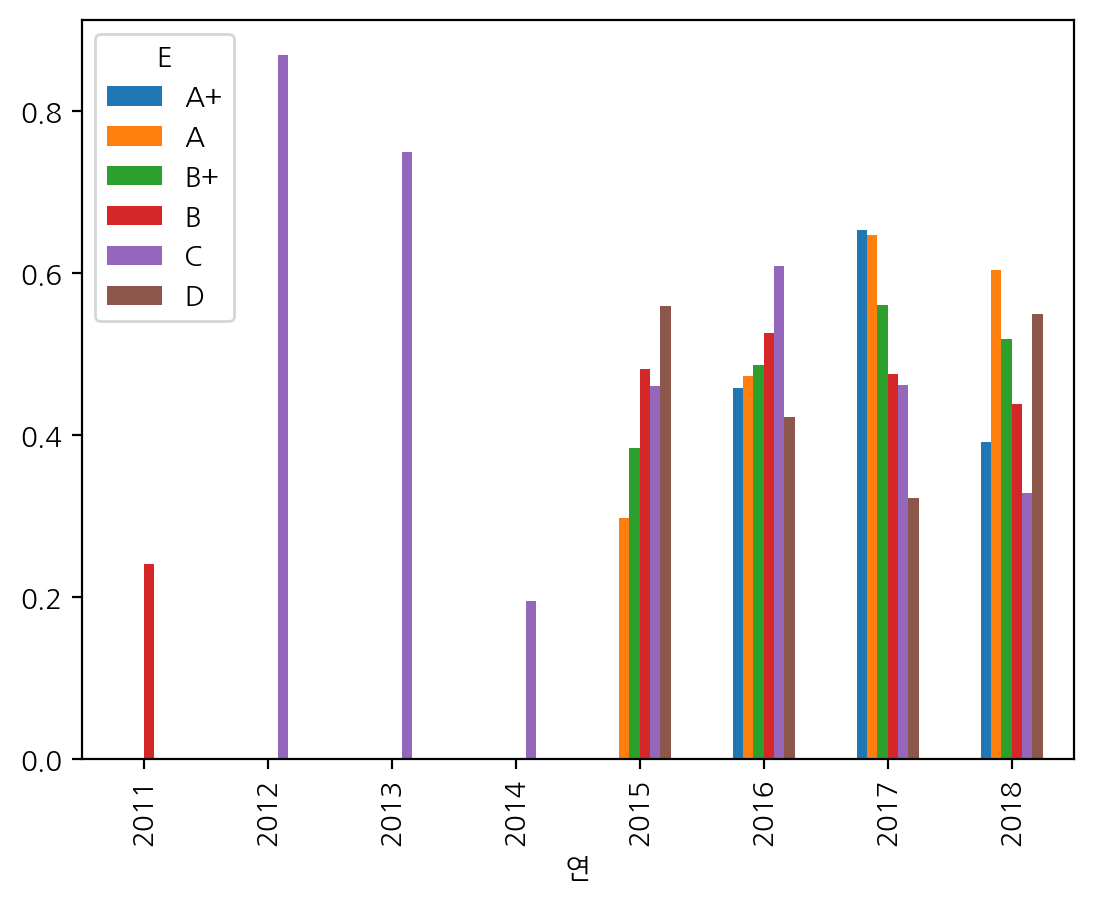

---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
S


S           A+         A        B+         B        N
연                                                    
2011       NaN       NaN  0.325684  0.158722      NaN
2012       NaN       NaN  0.000000  0.434570      NaN
2013       NaN       NaN       NaN  0.499430      NaN
2014       NaN       NaN       NaN  0.156348      NaN
2015  0.154195  0.336623  0.446640  0.466801      NaN
2016  0.454828  0.580028  0.527162  0.539697      NaN
2017  0.657113  0.516950  0.464560  0.495147      NaN
2018  0.554697  0.589432  0.383077  0.453275  0.26679

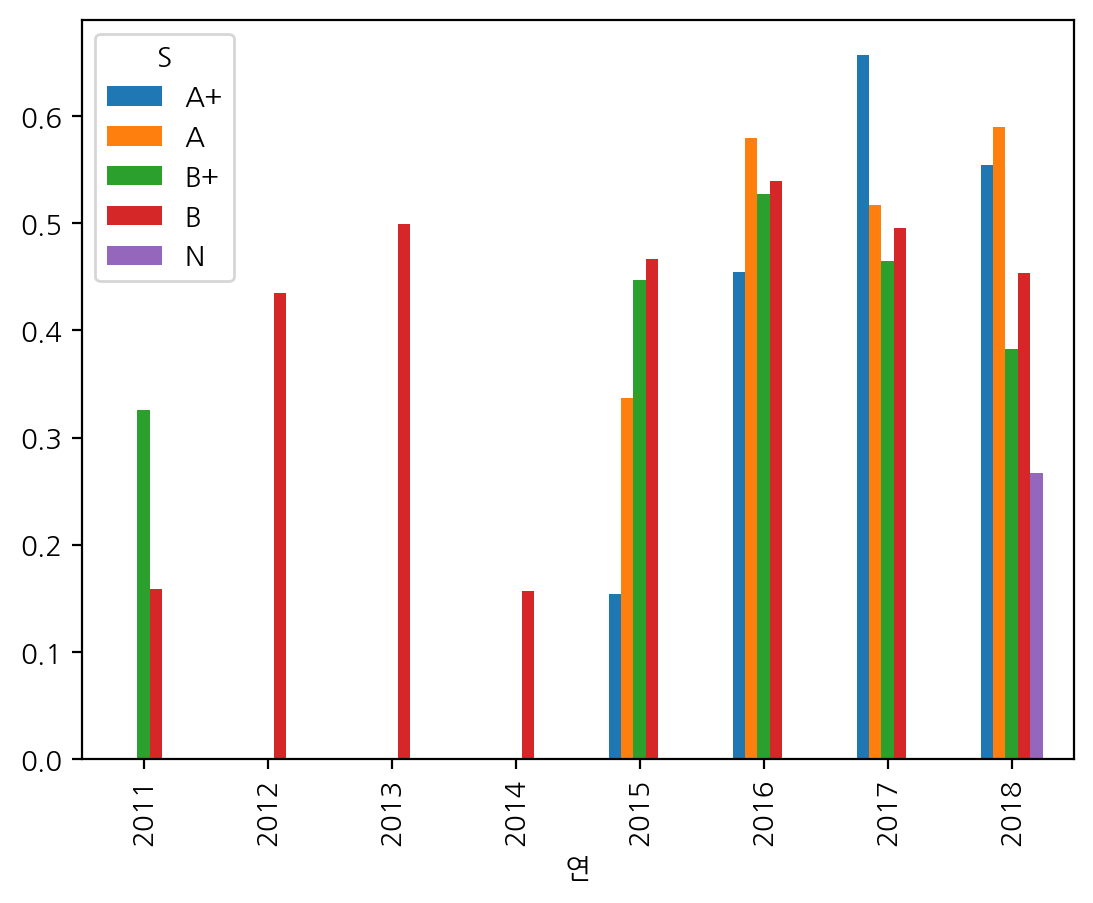

---------- ---------- ---------- ---------- ---------- 

기업영업이익_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.325684  0.244385  0.073059
2012       NaN       NaN  0.000000  0.434570       NaN
2013       NaN       NaN       NaN  0.499430       NaN
2014       NaN       NaN  0.000000  0.390869       NaN
2015  0.245504  0.303929  0.475394  0.474365       NaN
2016  0.108276  0.545034  0.521301  0.535040       NaN
2017  0.298035  0.614901  0.501668  0.474894       NaN
2018  0.866089  0.520523  0.439854  0.448287  0.266790

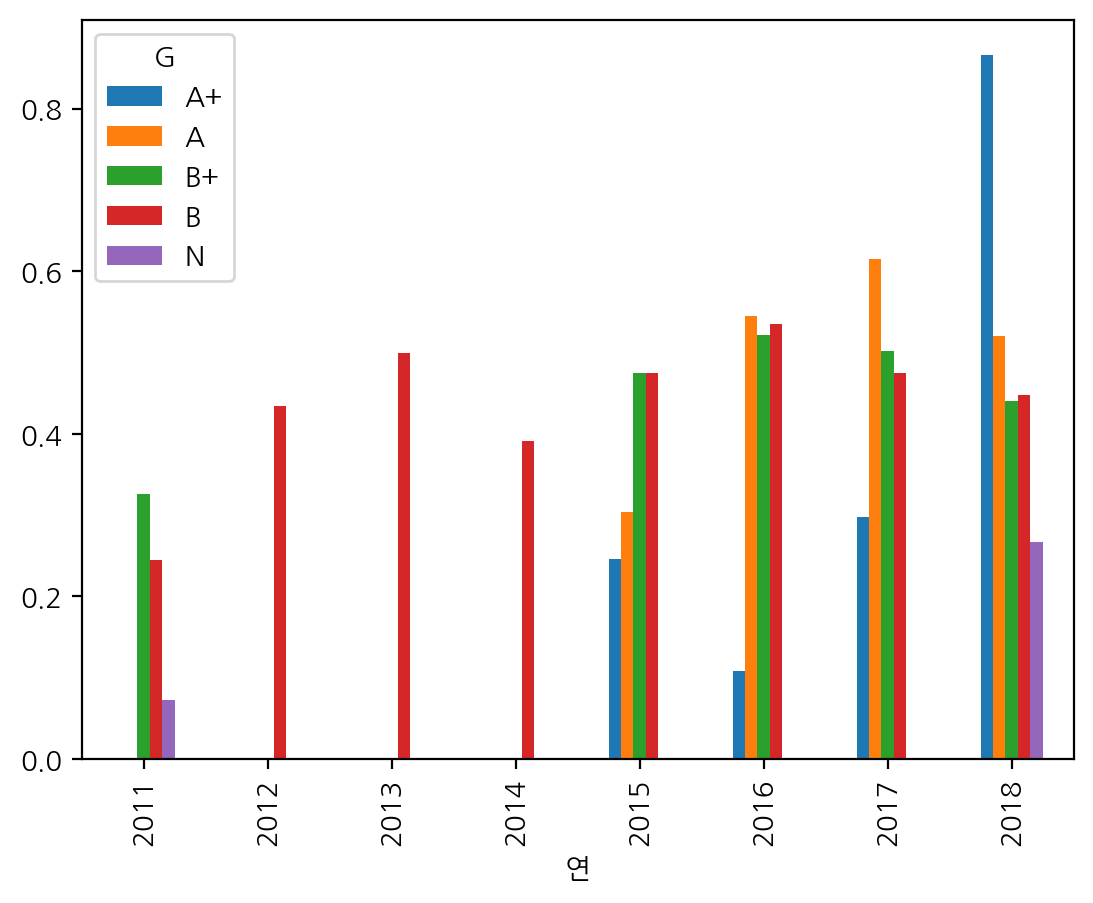

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.036469  0.293488       NaN
2012        NaN       NaN  0.000000  0.000000       NaN
2013        NaN       NaN       NaN  0.429850       NaN
2014        NaN       NaN  0.629395  0.202393       NaN
2015        NaN  0.343411  0.374029  0.510862       NaN
2016   0.389404  0.427775  0.451472  0.566519       NaN
2017   0.561401  0.595086  0.582146  0.479261       NaN
2018   0.480895  0.646365  0.460972  0.426220  0.357422

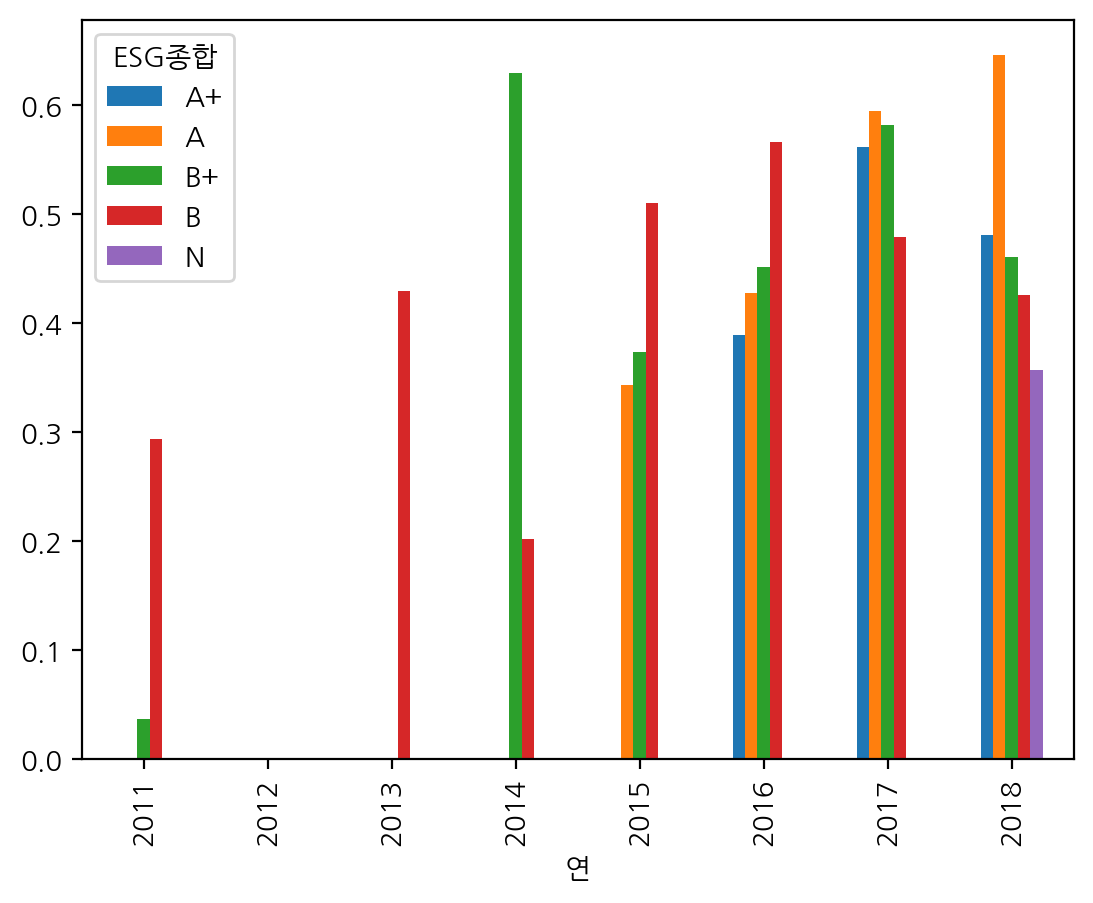

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.302605  0.000000       NaN
2012       NaN       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.000000  0.644775       NaN
2014       NaN       NaN  0.629395       NaN  0.202393       NaN
2015       NaN  0.440145  0.400472  0.479529  0.487508  0.690517
2016  0.388733  0.403332  0.501923  0.517580  0.575361  0.578024
2017  0.746216  0.523455  0.602255  0.459782  0.539128  0.302742
2018  0.408283  0.627632  0.566526  0.410322  0.320904  0.548837

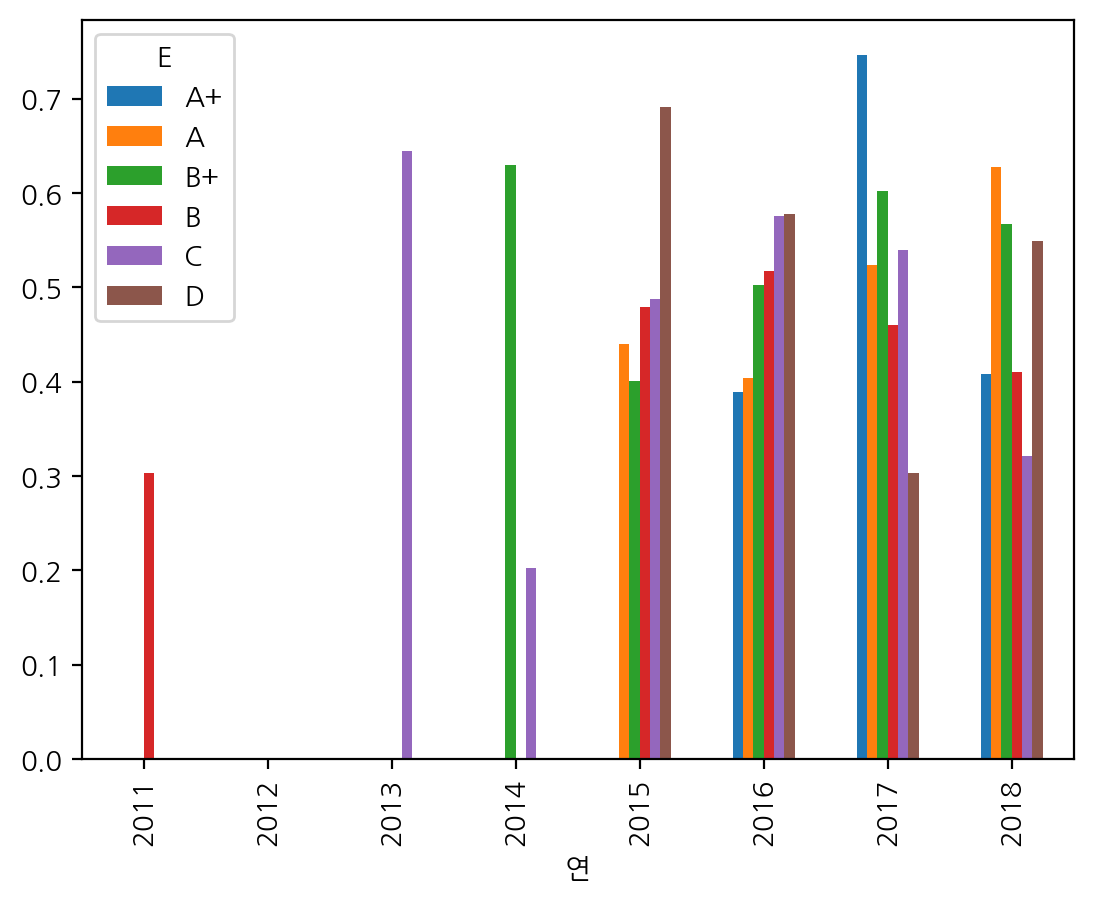

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.036469  0.293488       NaN
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.429850       NaN
2014       NaN       NaN       NaN  0.287793       NaN
2015  0.212097  0.432026  0.478685  0.475924       NaN
2016  0.391592  0.611992  0.464071  0.567720       NaN
2017  0.652542  0.555993  0.493769  0.495234       NaN
2018  0.563235  0.577806  0.385554  0.458967  0.357422

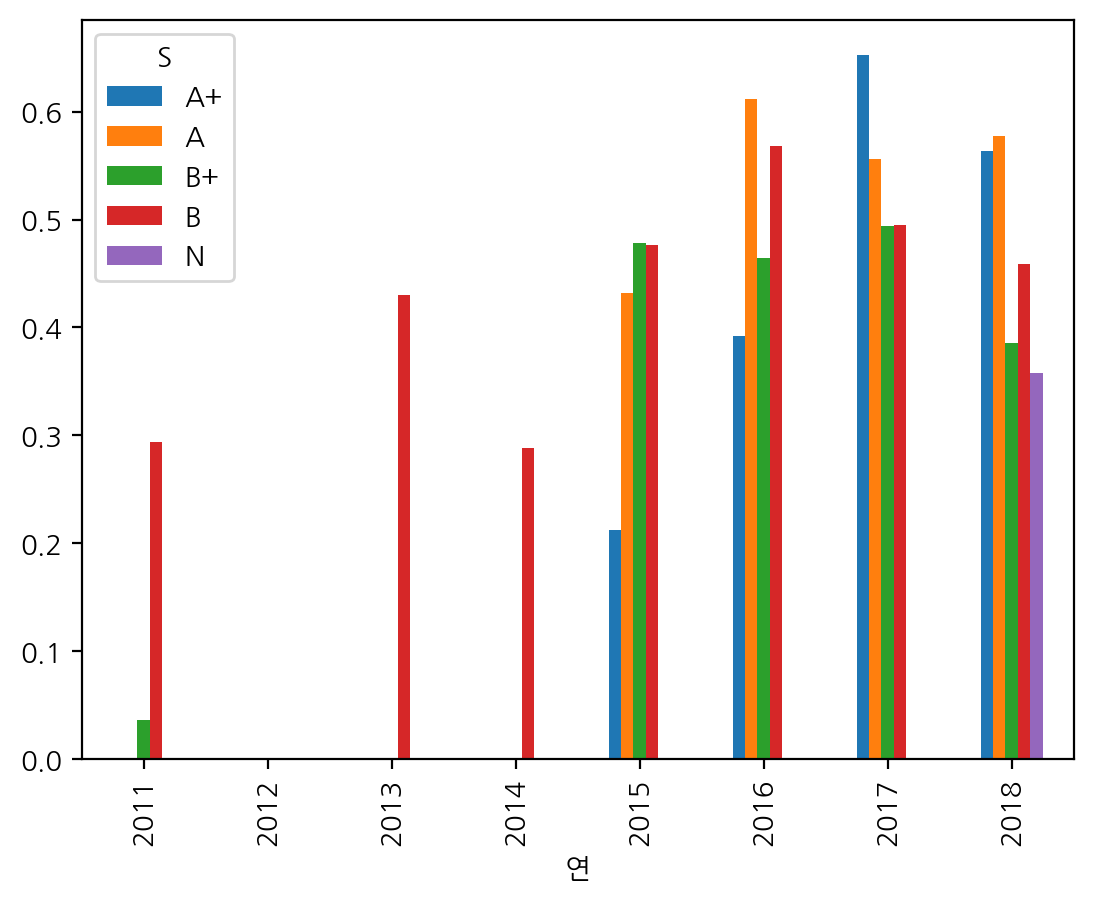

---------- ---------- ---------- ---------- ---------- 

포괄손익계산금액_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.036469  0.092346  0.494629
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.429850       NaN
2014       NaN       NaN  0.209798  0.404785       NaN
2015  0.217753  0.380646  0.503258  0.480915       NaN
2016  0.123901  0.450644  0.535890  0.548083       NaN
2017  0.191772  0.630324  0.522944  0.480205       NaN
2018  0.808716  0.553646  0.437449  0.447110  0.357422

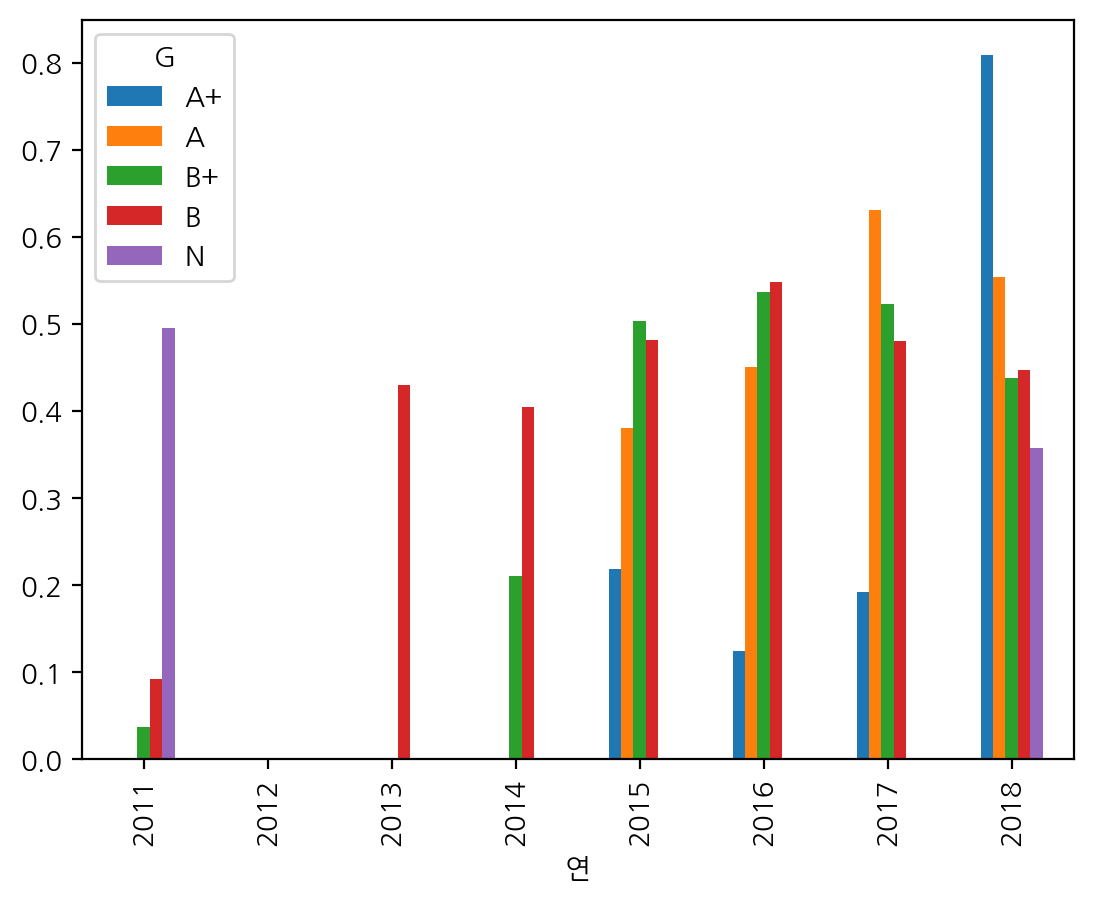

---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.009186  0.405334       NaN
2012        NaN       NaN  0.000000  0.000000       NaN
2013        NaN       NaN       NaN  0.655111       NaN
2014        NaN       NaN  0.587891  0.194336       NaN
2015        NaN  0.290679  0.376783  0.491654       NaN
2016   0.401143  0.453089  0.433027  0.553291       NaN
2017   0.554342  0.585593  0.601419  0.505396       NaN
2018   0.452866  0.578621  0.476630  0.404546  0.065912

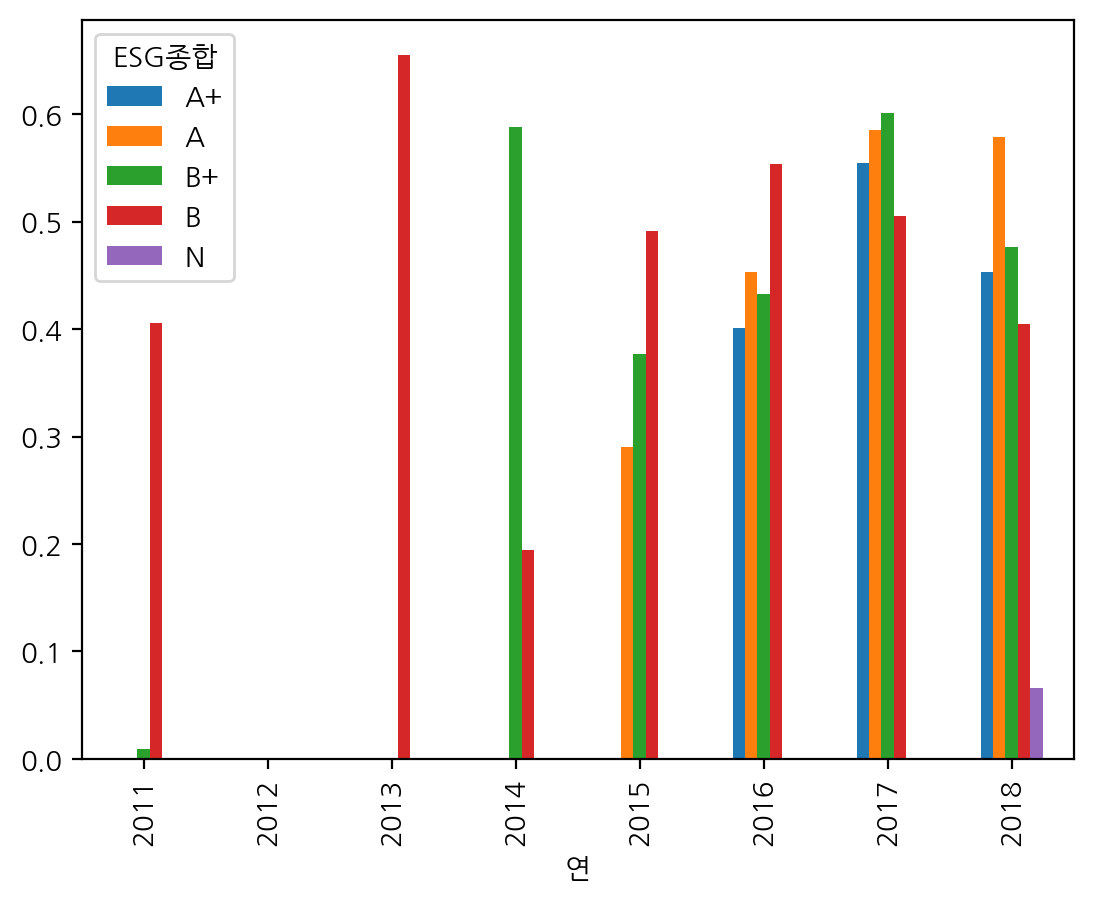

---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.407631  0.000000       NaN
2012       NaN       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.527344  0.718994       NaN
2014       NaN       NaN  0.587891       NaN  0.194336       NaN
2015       NaN  0.392725  0.360238  0.495723  0.451667  0.679105
2016  0.404556  0.362135  0.506304  0.503101  0.587006  0.422073
2017  0.730194  0.533547  0.622178  0.492210  0.563443  0.233473
2018  0.423117  0.490813  0.572199  0.365506  0.345033  0.475415

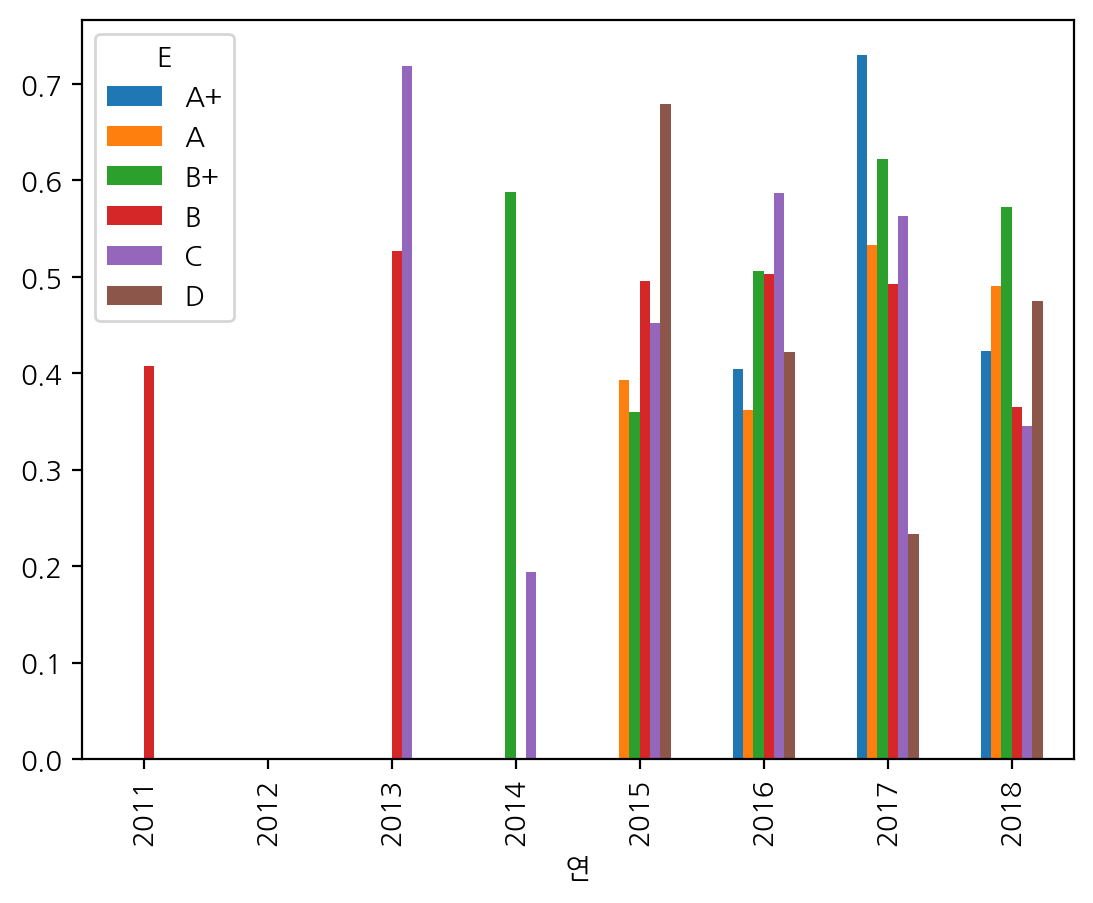

---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.009186  0.405334       NaN
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.655111       NaN
2014       NaN       NaN       NaN  0.273047       NaN
2015  0.210999  0.413972  0.442501  0.465422       NaN
2016  0.410734  0.659445  0.421075  0.562941       NaN
2017  0.637000  0.609412  0.498613  0.523069       NaN
2018  0.535786  0.542978  0.388766  0.432736  0.065912

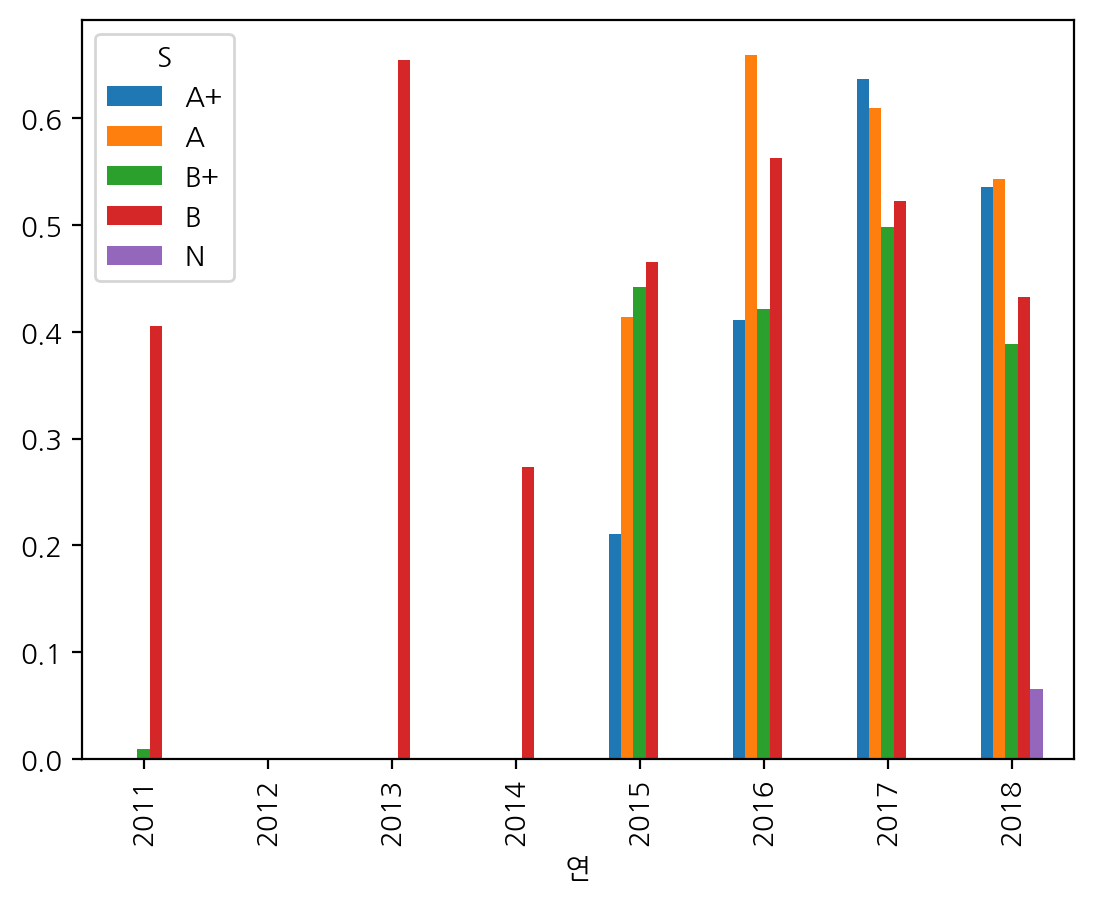

---------- ---------- ---------- ---------- ---------- 

기업당기순이익_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.009186  0.241821  0.568848
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.655111       NaN
2014       NaN       NaN  0.195964  0.388672       NaN
2015  0.087072  0.345893  0.486484  0.473190       NaN
2016  0.173706  0.431021  0.551895  0.526224       NaN
2017  0.202637  0.628511  0.520998  0.519728       NaN
2018  0.729919  0.542588  0.424199  0.424399  0.065912

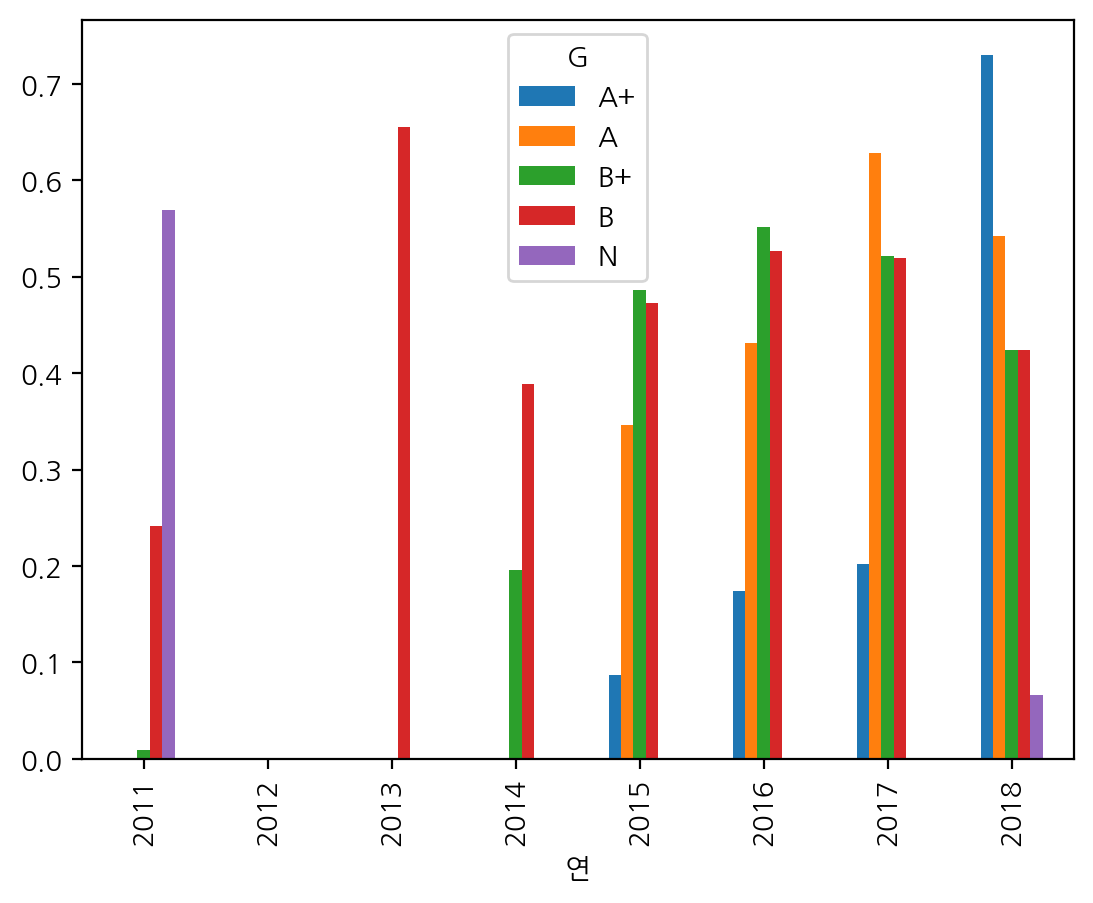

---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
ESG종합


ESG종합        A+         A        B+         B        N
연                                                     
2011        NaN       NaN  0.399170  0.750000      NaN
2012        NaN       NaN  0.937988  0.400635      NaN
2013        NaN       NaN       NaN  0.333333      NaN
2014        NaN       NaN  0.141724  0.142090      NaN
2015        NaN  0.301373  0.338376  0.326495      NaN
2016   0.458852  0.379638  0.419092  0.442723      NaN
2017   0.552292  0.557965  0.500094  0.517775      NaN
2018   0.608982  0.577971  0.598798  0.588767  0.65801

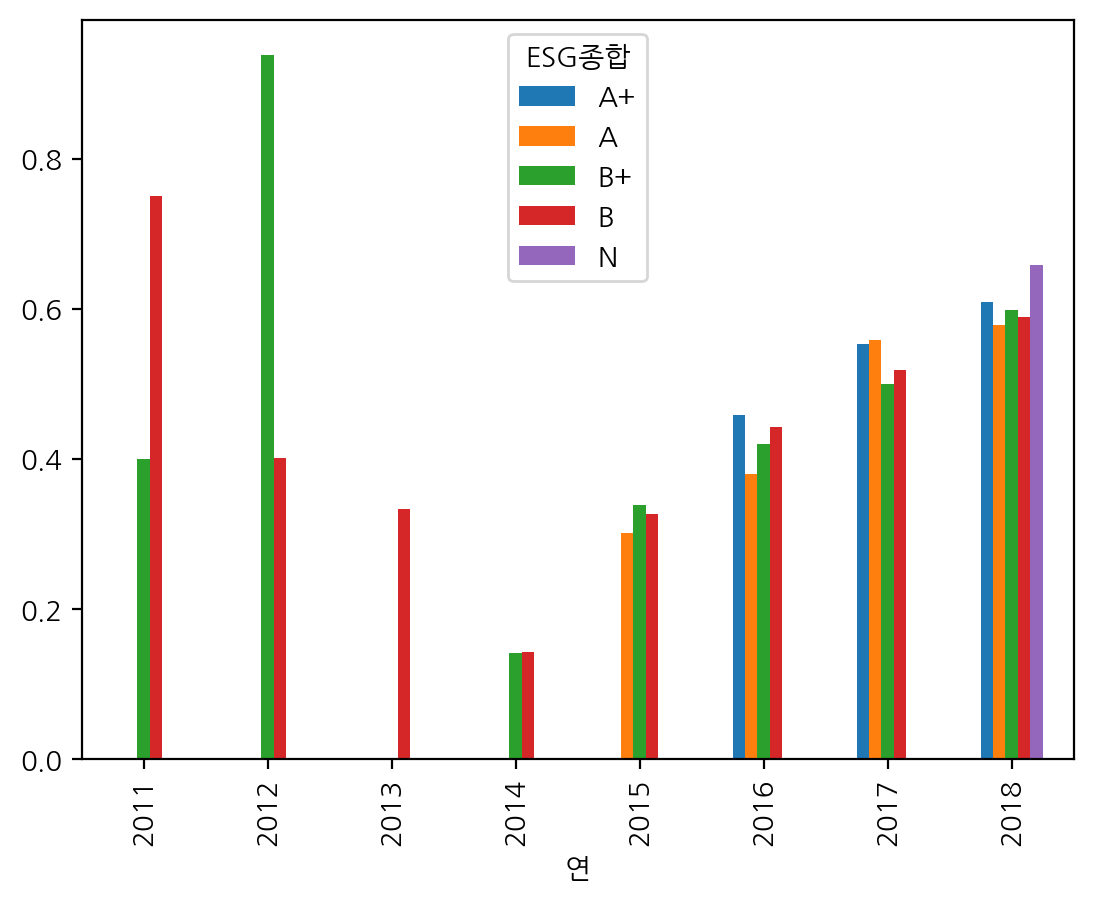

---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.599792  1.000000       NaN
2012       NaN       NaN       NaN  0.558350  0.622559       NaN
2013       NaN       NaN       NaN  0.000000  0.500000       NaN
2014       NaN       NaN  0.141724       NaN  0.142090       NaN
2015       NaN  0.197921  0.369994  0.351239  0.291715  0.414692
2016  0.449669  0.403270  0.393530  0.430170  0.459627  0.479498
2017  0.637764  0.508355  0.523324  0.527022  0.504398  0.430674
2018  0.718307  0.493521  0.591546  0.605016  0.563123  0.695648

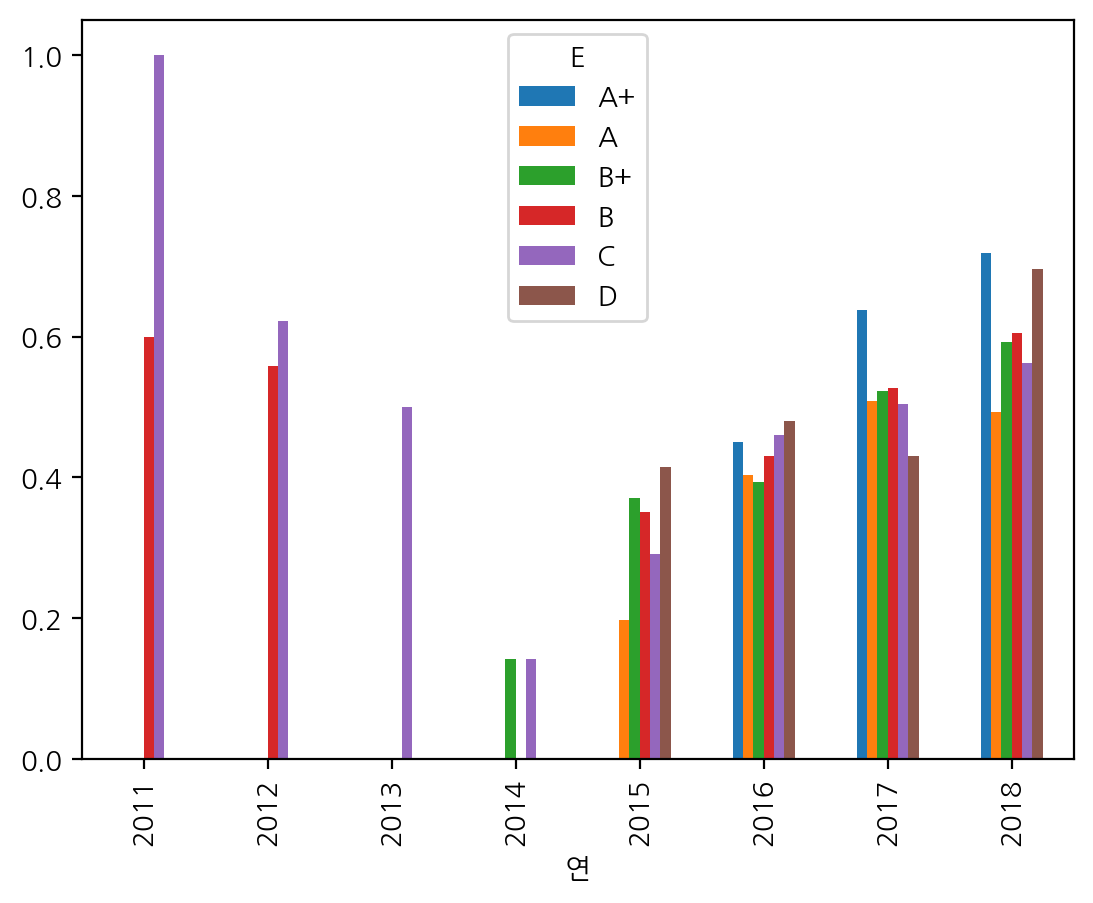

---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
S


S           A+         A        B+         B        N
연                                                    
2011       NaN       NaN  0.399170  0.750000      NaN
2012       NaN       NaN  0.937988  0.400635      NaN
2013       NaN       NaN       NaN  0.333333      NaN
2014       NaN       NaN       NaN  0.142017      NaN
2015  0.106198  0.346768  0.320560  0.332659      NaN
2016  0.444353  0.435446  0.417797  0.438040      NaN
2017  0.531560  0.540786  0.506428  0.516290      NaN
2018  0.619958  0.588688  0.598827  0.576677  0.65801

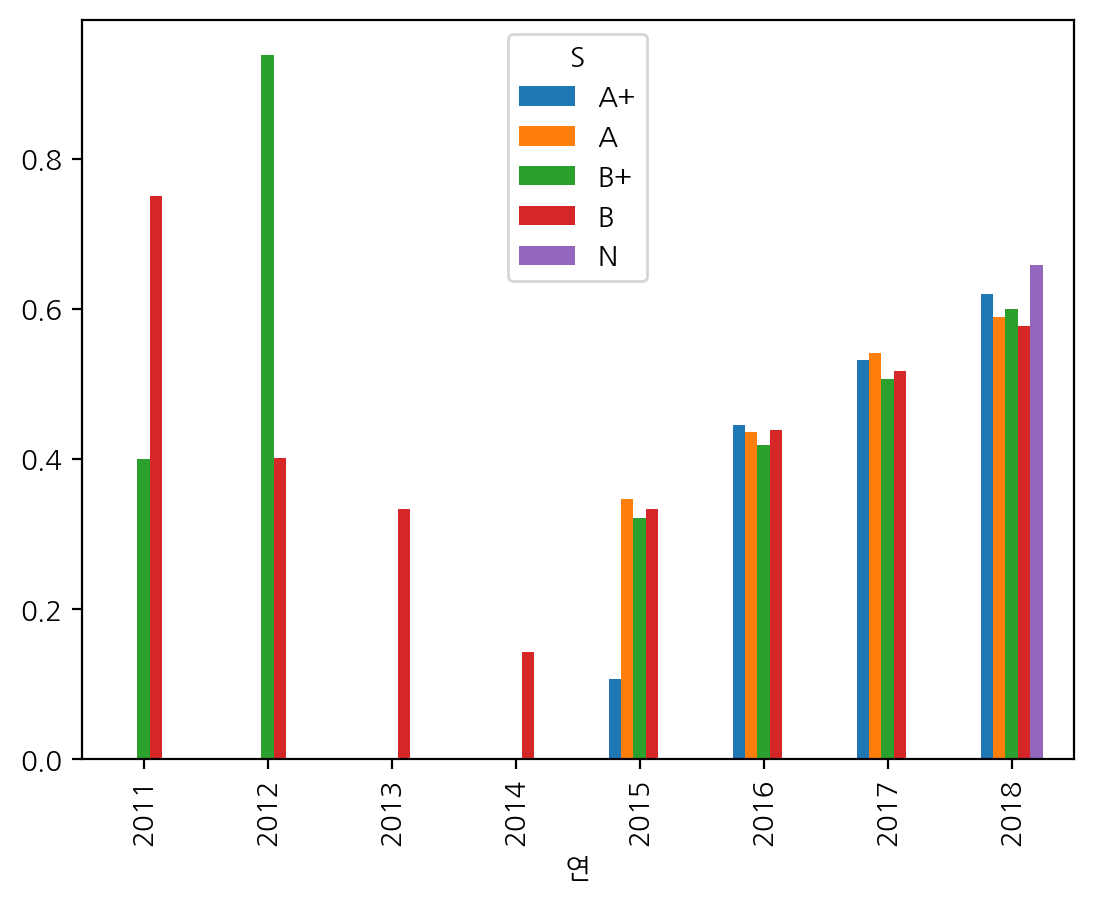

---------- ---------- ---------- ---------- ---------- 

기업총자산금액_mmscl
G


G           A+         A        B+         B        N
연                                                    
2011       NaN       NaN  0.399170  1.000000  0.50000
2012       NaN       NaN  0.937988  0.400635      NaN
2013       NaN       NaN       NaN  0.333333      NaN
2014       NaN       NaN  0.047241  0.284180      NaN
2015  0.212107  0.351651  0.345571  0.312549      NaN
2016  0.384613  0.455146  0.382077  0.448299      NaN
2017  0.381348  0.496929  0.511204  0.529150      NaN
2018  0.622070  0.551550  0.606209  0.591834  0.65801

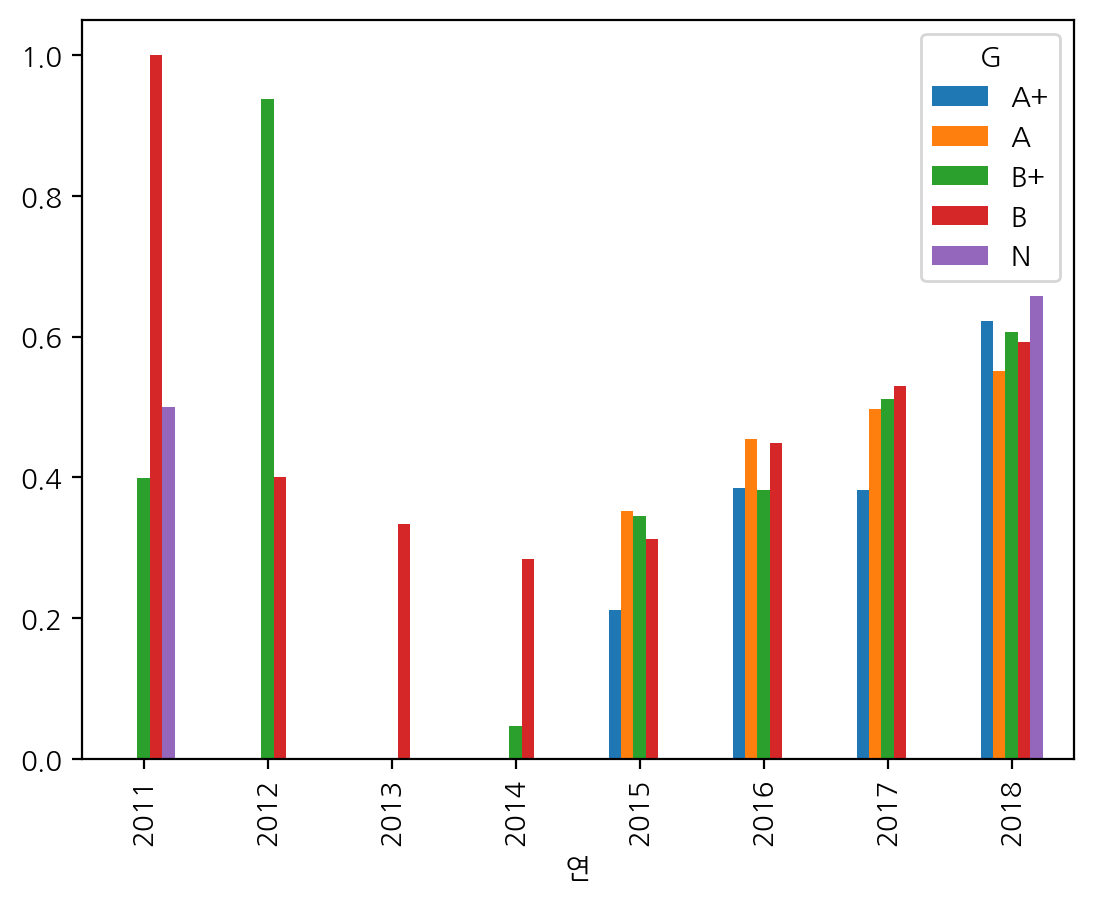

---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.365479  0.750000       NaN
2012        NaN       NaN  0.978027  0.702881       NaN
2013        NaN       NaN       NaN  0.403951       NaN
2014        NaN       NaN  0.003761  0.393127       NaN
2015        NaN  0.364986  0.458666  0.424886       NaN
2016   0.510579  0.462471  0.481678  0.456354       NaN
2017   0.541677  0.521544  0.448241  0.447775       NaN
2018   0.597855  0.476633  0.473919  0.463737  0.312964

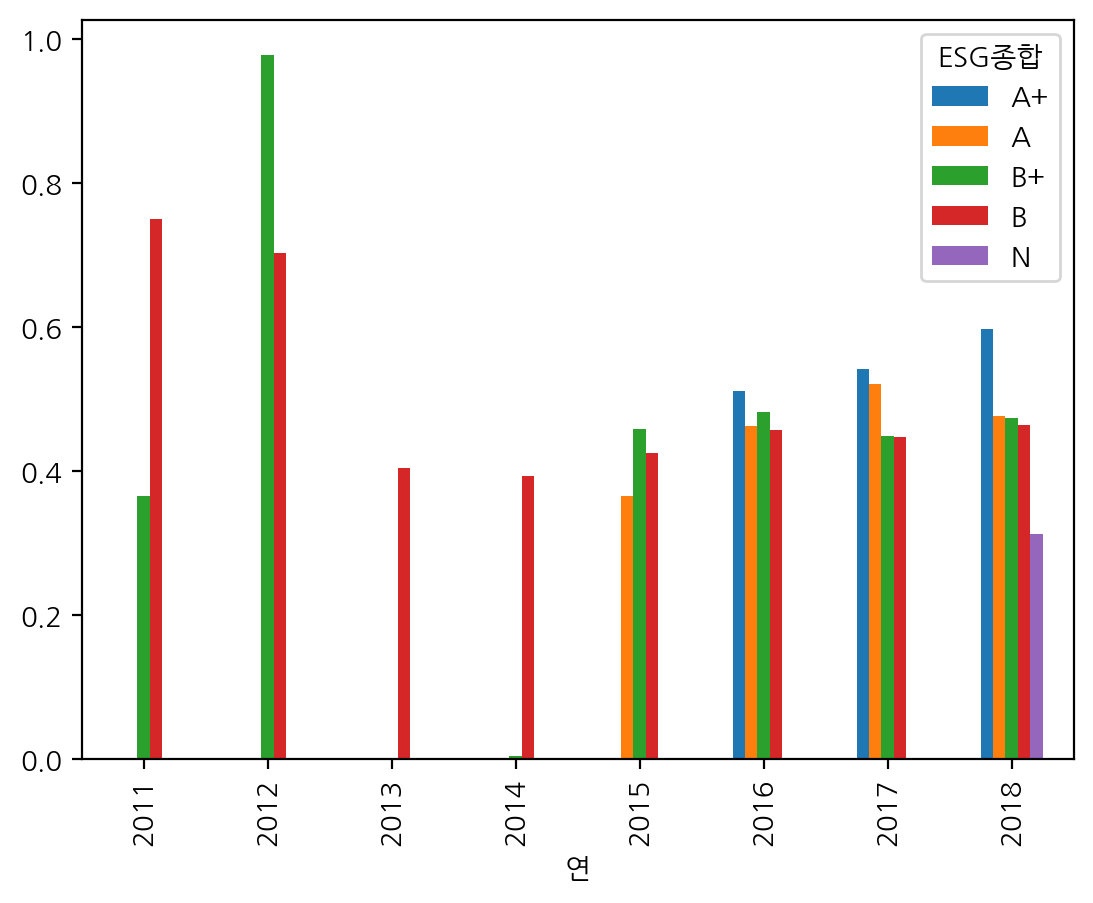

---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.591370  1.000000       NaN
2012       NaN       NaN       NaN  0.754150  0.875488       NaN
2013       NaN       NaN       NaN  0.098267  0.556793       NaN
2014       NaN       NaN  0.003761       NaN  0.393127       NaN
2015       NaN  0.266577  0.462053  0.433758  0.430346  0.442945
2016  0.487793  0.383589  0.420000  0.481073  0.479637  0.479477
2017  0.574425  0.452290  0.462018  0.476894  0.407423  0.385551
2018  0.707540  0.405709  0.489843  0.449475  0.466737  0.501213

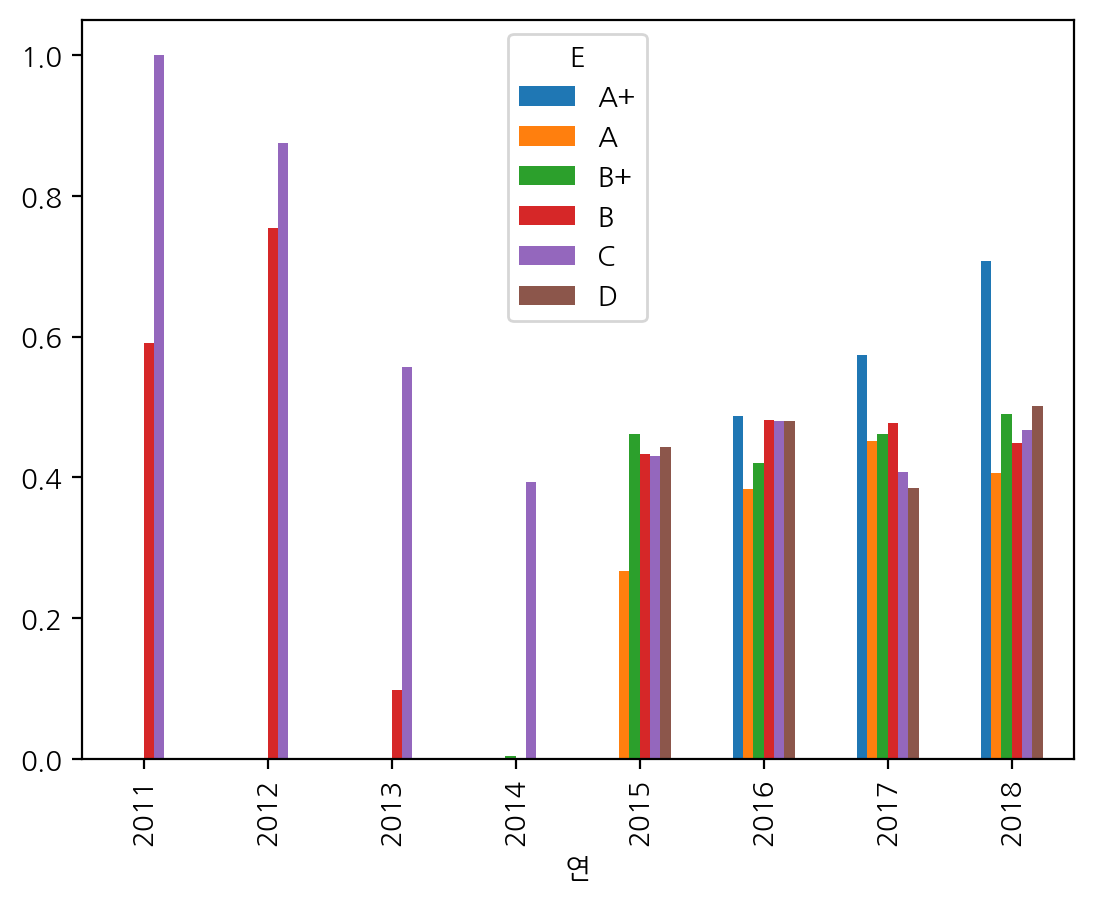

---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.365479  0.750000       NaN
2012       NaN       NaN  0.978027  0.702881       NaN
2013       NaN       NaN       NaN  0.403951       NaN
2014       NaN       NaN       NaN  0.315254       NaN
2015  0.284057  0.390867  0.439624  0.432800       NaN
2016  0.498219  0.485424  0.490093  0.442225       NaN
2017  0.515687  0.473347  0.434426  0.452738       NaN
2018  0.512121  0.528499  0.431322  0.470199  0.312964

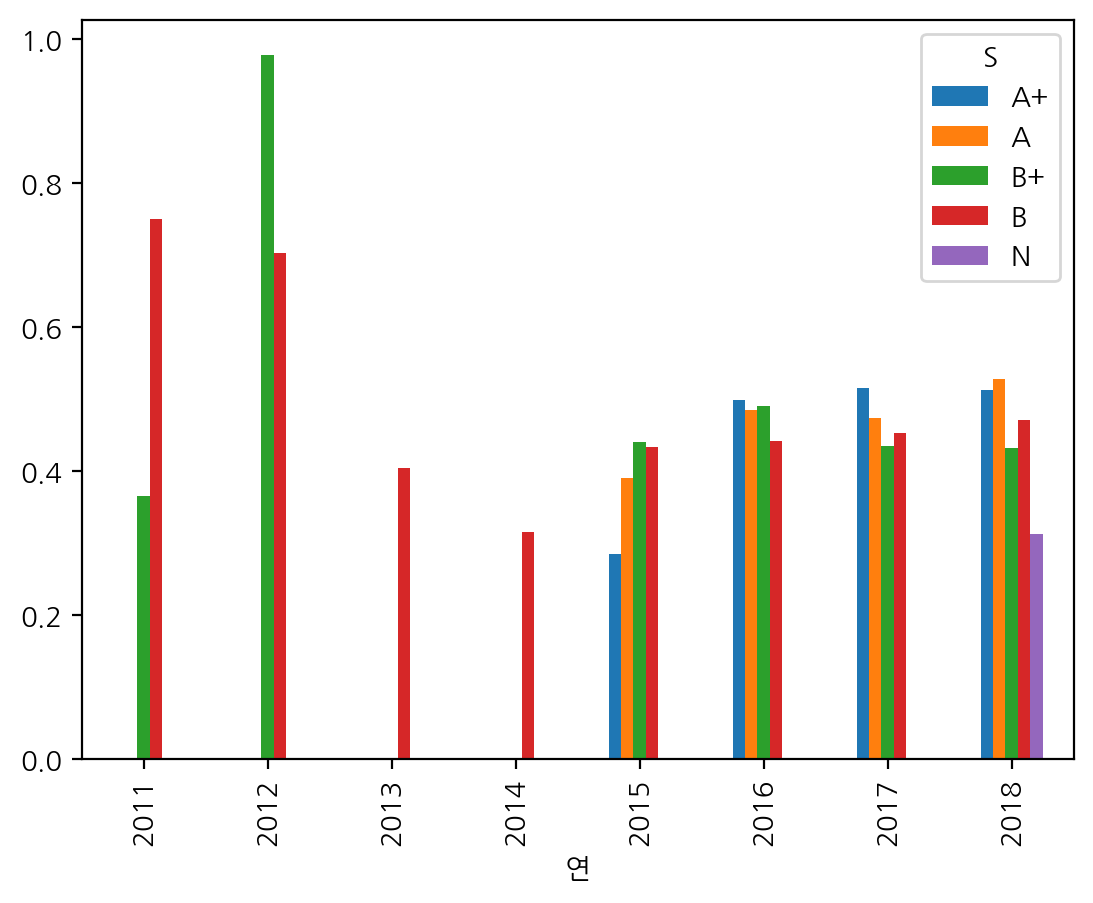

---------- ---------- ---------- ---------- ---------- 

기업총부채금액_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.365479  1.000000  0.500000
2012       NaN       NaN  0.978027  0.702881       NaN
2013       NaN       NaN       NaN  0.403951       NaN
2014       NaN       NaN  0.334587  0.286255       NaN
2015  0.242086  0.452753  0.479790  0.394800       NaN
2016  0.429199  0.513959  0.438303  0.459119       NaN
2017  0.476181  0.453949  0.464488  0.452446       NaN
2018  0.607422  0.409570  0.513651  0.461898  0.312964

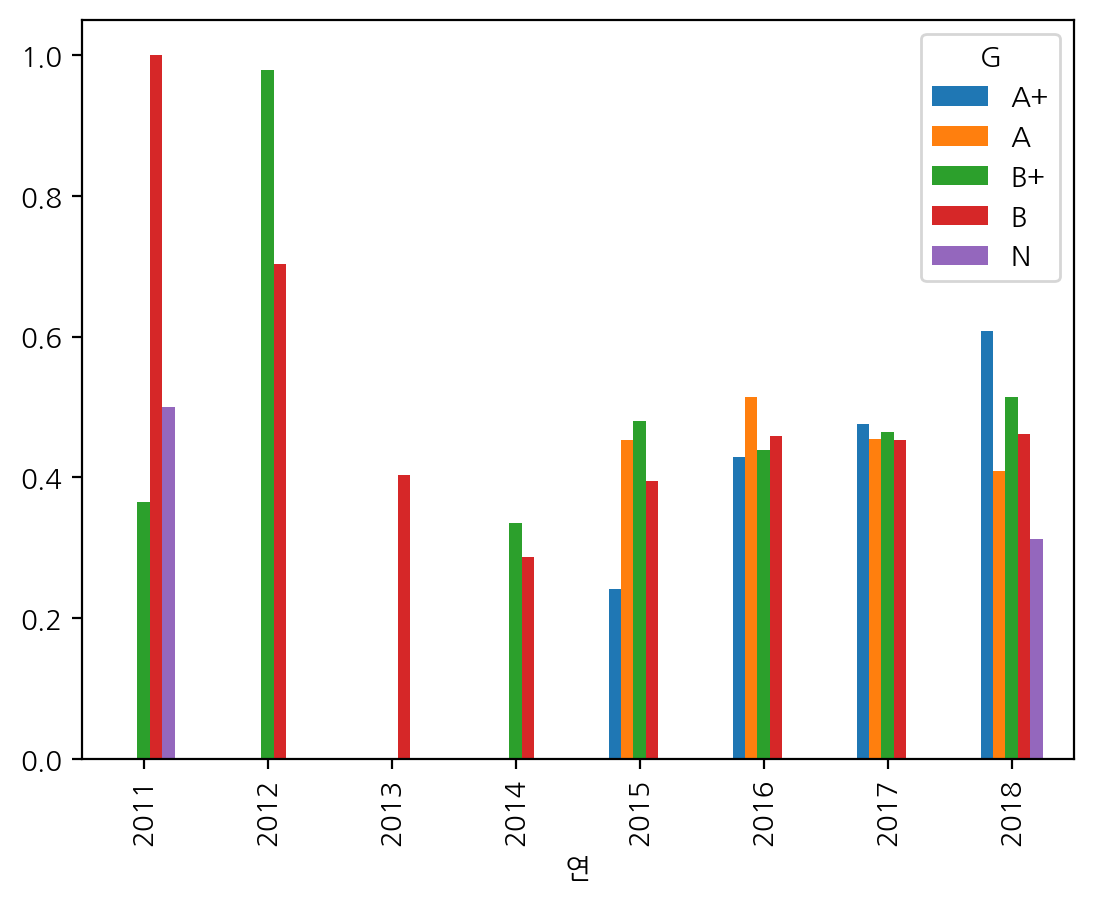

---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.514648  0.515526       NaN
2012        NaN       NaN  0.000000  0.000000       NaN
2013        NaN       NaN       NaN  0.151245       NaN
2014        NaN       NaN  0.331299  0.137085       NaN
2015        NaN  0.218774  0.227954  0.326974       NaN
2016   0.470256  0.367052  0.419064  0.471927       NaN
2017   0.562721  0.550431  0.548695  0.579691       NaN
2018   0.611092  0.620180  0.703470  0.667782  0.804911

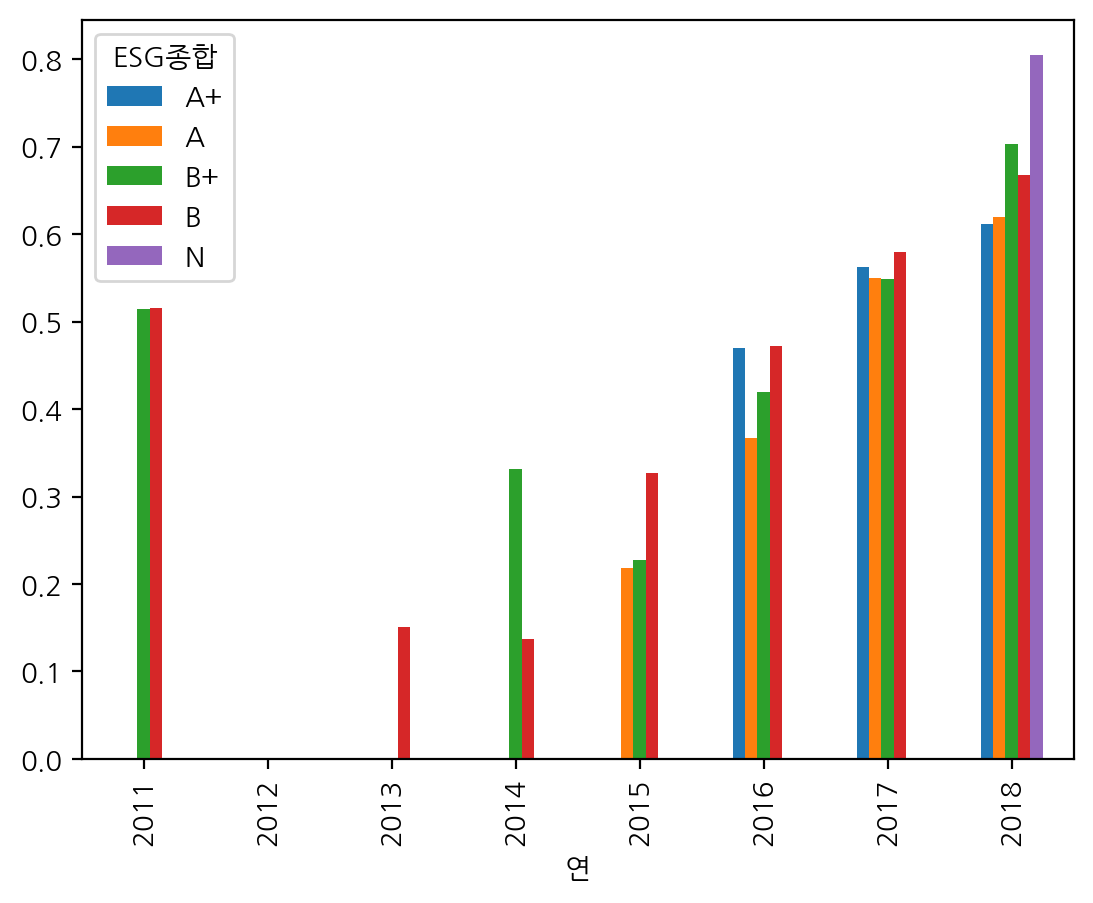

---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.394188  1.000000       NaN
2012       NaN       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.000000  0.226868       NaN
2014       NaN       NaN  0.331299       NaN  0.137085       NaN
2015       NaN  0.271270  0.290562  0.308081  0.287184  0.374355
2016  0.459747  0.364733  0.444428  0.441356  0.477716  0.499238
2017  0.722195  0.517487  0.564147  0.555992  0.631261  0.534222
2018  0.648163  0.600444  0.633535  0.733015  0.596240  0.810516

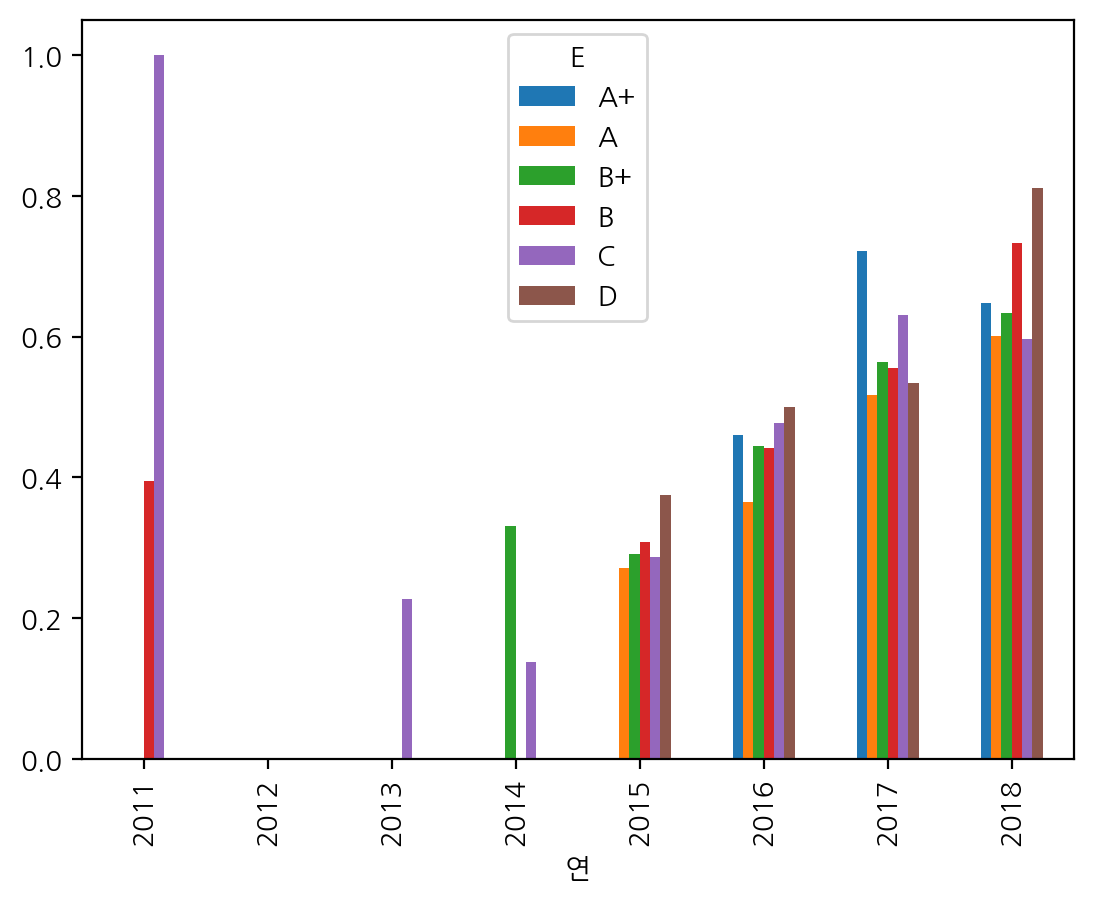

---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.514648  0.515526       NaN
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.151245       NaN
2014       NaN       NaN       NaN  0.175928       NaN
2015  0.054335  0.308284  0.265037  0.312712       NaN
2016  0.473925  0.464366  0.391298  0.478343       NaN
2017  0.535913  0.548727  0.578306  0.574732       NaN
2018  0.645812  0.657895  0.683312  0.669169  0.804911

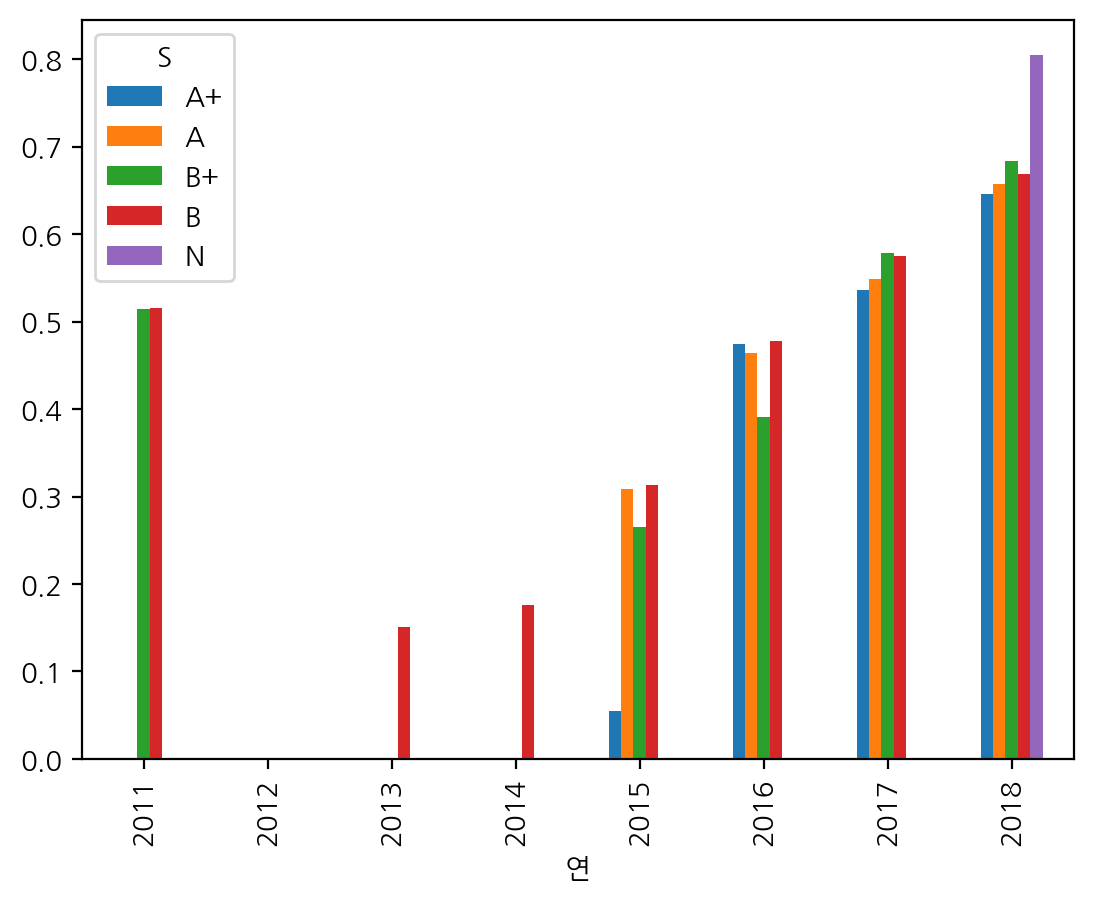

---------- ---------- ---------- ---------- ---------- 

기업총자본금액_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.514648  0.531052  0.500000
2012       NaN       NaN  0.000000  0.000000       NaN
2013       NaN       NaN       NaN  0.151245       NaN
2014       NaN       NaN  0.110433  0.274170       NaN
2015  0.202427  0.277126  0.263090  0.326430       NaN
2016  0.357178  0.433080  0.441472  0.462020       NaN
2017  0.243774  0.540086  0.605185  0.563074       NaN
2018  0.469543  0.700048  0.680910  0.657580  0.804911

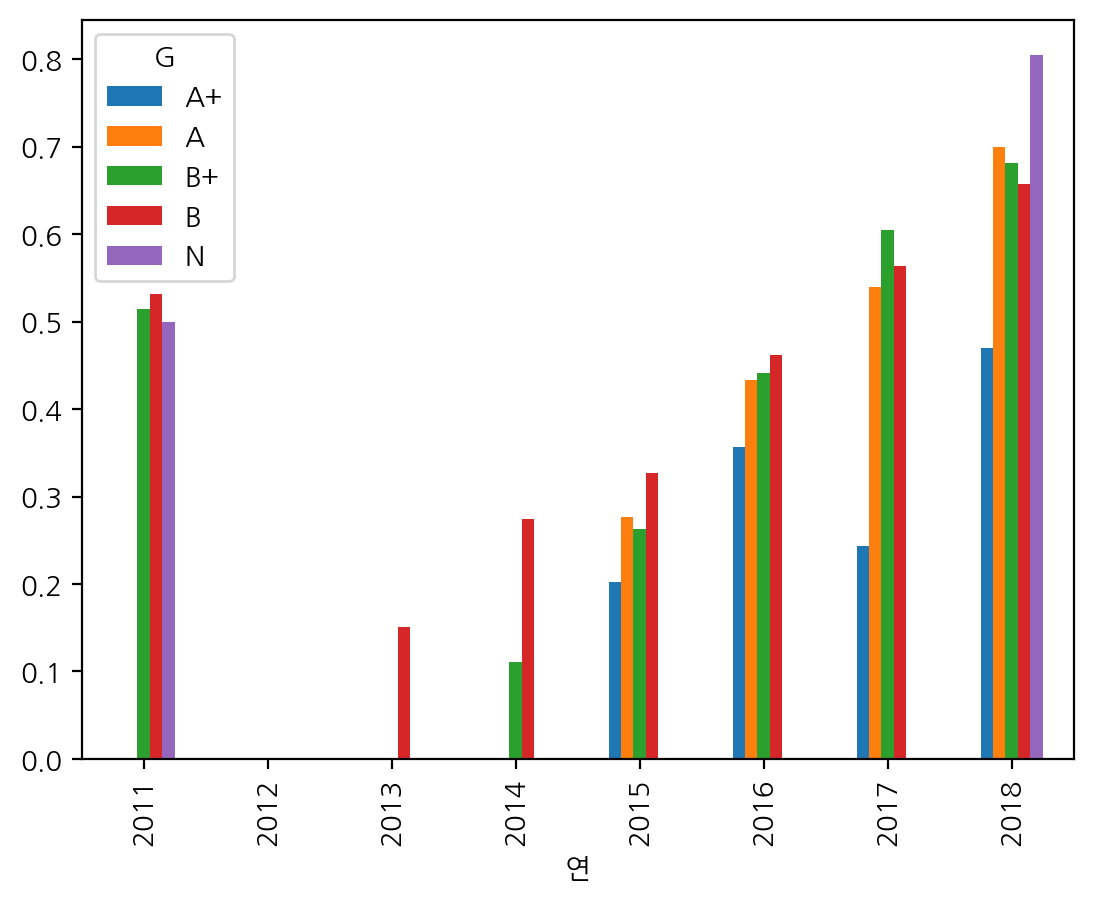

---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
ESG종합


ESG종합   A+         A        B+         B         N
연                                                 
2011   NaN       NaN  1.000000  0.491489       NaN
2012   NaN       NaN  1.000000  0.913574       NaN
2013   NaN       NaN       NaN  1.000000       NaN
2014   NaN       NaN  0.980957  0.750000       NaN
2015   NaN  0.122483  0.066076  0.109082       NaN
2016   0.5  0.076923  0.122032  0.128662       NaN
2017   1.0  0.924225  0.610305  0.736018       NaN
2018   1.0  0.776628  0.761905  0.750081  0.941243

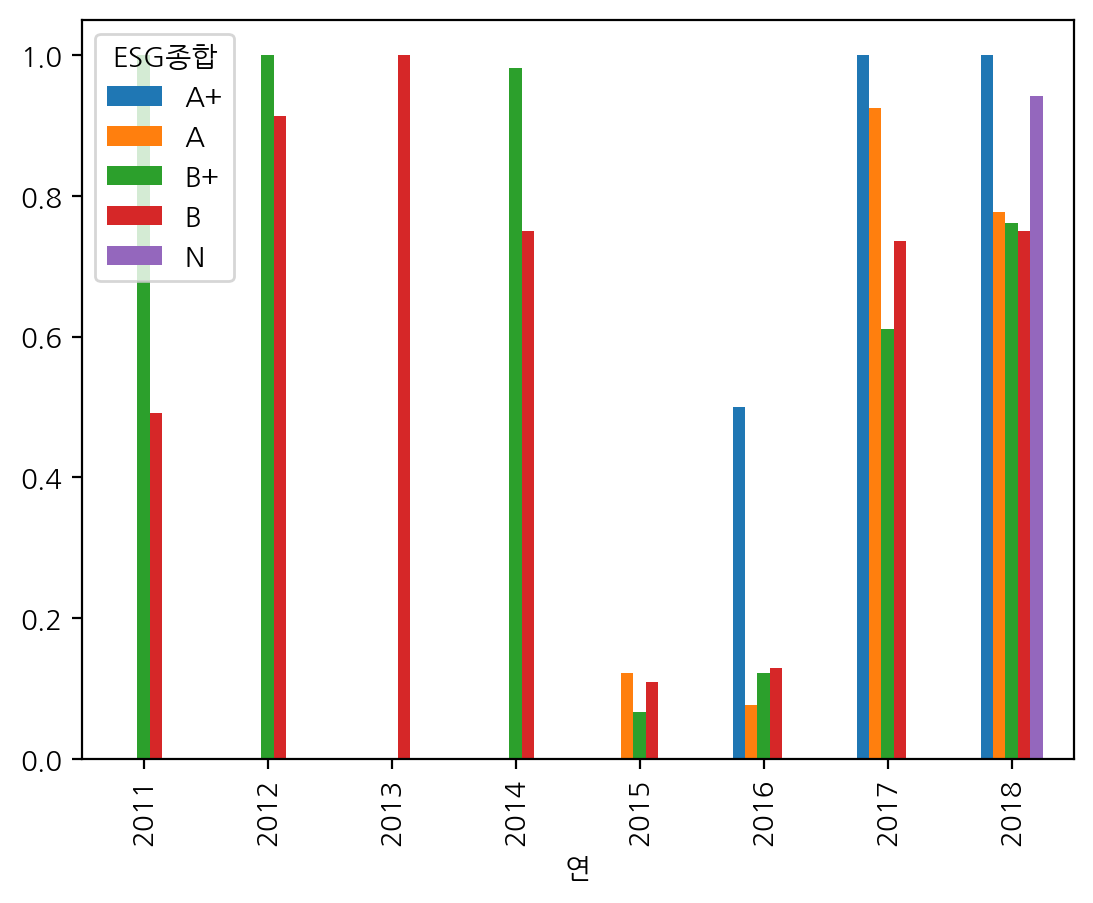

---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
E


E        A+         A        B+         B         C         D
연                                                            
2011    NaN       NaN       NaN  0.491489  1.000000       NaN
2012    NaN       NaN       NaN  0.913574  1.000000       NaN
2013    NaN       NaN       NaN  1.000000  1.000000       NaN
2014    NaN       NaN  0.980957       NaN  0.750000       NaN
2015    NaN  0.045455  0.085725  0.084919  0.137397  0.142857
2016  0.375  0.055556  0.133486  0.137462  0.088706  0.229919
2017  1.000  0.993440  0.638579  0.729024  0.755371  0.747620
2018  1.000  0.818954  0.730711  0.768778  0.728814  1.000000

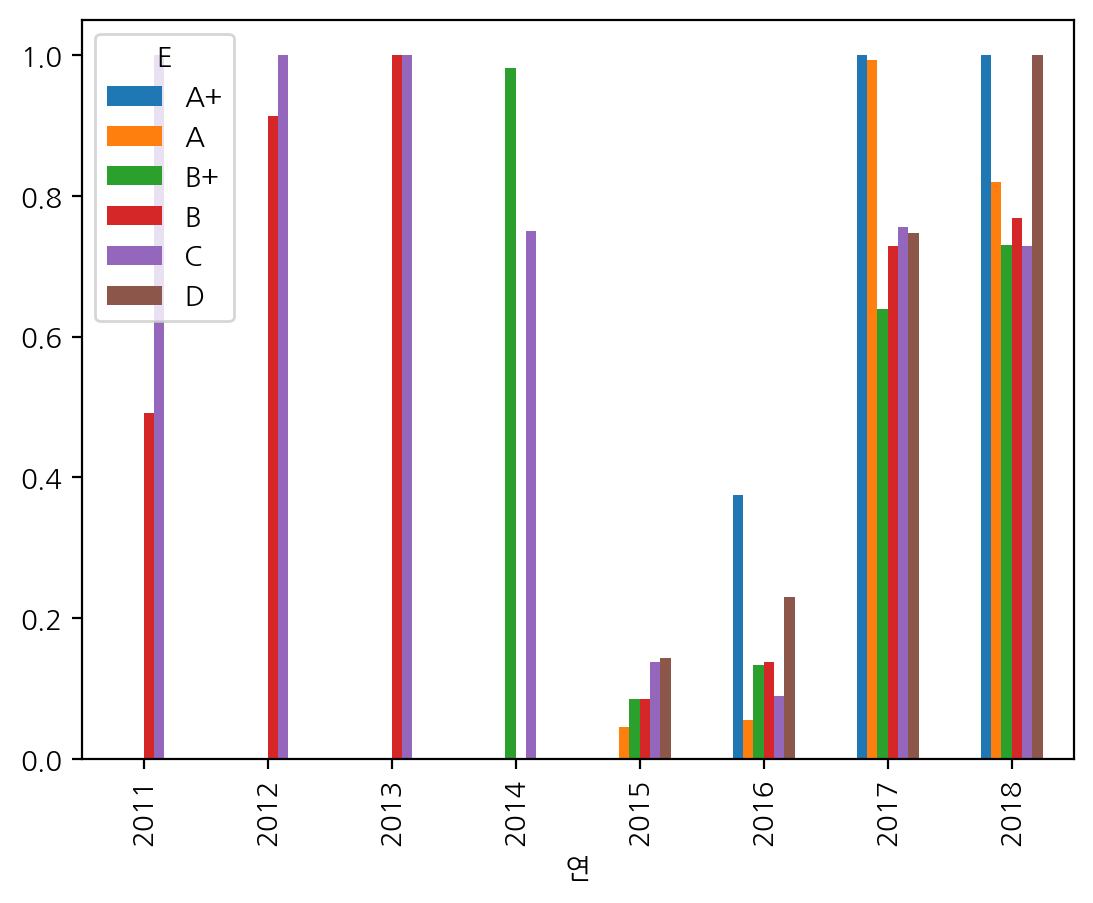

---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  1.000000  0.491489       NaN
2012       NaN       NaN  1.000000  0.913574       NaN
2013       NaN       NaN       NaN  1.000000       NaN
2014       NaN       NaN       NaN  0.796191       NaN
2015  0.166667  0.099518  0.101144  0.098799       NaN
2016  0.200000  0.172340  0.107716  0.125902       NaN
2017  0.878433  0.869168  0.631095  0.718914       NaN
2018  0.888889  0.748706  0.732673  0.748513  0.941243

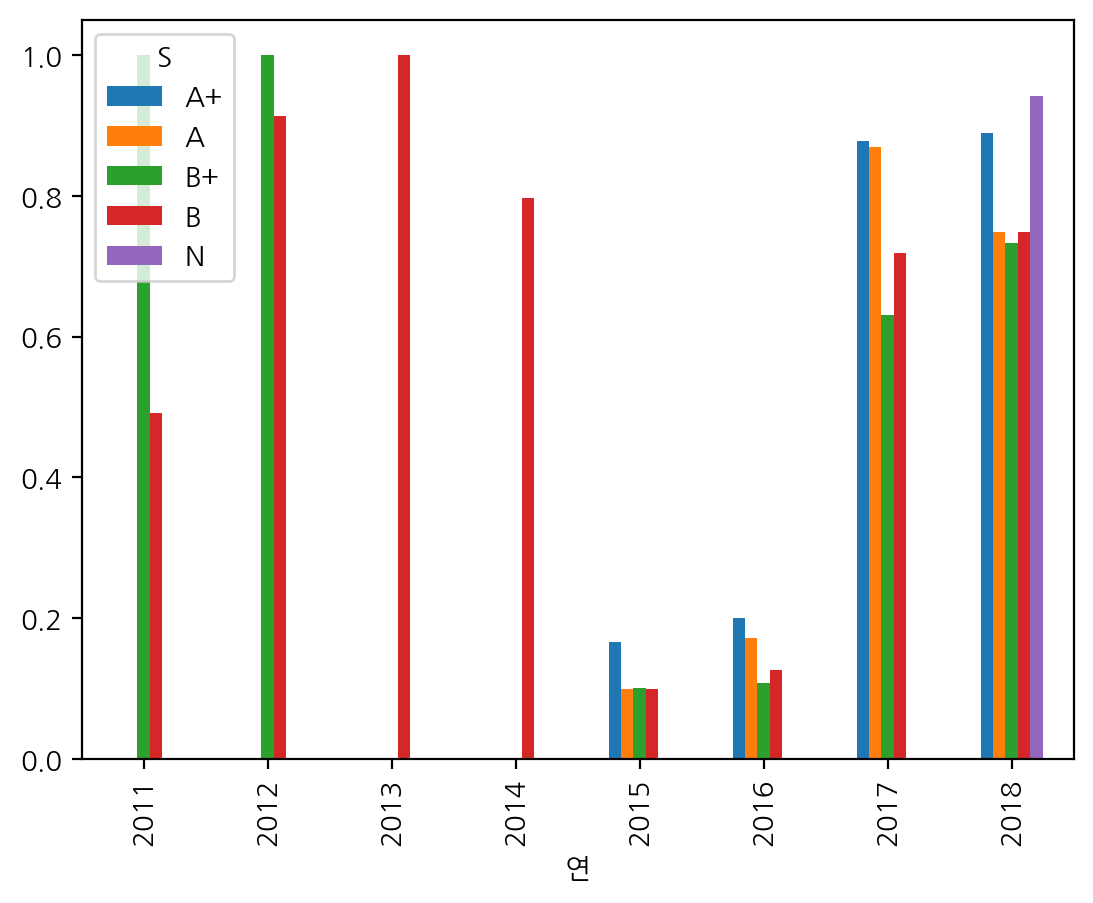

---------- ---------- ---------- ---------- ---------- 

기업자본금액_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  1.000000  0.864502  0.118475
2012       NaN       NaN  1.000000  0.913574       NaN
2013       NaN       NaN       NaN  1.000000       NaN
2014       NaN       NaN  0.660319  1.000000       NaN
2015  0.166667  0.128991  0.126335  0.074046       NaN
2016  0.500000  0.178560  0.119647  0.112671       NaN
2017  1.000000  0.840075  0.687002  0.710922       NaN
2018  1.000000  0.866948  0.747573  0.735063  0.941243

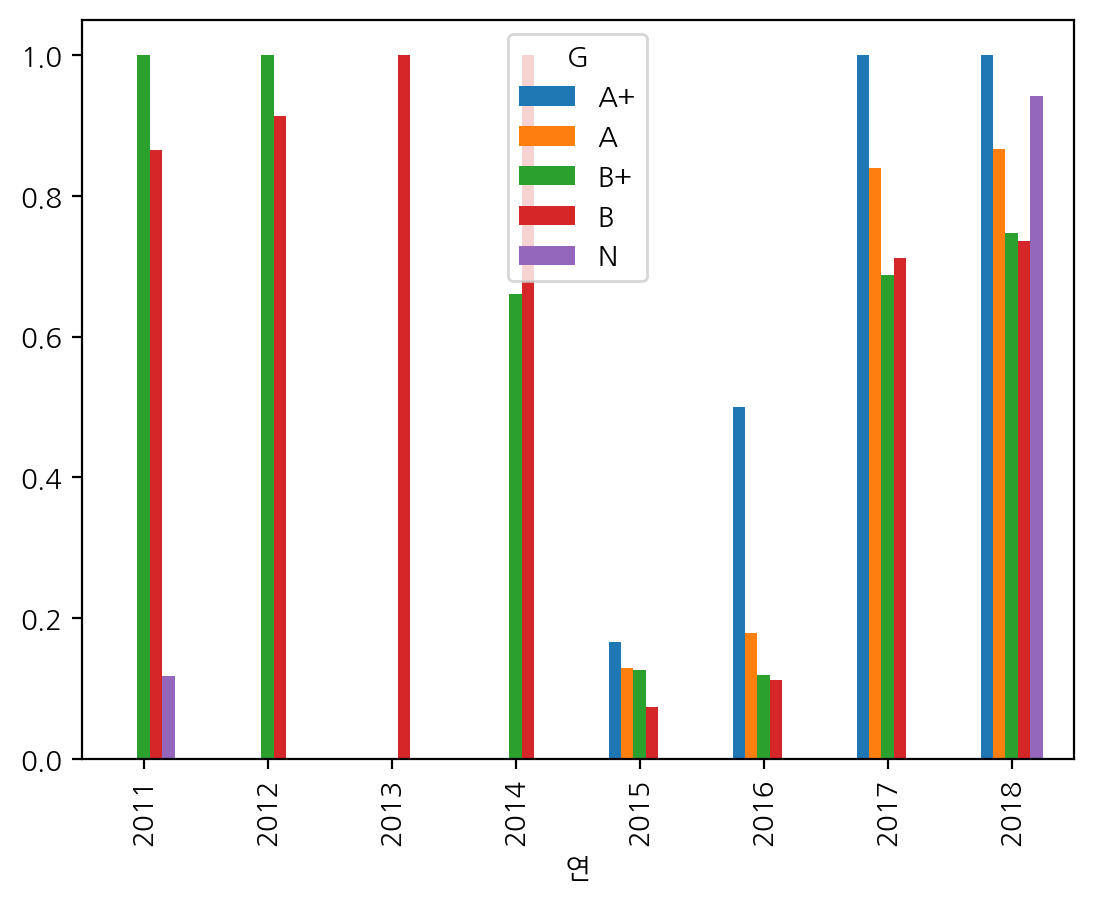

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
ESG종합


ESG종합        A+         A        B+         B         N
연                                                      
2011        NaN       NaN  0.378906  0.920166       NaN
2012        NaN       NaN  1.000000  0.928955       NaN
2013        NaN       NaN       NaN  0.451009       NaN
2014        NaN       NaN  0.000000  0.441284       NaN
2015        NaN  0.377269  0.589349  0.517536       NaN
2016   0.438232  0.540396  0.502747  0.441859       NaN
2017   0.498647  0.493289  0.408975  0.421416       NaN
2018   0.507332  0.478666  0.370720  0.409394  0.197021

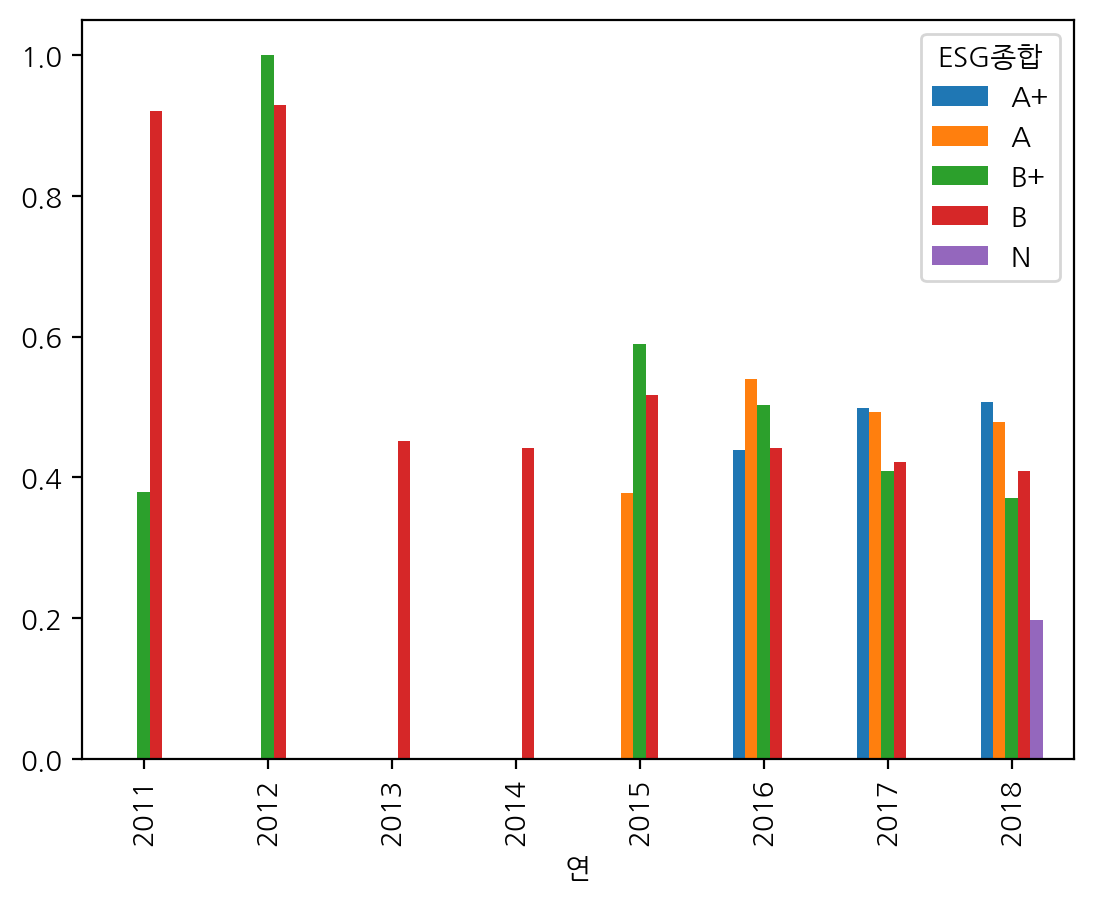

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
E


E           A+         A        B+         B         C         D
연                                                               
2011       NaN       NaN       NaN  0.764893  1.000000       NaN
2012       NaN       NaN       NaN  0.928955  1.000000       NaN
2013       NaN       NaN       NaN  0.000000  0.676514       NaN
2014       NaN       NaN  0.000000       NaN  0.441284       NaN
2015       NaN  0.330631  0.566661  0.527139  0.526093  0.549909
2016  0.439270  0.474191  0.431450  0.489422  0.456984  0.416084
2017  0.471802  0.374909  0.437188  0.456587  0.361037  0.381895
2018  0.648346  0.474841  0.409809  0.370969  0.441755  0.398048

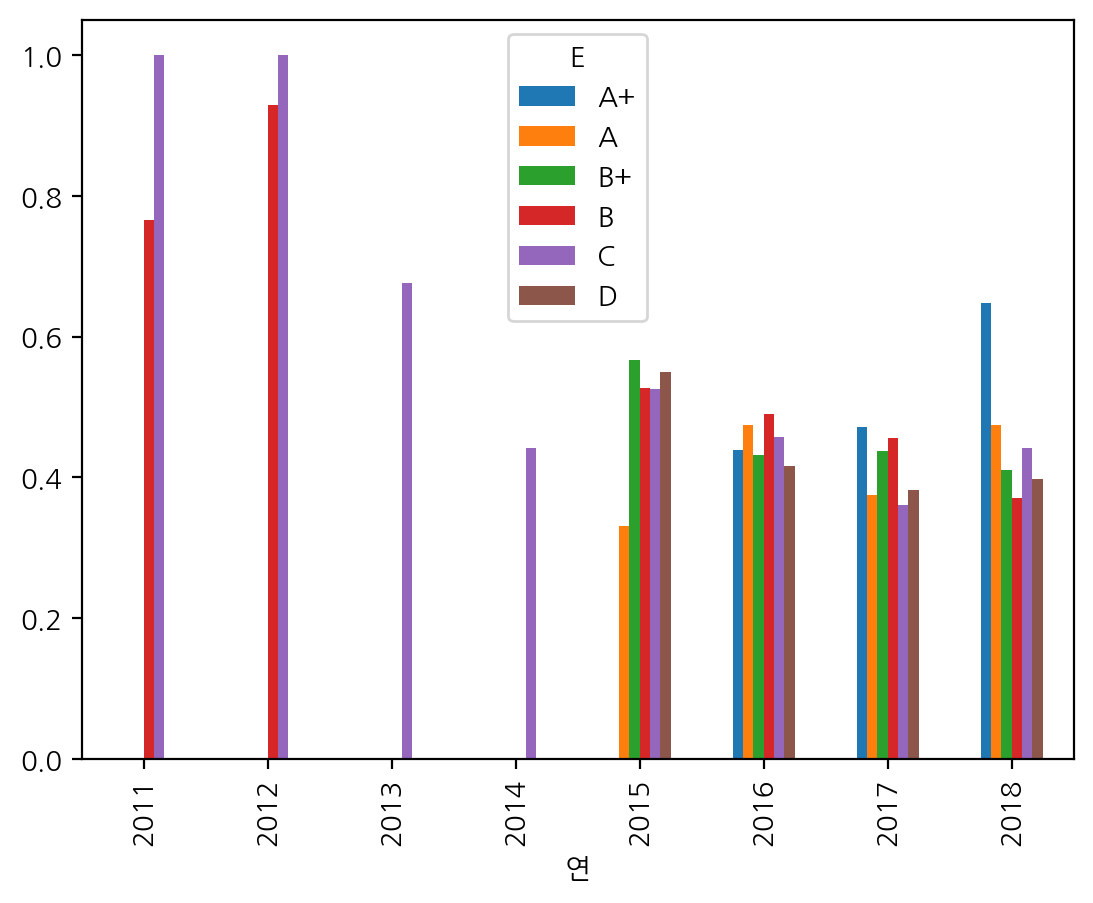

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
S


S           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.378906  0.920166       NaN
2012       NaN       NaN  1.000000  0.928955       NaN
2013       NaN       NaN       NaN  0.451009       NaN
2014       NaN       NaN       NaN  0.353027       NaN
2015  0.451359  0.388882  0.572315  0.526460       NaN
2016  0.470336  0.476469  0.509463  0.437721       NaN
2017  0.484208  0.443372  0.422294  0.415124       NaN
2018  0.490544  0.425247  0.345403  0.427415  0.197021

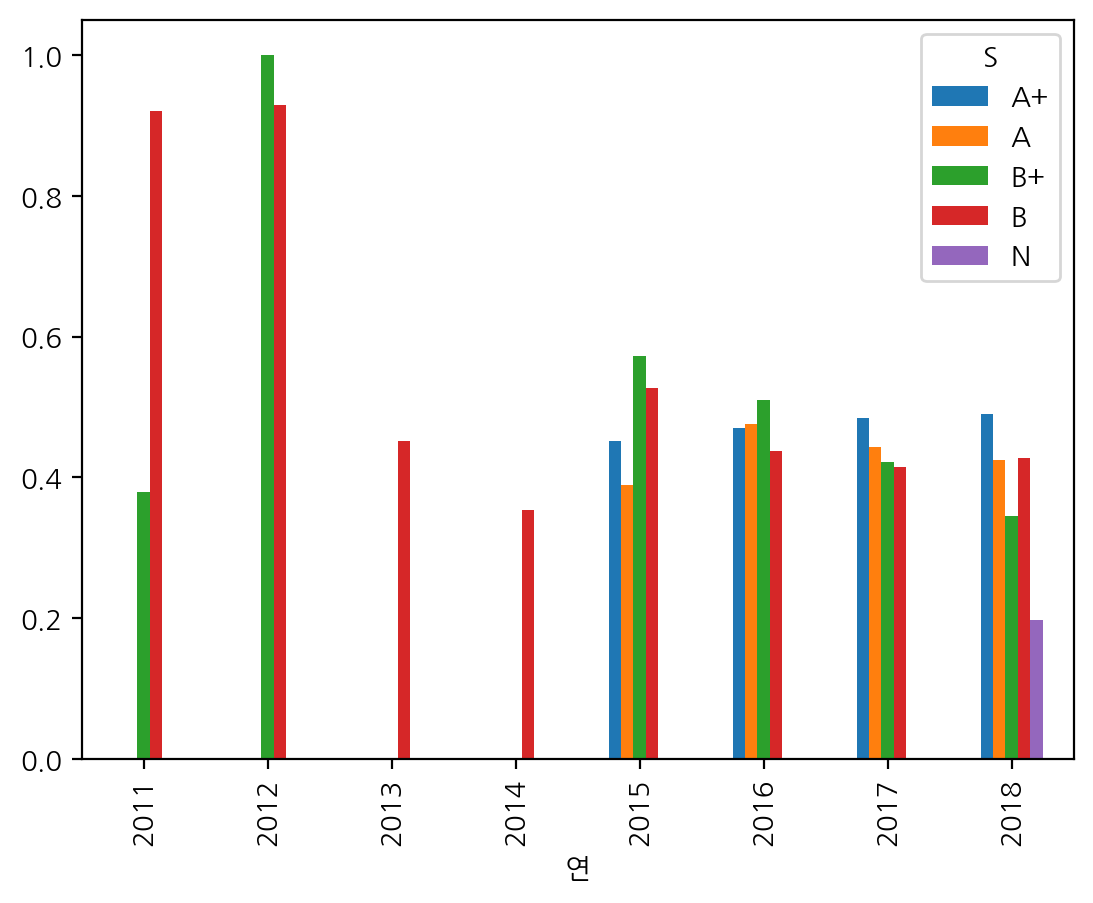

---------- ---------- ---------- ---------- ---------- 

재무제표부채비율_mmscl
G


G           A+         A        B+         B         N
연                                                     
2011       NaN       NaN  0.378906  1.000000  0.840332
2012       NaN       NaN  1.000000  0.928955       NaN
2013       NaN       NaN       NaN  0.451009       NaN
2014       NaN       NaN  0.333333  0.382568       NaN
2015  0.370687  0.487564  0.603973  0.488646       NaN
2016  0.474854  0.526021  0.449753  0.449863       NaN
2017  0.552338  0.455047  0.406665  0.426324       NaN
2018  0.498688  0.420795  0.400257  0.412846  0.197021

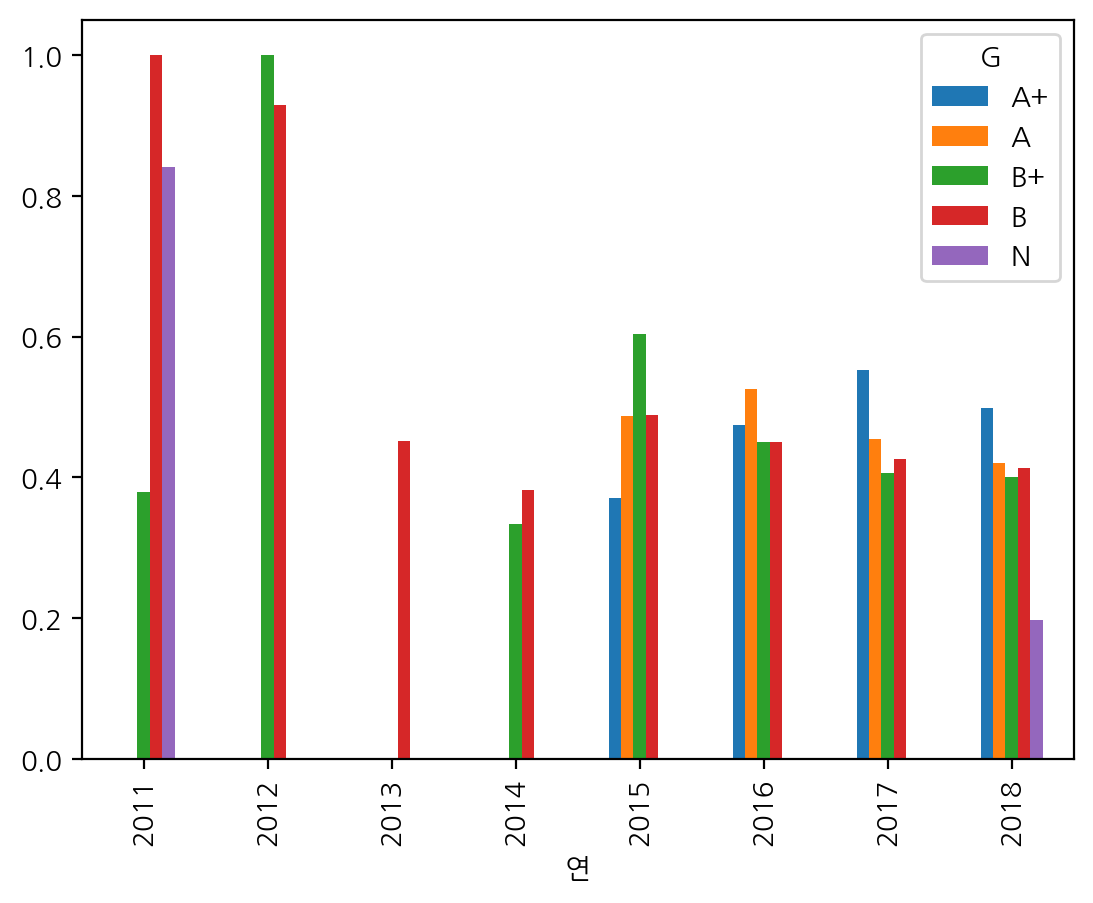

---------- ---------- ---------- ---------- ---------- 


In [29]:
finaStat = [
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]

for f in finaStat:
    for i in list_esg:
        print()
        print(f)
        print(i)

        d = df.pivot_table(f, ["연"], [i], aggfunc="mean")
        display(d)

        d.plot(kind="bar")
        plt.show()
        print("---------- " * 8)